## PREDICTIVE MAINTANENCE OF NASA TURBO FAN ENGINE 

### Introduction

During their lifetime, aircraft components
are susceptible to degradation, which affects
directly their reliability and performance.
This machine learning project will be directed to provide a framework for predict-
ing the aircraft’s remaining useful life (RUL)
based on the entire life cycle data in order
to provide the necessary maintenance behavior. Diverse regression, classification
models (KNN, Naïve Bayes, Random Forest,
SVM, etc..) are deployed and tested on the
NASA’s C-MAPSS data-set to assess the
engine’s lifetime. Please check the report for more theoretical details

<div align='center' > <img src='https://i.postimg.cc/gcvWCNHf/Turbofan-operation-lbp.png'>
 </div>

<div align='center' > Illustration of a turbofan engine </div>

Our focus will be the prediction of the
RUL of the turbofan engine considering
HPC failure and more precisely capturing
low RUL values to avoid putting the engine
on risk. 

This notebook will go through : Data inspection, Data visualization, Feature engineering, Regression, Classification and finishing with LSTM.

#### Importing initially important libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
import warnings
np.random.seed(34)
warnings.filterwarnings('ignore')

Note : make sure to adapt the way data is collected to your environment (If you're working on kaggle you can easily click on add data then choose nasa-cmaps data).

#### Defining features names

In [2]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

#### Importing train and validation data

FD001 subset corresponds to HPC failure of the engine.

Note: train data will be splitted to train/test sets in the modeling part.

In [3]:
dftrain = pd.read_csv('train_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
dfvalid = pd.read_csv('test_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
y_valid = pd.read_csv('RUL_FD001.txt',sep='\s+',header=None,index_col=False,names=['RUL'])
dfvalid.shape


(13096, 26)

In [4]:
train = dftrain.copy()
valid = dfvalid.copy()

### Data inspection

In [5]:
train

unit_number  time_cycles  setting_1  setting_2  setting_3     s_1  \
0                1            1    -0.0007    -0.0004      100.0  518.67   
1                1            2     0.0019    -0.0003      100.0  518.67   
2                1            3    -0.0043     0.0003      100.0  518.67   
3                1            4     0.0007     0.0000      100.0  518.67   
4                1            5    -0.0019    -0.0002      100.0  518.67   
...            ...          ...        ...        ...        ...     ...   
20626          100          196    -0.0004    -0.0003      100.0  518.67   
20627          100          197    -0.0016    -0.0005      100.0  518.67   
20628          100          198     0.0004     0.0000      100.0  518.67   
20629          100          199    -0.0011     0.0003      100.0  518.67   
20630          100          200    -0.0032    -0.0005      100.0  518.67   

          s_2      s_3      s_4    s_5  ...    s_12     s_13     s_14    s_15  \
0      641.82  1589.70  1400.60  14.62  ...  521.66  2388.02  8138.62  8.4195   
1      642.15  1591.82  1403.14  14.62  ...  522.28  2388.07  8131.49  8.4318   
2      642.35  1587.99  1404.20  14.62  ...  522.42  2388.03  8133.23  8.4178   
3      642.35  1582.79  1401.87  14.62  ...  522.86  2388.08  8133.83  8.3682   
4      642.37  1582.85  1406.22  14.62  ...  522.19  2388.04  8133.80  8.4294   
...       ...      ...      ...    ...  ...     ...      ...      ...     ...   
20626  643.49  1597.98  1428.63  14.62  ...  519.49  2388.26  8137.60  8.4956   
20627  643.54  1604.50  1433.58  14.62  ...  519.68  2388.22  8136.50  8.5139   
20628  643.42  1602.46  1428.18  14.62  ...  520.01  2388.24  8141.05  8.5646   
20629  643.23  1605.26  1426.53  14.62  ...  519.67  2388.23  8139.29  8.5389   
20630  643.85  1600.38  1432.14  14.62  ...  519.30  2388.26  8137.33  8.5036   

       s_16  s_17  s_18   s_19   s_20     s_21  
0      0.03   392  2388  100.0  39.06  23.4190  
1      0.03   392  2388  100.0  39.00  23.4236  
2      0.03   390  2388  100.0  38.95  23.3442  
3      0.03   392  2388  100.0  38.88  23.3739  
4      0.03   393  2388  100.0  38.90  23.4044  
...     ...   ...   ...    ...    ...      ...  
20626  0.03   397  2388  100.0  38.49  22.9735  
20627  0.03   395  2388  100.0  38.30  23.1594  
20628  0.03   398  2388  100.0  38.44  22.9333  
20629  0.03   395  2388  100.0  38.29  23.0640  
20630  0.03   396  2388  100.0  38.37  23.0522  

[20631 rows x 26 columns]

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   unit_number  20631 non-null  int64  
 1   time_cycles  20631 non-null  int64  
 2   setting_1    20631 non-null  float64
 3   setting_2    20631 non-null  float64
 4   setting_3    20631 non-null  float64
 5   s_1          20631 non-null  float64
 6   s_2          20631 non-null  float64
 7   s_3          20631 non-null  float64
 8   s_4          20631 non-null  float64
 9   s_5          20631 non-null  float64
 10  s_6          20631 non-null  float64
 11  s_7          20631 non-null  float64
 12  s_8          20631 non-null  float64
 13  s_9          20631 non-null  float64
 14  s_10         20631 non-null  float64
 15  s_11         20631 non-null  float64
 16  s_12         20631 non-null  float64
 17  s_13         20631 non-null  float64
 18  s_14         20631 non-null  float64
 19  s_15

In [7]:
train.describe().transpose()

count         mean           std        min        25%  \
unit_number  20631.0    51.506568  2.922763e+01     1.0000    26.0000   
time_cycles  20631.0   108.807862  6.888099e+01     1.0000    52.0000   
setting_1    20631.0    -0.000009  2.187313e-03    -0.0087    -0.0015   
setting_2    20631.0     0.000002  2.930621e-04    -0.0006    -0.0002   
setting_3    20631.0   100.000000  0.000000e+00   100.0000   100.0000   
s_1          20631.0   518.670000  6.537152e-11   518.6700   518.6700   
s_2          20631.0   642.680934  5.000533e-01   641.2100   642.3250   
s_3          20631.0  1590.523119  6.131150e+00  1571.0400  1586.2600   
s_4          20631.0  1408.933782  9.000605e+00  1382.2500  1402.3600   
s_5          20631.0    14.620000  3.394700e-12    14.6200    14.6200   
s_6          20631.0    21.609803  1.388985e-03    21.6000    21.6100   
s_7          20631.0   553.367711  8.850923e-01   549.8500   552.8100   
s_8          20631.0  2388.096652  7.098548e-02  2387.9000  2388.0500   
s_9          20631.0  9065.242941  2.208288e+01  9021.7300  9053.1000   
s_10         20631.0     1.300000  4.660829e-13     1.3000     1.3000   
s_11         20631.0    47.541168  2.670874e-01    46.8500    47.3500   
s_12         20631.0   521.413470  7.375534e-01   518.6900   520.9600   
s_13         20631.0  2388.096152  7.191892e-02  2387.8800  2388.0400   
s_14         20631.0  8143.752722  1.907618e+01  8099.9400  8133.2450   
s_15         20631.0     8.442146  3.750504e-02     8.3249     8.4149   
s_16         20631.0     0.030000  1.556432e-14     0.0300     0.0300   
s_17         20631.0   393.210654  1.548763e+00   388.0000   392.0000   
s_18         20631.0  2388.000000  0.000000e+00  2388.0000  2388.0000   
s_19         20631.0   100.000000  0.000000e+00   100.0000   100.0000   
s_20         20631.0    38.816271  1.807464e-01    38.1400    38.7000   
s_21         20631.0    23.289705  1.082509e-01    22.8942    23.2218   

                   50%        75%        max  
unit_number    52.0000    77.0000   100.0000  
time_cycles   104.0000   156.0000   362.0000  
setting_1       0.0000     0.0015     0.0087  
setting_2       0.0000     0.0003     0.0006  
setting_3     100.0000   100.0000   100.0000  
s_1           518.6700   518.6700   518.6700  
s_2           642.6400   643.0000   644.5300  
s_3          1590.1000  1594.3800  1616.9100  
s_4          1408.0400  1414.5550  1441.4900  
s_5            14.6200    14.6200    14.6200  
s_6            21.6100    21.6100    21.6100  
s_7           553.4400   554.0100   556.0600  
s_8          2388.0900  2388.1400  2388.5600  
s_9          9060.6600  9069.4200  9244.5900  
s_10            1.3000     1.3000     1.3000  
s_11           47.5100    47.7000    48.5300  
s_12          521.4800   521.9500   523.3800  
s_13         2388.0900  2388.1400  2388.5600  
s_14         8140.5400  8148.3100  8293.7200  
s_15            8.4389     8.4656     8.5848  
s_16            0.0300     0.0300     0.0300  
s_17          393.0000   394.0000   400.0000  
s_18         2388.0000  2388.0000  2388.0000  
s_19          100.0000   100.0000   100.0000  
s_20           38.8300    38.9500    39.4300  
s_21           23.2979    23.3668    23.6184

The dataset FD001 contains time series of 21 sensors and 3 settings of 100 units(turbofan engine).Each engine works normally at the beginning of each time series and fails at the end of the time series. Each row is a snapshot of the data taken during a single operation cycle.

In [8]:
print('Shape of the train dataset : ',train.shape)
print('Shape of the validation dataset : ',valid.shape)
print('Percentage of the validation dataset : ',len(valid)/(len(valid)+len(train)))

Shape of the train dataset :  (20631, 26)
Shape of the validation dataset :  (13096, 26)
Percentage of the validation dataset :  0.3882942449669404


In [9]:
#Cheking the presence of Nan values 
print('Total Null values in the train dataset : ',train.isna().sum())

Total Null values in the train dataset :  unit_number    0
time_cycles    0
setting_1      0
setting_2      0
setting_3      0
s_1            0
s_2            0
s_3            0
s_4            0
s_5            0
s_6            0
s_7            0
s_8            0
s_9            0
s_10           0
s_11           0
s_12           0
s_13           0
s_14           0
s_15           0
s_16           0
s_17           0
s_18           0
s_19           0
s_20           0
s_21           0
dtype: int64


No missing value is detected

In [10]:
train.loc[:,['unit_number','time_cycles']].describe()

unit_number   time_cycles
count  20631.000000  20631.000000
mean      51.506568    108.807862
std       29.227633     68.880990
min        1.000000      1.000000
25%       26.000000     52.000000
50%       52.000000    104.000000
75%       77.000000    156.000000
max      100.000000    362.000000

When we inspect the descriptive statistics of unit_nr we can see the dataset has a total of 20631 rows, unit numbers start at 1 and end at 100 as expected. What’s interesting, is that the mean and quantiles don’t align neatly with the descriptive statistics of a vector from 1–100, this can be explained due to each unit having different max time_cycles and thus a different number of rows. When inspecting the max time_cycles you can see the engine which failed the earliest did so after 128 cycles, whereas the engine which operated the longest broke down after 362 cycles. The average engine breaks between 199 and 206 cycles, however the standard deviation of 46 cycles is rather big. We’ll visualize this further down below to get an even better understanding.

In [11]:
train.loc[:,'s_1':].describe().transpose()

count         mean           std        min        25%        50%  \
s_1   20631.0   518.670000  6.537152e-11   518.6700   518.6700   518.6700   
s_2   20631.0   642.680934  5.000533e-01   641.2100   642.3250   642.6400   
s_3   20631.0  1590.523119  6.131150e+00  1571.0400  1586.2600  1590.1000   
s_4   20631.0  1408.933782  9.000605e+00  1382.2500  1402.3600  1408.0400   
s_5   20631.0    14.620000  3.394700e-12    14.6200    14.6200    14.6200   
s_6   20631.0    21.609803  1.388985e-03    21.6000    21.6100    21.6100   
s_7   20631.0   553.367711  8.850923e-01   549.8500   552.8100   553.4400   
s_8   20631.0  2388.096652  7.098548e-02  2387.9000  2388.0500  2388.0900   
s_9   20631.0  9065.242941  2.208288e+01  9021.7300  9053.1000  9060.6600   
s_10  20631.0     1.300000  4.660829e-13     1.3000     1.3000     1.3000   
s_11  20631.0    47.541168  2.670874e-01    46.8500    47.3500    47.5100   
s_12  20631.0   521.413470  7.375534e-01   518.6900   520.9600   521.4800   
s_13  20631.0  2388.096152  7.191892e-02  2387.8800  2388.0400  2388.0900   
s_14  20631.0  8143.752722  1.907618e+01  8099.9400  8133.2450  8140.5400   
s_15  20631.0     8.442146  3.750504e-02     8.3249     8.4149     8.4389   
s_16  20631.0     0.030000  1.556432e-14     0.0300     0.0300     0.0300   
s_17  20631.0   393.210654  1.548763e+00   388.0000   392.0000   393.0000   
s_18  20631.0  2388.000000  0.000000e+00  2388.0000  2388.0000  2388.0000   
s_19  20631.0   100.000000  0.000000e+00   100.0000   100.0000   100.0000   
s_20  20631.0    38.816271  1.807464e-01    38.1400    38.7000    38.8300   
s_21  20631.0    23.289705  1.082509e-01    22.8942    23.2218    23.2979   

            75%        max  
s_1    518.6700   518.6700  
s_2    643.0000   644.5300  
s_3   1594.3800  1616.9100  
s_4   1414.5550  1441.4900  
s_5     14.6200    14.6200  
s_6     21.6100    21.6100  
s_7    554.0100   556.0600  
s_8   2388.1400  2388.5600  
s_9   9069.4200  9244.5900  
s_10     1.3000     1.3000  
s_11    47.7000    48.5300  
s_12   521.9500   523.3800  
s_13  2388.1400  2388.5600  
s_14  8148.3100  8293.7200  
s_15     8.4656     8.5848  
s_16     0.0300     0.0300  
s_17   394.0000   400.0000  
s_18  2388.0000  2388.0000  
s_19   100.0000   100.0000  
s_20    38.9500    39.4300  
s_21    23.3668    23.6184

### Data visualization & Feature engineering

### Max time cycle found for each Unit

Let us see the maximum time cycle of each unit

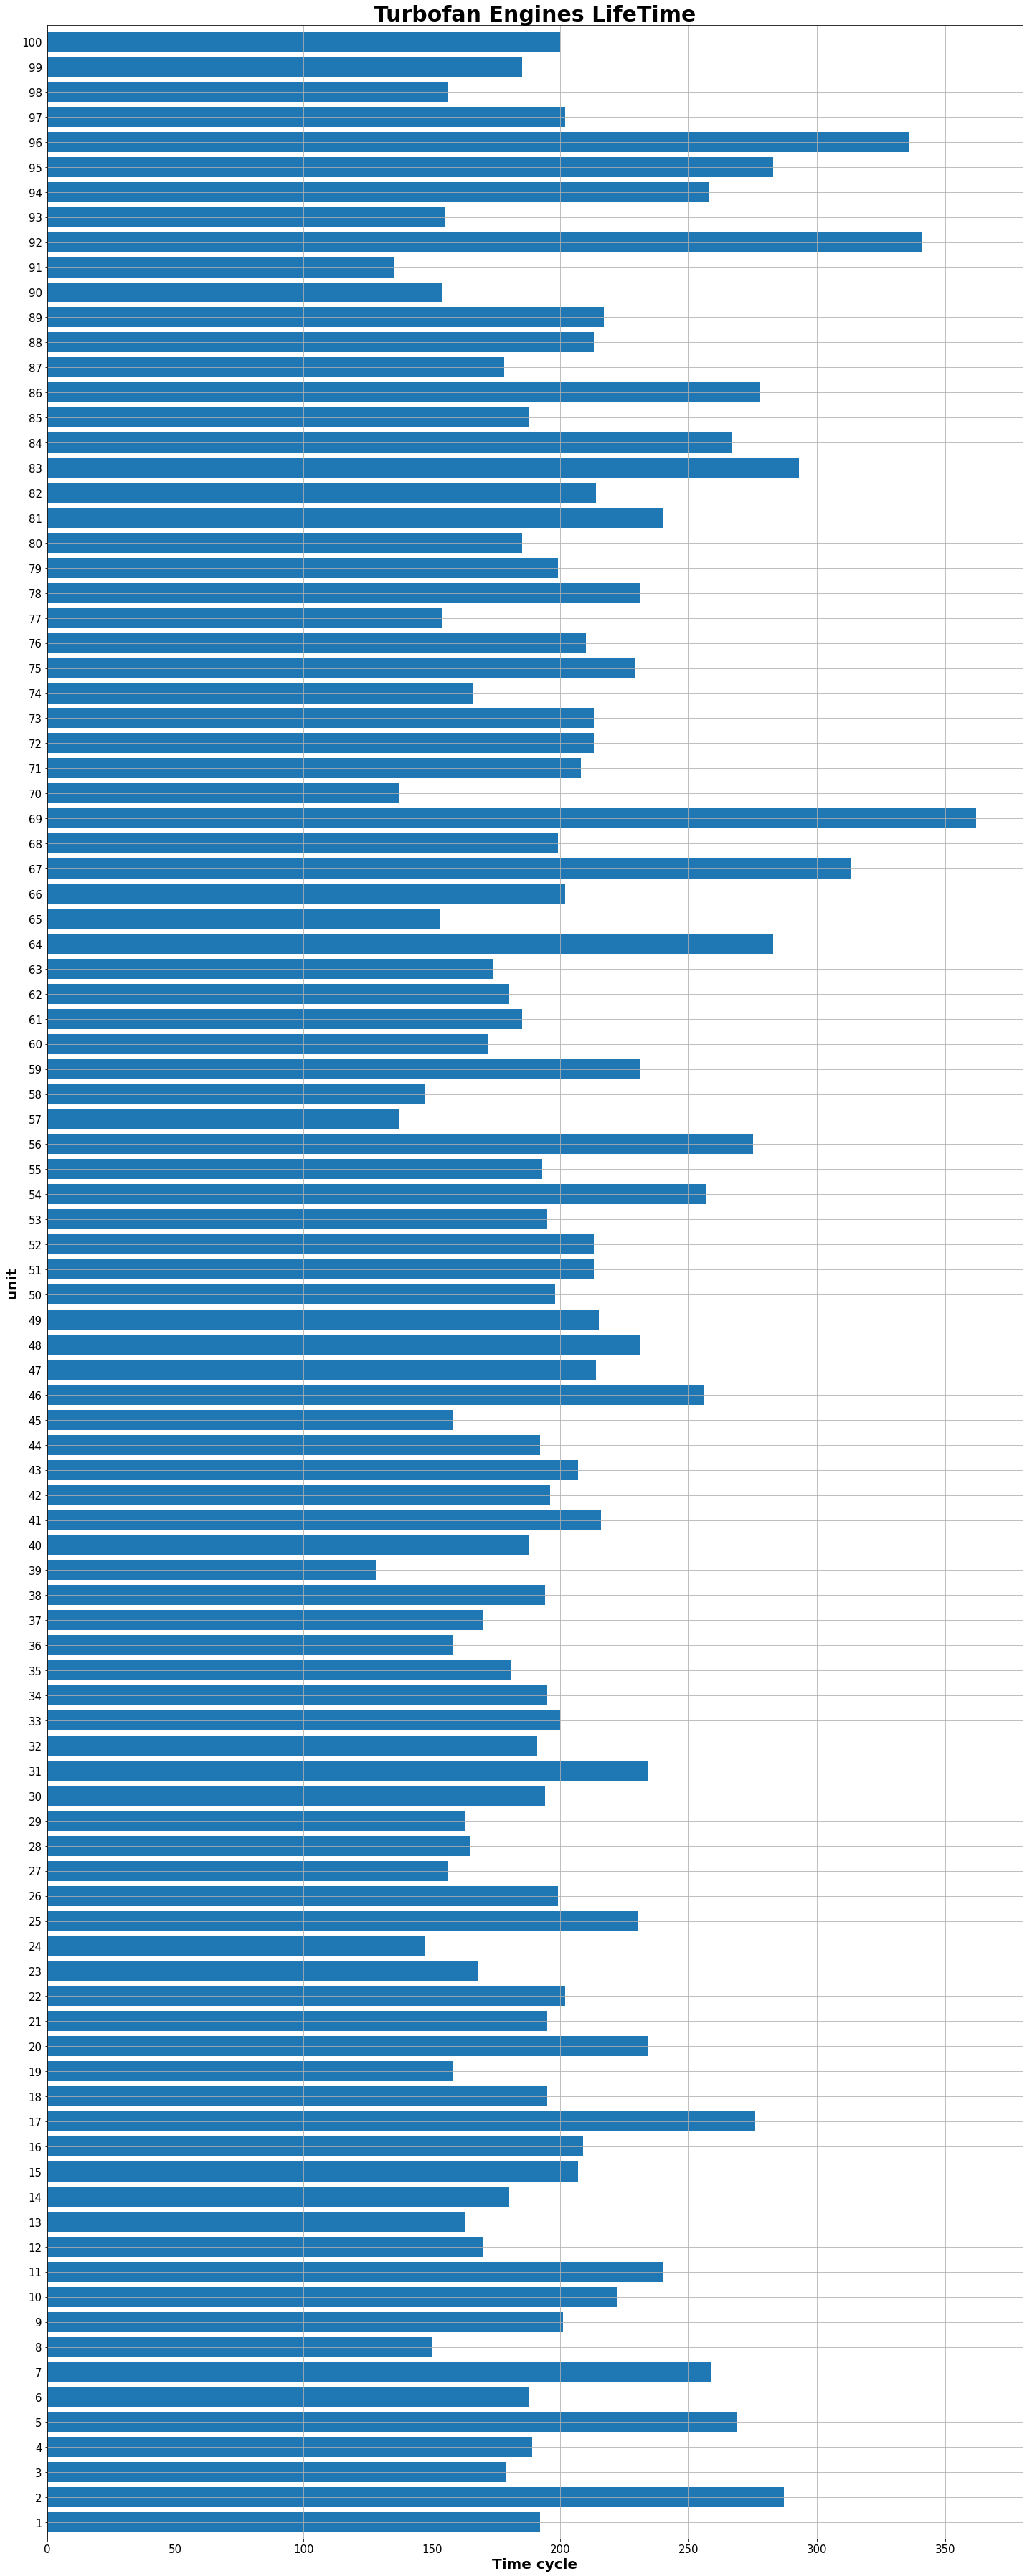

In [12]:
max_time_cycles=train[index_names].groupby('unit_number').max()
plt.figure(figsize=(20,50))
ax=max_time_cycles['time_cycles'].plot(kind='barh',width=0.8, stacked=True,align='center')
plt.title('Turbofan Engines LifeTime',fontweight='bold',size=30)
plt.xlabel('Time cycle',fontweight='bold',size=20)
plt.xticks(size=15)
plt.ylabel('unit',fontweight='bold',size=20)
plt.yticks(size=15)
plt.grid(True)
plt.tight_layout()
plt.show()

Text(0.5, 6.800000000000011, 'max time cycle')

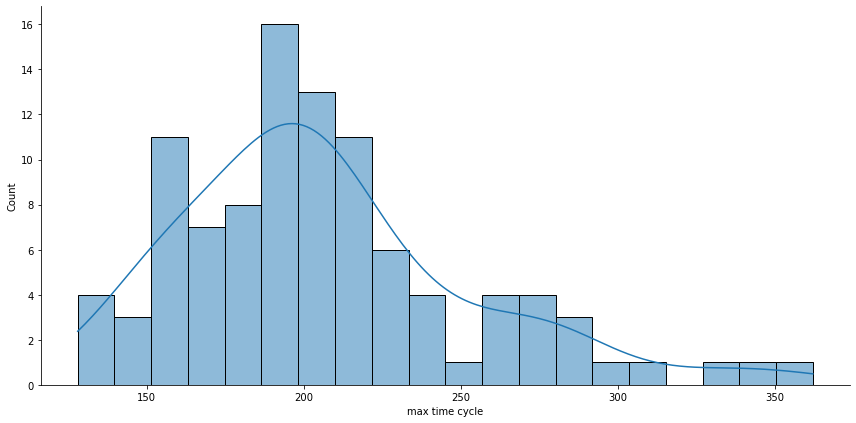

In [13]:
#Distribution of maximum time cycles
sns.displot(max_time_cycles['time_cycles'],kde=True,bins=20,height=6,aspect=2)
plt.xlabel('max time cycle')

We notice that in most of the time, the maximum time cycles that an engine can achieve is between 190 and 210 before HPC failure.

### Add RUL column to the data

###### RUL  corresponds to the remaining time cycles for each unit before it fails.

In [14]:
def add_RUL_column(df):
    train_grouped_by_unit = df.groupby(by='unit_number') 
    max_time_cycles = train_grouped_by_unit['time_cycles'].max() 
    merged = df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='unit_number',right_index=True)
    merged["RUL"] = merged["max_time_cycle"] - merged['time_cycles']
    merged = merged.drop("max_time_cycle", axis=1) 
    return merged

In [15]:
train = add_RUL_column(train)

In [16]:
train[['unit_number','RUL']]

unit_number  RUL
0                1  191
1                1  190
2                1  189
3                1  188
4                1  187
...            ...  ...
20626          100    4
20627          100    3
20628          100    2
20629          100    1
20630          100    0

[20631 rows x 2 columns]

In [17]:
#Rul analysis
maxrul_u = train.groupby('unit_number').max().reset_index()
maxrul_u.head()

unit_number  time_cycles  setting_1  setting_2  setting_3     s_1     s_2  \
0            1          192     0.0047     0.0005      100.0  518.67  644.21   
1            2          287     0.0076     0.0006      100.0  518.67  643.94   
2            3          179     0.0058     0.0005      100.0  518.67  643.93   
3            4          189     0.0059     0.0006      100.0  518.67  644.53   
4            5          269     0.0055     0.0005      100.0  518.67  644.02   

       s_3      s_4    s_5  ...     s_13     s_14    s_15  s_16  s_17  s_18  \
0  1605.44  1432.52  14.62  ...  2388.35  8140.58  8.5227  0.03   398  2388   
1  1610.10  1431.17  14.62  ...  2388.26  8175.57  8.5377  0.03   398  2388   
2  1606.50  1438.51  14.62  ...  2388.20  8255.34  8.5363  0.03   399  2388   
3  1612.11  1434.12  14.62  ...  2388.17  8259.42  8.5462  0.03   399  2388   
4  1609.41  1434.59  14.62  ...  2388.23  8215.19  8.5410  0.03   398  2388   

    s_19   s_20     s_21  RUL  
0  100.0  39.18  23.4999  191  
1  100.0  39.24  23.6005  286  
2  100.0  39.23  23.5181  178  
3  100.0  39.21  23.5074  188  
4  100.0  39.29  23.5503  268  

[5 rows x 27 columns]

In [18]:
df_train = pd.read_csv('train_FD001.txt',sep='\s+',header=None,index_col='unit_number',names=col_names)
df_valid = pd.read_csv('test_FD001.txt',sep='\s+',header=None,index_col='unit_number',names=col_names)

In [19]:
df_train.head()

time_cycles  setting_1  setting_2  setting_3     s_1     s_2  \
unit_number                                                                 
1                      1    -0.0007    -0.0004      100.0  518.67  641.82   
1                      2     0.0019    -0.0003      100.0  518.67  642.15   
1                      3    -0.0043     0.0003      100.0  518.67  642.35   
1                      4     0.0007     0.0000      100.0  518.67  642.35   
1                      5    -0.0019    -0.0002      100.0  518.67  642.37   

                 s_3      s_4    s_5    s_6  ...    s_12     s_13     s_14  \
unit_number                                  ...                             
1            1589.70  1400.60  14.62  21.61  ...  521.66  2388.02  8138.62   
1            1591.82  1403.14  14.62  21.61  ...  522.28  2388.07  8131.49   
1            1587.99  1404.20  14.62  21.61  ...  522.42  2388.03  8133.23   
1            1582.79  1401.87  14.62  21.61  ...  522.86  2388.08  8133.83   
1            1582.85  1406.22  14.62  21.61  ...  522.19  2388.04  8133.80   

               s_15  s_16  s_17  s_18   s_19   s_20     s_21  
unit_number                                                   
1            8.4195  0.03   392  2388  100.0  39.06  23.4190  
1            8.4318  0.03   392  2388  100.0  39.00  23.4236  
1            8.4178  0.03   390  2388  100.0  38.95  23.3442  
1            8.3682  0.03   392  2388  100.0  38.88  23.3739  
1            8.4294  0.03   393  2388  100.0  38.90  23.4044  

[5 rows x 25 columns]

In [20]:
train_1 = df_train.copy()
valid_1= df_valid.copy()

In [21]:
train_1 = add_RUL_column(train_1)

In [22]:
train_1

time_cycles  setting_1  setting_2  setting_3     s_1     s_2  \
unit_number                                                                 
1                      1    -0.0007    -0.0004      100.0  518.67  641.82   
1                      2     0.0019    -0.0003      100.0  518.67  642.15   
1                      3    -0.0043     0.0003      100.0  518.67  642.35   
1                      4     0.0007     0.0000      100.0  518.67  642.35   
1                      5    -0.0019    -0.0002      100.0  518.67  642.37   
...                  ...        ...        ...        ...     ...     ...   
100                  196    -0.0004    -0.0003      100.0  518.67  643.49   
100                  197    -0.0016    -0.0005      100.0  518.67  643.54   
100                  198     0.0004     0.0000      100.0  518.67  643.42   
100                  199    -0.0011     0.0003      100.0  518.67  643.23   
100                  200    -0.0032    -0.0005      100.0  518.67  643.85   

                 s_3      s_4    s_5    s_6  ...     s_13     s_14    s_15  \
unit_number                                  ...                             
1            1589.70  1400.60  14.62  21.61  ...  2388.02  8138.62  8.4195   
1            1591.82  1403.14  14.62  21.61  ...  2388.07  8131.49  8.4318   
1            1587.99  1404.20  14.62  21.61  ...  2388.03  8133.23  8.4178   
1            1582.79  1401.87  14.62  21.61  ...  2388.08  8133.83  8.3682   
1            1582.85  1406.22  14.62  21.61  ...  2388.04  8133.80  8.4294   
...              ...      ...    ...    ...  ...      ...      ...     ...   
100          1597.98  1428.63  14.62  21.61  ...  2388.26  8137.60  8.4956   
100          1604.50  1433.58  14.62  21.61  ...  2388.22  8136.50  8.5139   
100          1602.46  1428.18  14.62  21.61  ...  2388.24  8141.05  8.5646   
100          1605.26  1426.53  14.62  21.61  ...  2388.23  8139.29  8.5389   
100          1600.38  1432.14  14.62  21.61  ...  2388.26  8137.33  8.5036   

             s_16  s_17  s_18   s_19   s_20     s_21  RUL  
unit_number                                                
1            0.03   392  2388  100.0  39.06  23.4190  191  
1            0.03   392  2388  100.0  39.00  23.4236  190  
1            0.03   390  2388  100.0  38.95  23.3442  189  
1            0.03   392  2388  100.0  38.88  23.3739  188  
1            0.03   393  2388  100.0  38.90  23.4044  187  
...           ...   ...   ...    ...    ...      ...  ...  
100          0.03   397  2388  100.0  38.49  22.9735    4  
100          0.03   395  2388  100.0  38.30  23.1594    3  
100          0.03   398  2388  100.0  38.44  22.9333    2  
100          0.03   395  2388  100.0  38.29  23.0640    1  
100          0.03   396  2388  100.0  38.37  23.0522    0  

[20631 rows x 26 columns]

In [23]:
maxrul_u.head()

unit_number  time_cycles  setting_1  setting_2  setting_3     s_1     s_2  \
0            1          192     0.0047     0.0005      100.0  518.67  644.21   
1            2          287     0.0076     0.0006      100.0  518.67  643.94   
2            3          179     0.0058     0.0005      100.0  518.67  643.93   
3            4          189     0.0059     0.0006      100.0  518.67  644.53   
4            5          269     0.0055     0.0005      100.0  518.67  644.02   

       s_3      s_4    s_5  ...     s_13     s_14    s_15  s_16  s_17  s_18  \
0  1605.44  1432.52  14.62  ...  2388.35  8140.58  8.5227  0.03   398  2388   
1  1610.10  1431.17  14.62  ...  2388.26  8175.57  8.5377  0.03   398  2388   
2  1606.50  1438.51  14.62  ...  2388.20  8255.34  8.5363  0.03   399  2388   
3  1612.11  1434.12  14.62  ...  2388.17  8259.42  8.5462  0.03   399  2388   
4  1609.41  1434.59  14.62  ...  2388.23  8215.19  8.5410  0.03   398  2388   

    s_19   s_20     s_21  RUL  
0  100.0  39.18  23.4999  191  
1  100.0  39.24  23.6005  286  
2  100.0  39.23  23.5181  178  
3  100.0  39.21  23.5074  188  
4  100.0  39.29  23.5503  268  

[5 rows x 27 columns]

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose
#from dateutil.parser import parse

In [25]:
#add decomposition
add_result=seasonal_decompose(train_1['RUL'], model='additive',period=1)

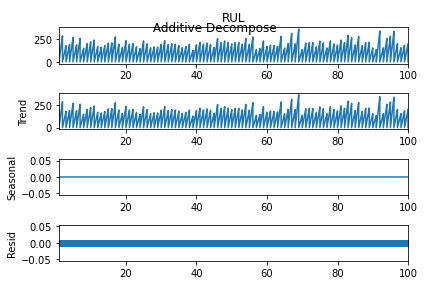

In [26]:
add_result.plot().suptitle('\n Additive Decompose',fontsize=12)
plt.show()

In [27]:
#additive
add=pd.concat([add_result.seasonal,add_result.trend,add_result.resid,add_result.observed],axis=1)
add.columns=['seasonality','trend','residual','actual_values']
add.head(200)

seasonality  trend  residual  actual_values
unit_number                                             
1                    0.0  191.0       0.0          191.0
1                    0.0  190.0       0.0          190.0
1                    0.0  189.0       0.0          189.0
1                    0.0  188.0       0.0          188.0
1                    0.0  187.0       0.0          187.0
...                  ...    ...       ...            ...
2                    0.0  283.0       0.0          283.0
2                    0.0  282.0       0.0          282.0
2                    0.0  281.0       0.0          281.0
2                    0.0  280.0       0.0          280.0
2                    0.0  279.0       0.0          279.0

[200 rows x 4 columns]

### Discovering Correlations 

<AxesSubplot:>

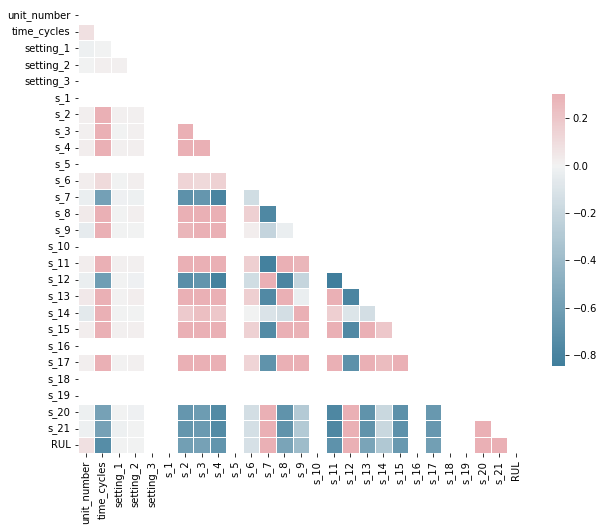

In [28]:
# Compute the correlation matrix
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(230, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

We notice that some features of our data-set are highly correlated with the target value RUL, other features present a low correlation which will be dropped later.

### Questions to answer : 

- Can we efficiently predict the remaining useful time for the engine (error significance) ?
- Which features are the most important for predicting the failure of the turbofan engine ?
- Does adding historical data improve our model ? 
- Is the collected data sufficient enough to give an accurate prediction ?
- How can we turn our problem to a classification one ?


First, let us match each sensor with its real signification

In [29]:
Sensor_dictionary={}
dict_list=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
i=1
for x in dict_list :
    Sensor_dictionary['s_'+str(i)]=x
    i+=1
Sensor_dictionary

{'s_1': '(Fan inlet temperature) (◦R)',
 's_2': '(LPC outlet temperature) (◦R)',
 's_3': '(HPC outlet temperature) (◦R)',
 's_4': '(LPT outlet temperature) (◦R)',
 's_5': '(Fan inlet Pressure) (psia)',
 's_6': '(bypass-duct pressure) (psia)',
 's_7': '(HPC outlet pressure) (psia)',
 's_8': '(Physical fan speed) (rpm)',
 's_9': '(Physical core speed) (rpm)',
 's_10': '(Engine pressure ratio(P50/P2)',
 's_11': '(HPC outlet Static pressure) (psia)',
 's_12': '(Ratio of fuel flow to Ps30) (pps/psia)',
 's_13': '(Corrected fan speed) (rpm)',
 's_14': '(Corrected core speed) (rpm)',
 's_15': '(Bypass Ratio) ',
 's_16': '(Burner fuel-air ratio)',
 's_17': '(Bleed Enthalpy)',
 's_18': '(Required fan speed)',
 's_19': '(Required fan conversion speed)',
 's_20': '(High-pressure turbines Cool air flow)',
 's_21': '(Low-pressure turbines Cool air flow)'}

A **low pressure compressor (LPC**) and **high pressure compressor 
(HPC**) supply compressed high temperature, high pressure gases to the combustor.
**Low pressure turbine (LPT)** can decelerate and pressurize air to improve the chemical energy 
conversion efficiency of aviation kerosene.
**High pressure turbines (HPT)** generate mechanical energy by using high temperature and high pressure gas strike turbine blades. 
**Low-pressure rotor (N1), high-pressure rotor (N2), and nozzle** guarantee the combustion 
efficiency of the engine.

#### Plotting the evolution of features (sensors) along with the evolution with RUL

In [30]:
def plot_signal(df, Sensor_dic, signal_name):
    plt.figure(figsize=(13,5))
    for i in df['unit_number'].unique():
        if (i % 10 == 0):   #For a better visualisation, we plot the sensors signals of 20 units only
            plt.plot('RUL', signal_name, data=df[df['unit_number']==i].rolling(10).mean())

    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 300, 25))
    plt.ylabel(Sensor_dic[signal_name])
    plt.xlabel('Remaining Useful Life')
    plt.show()


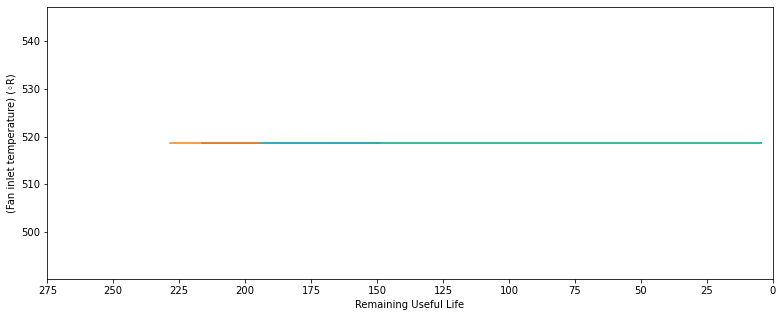

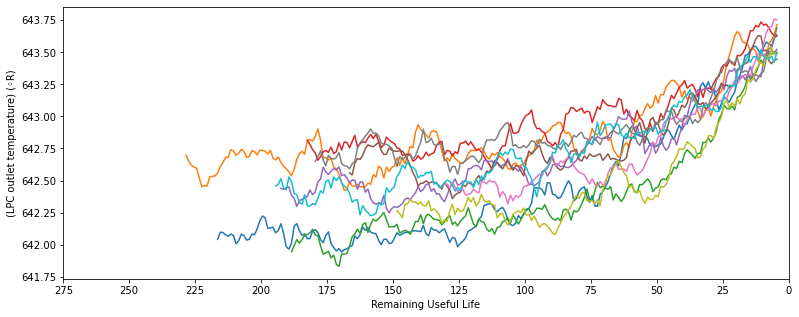

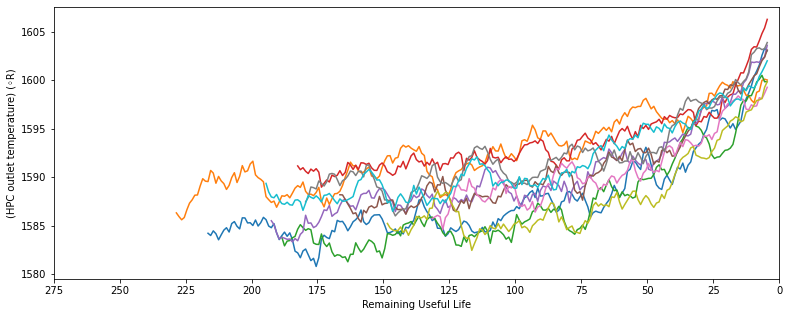

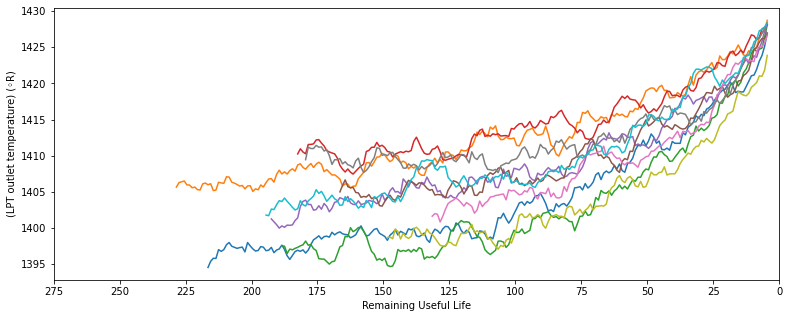

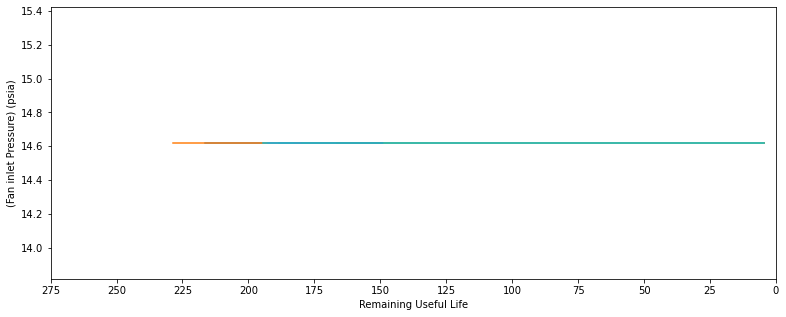

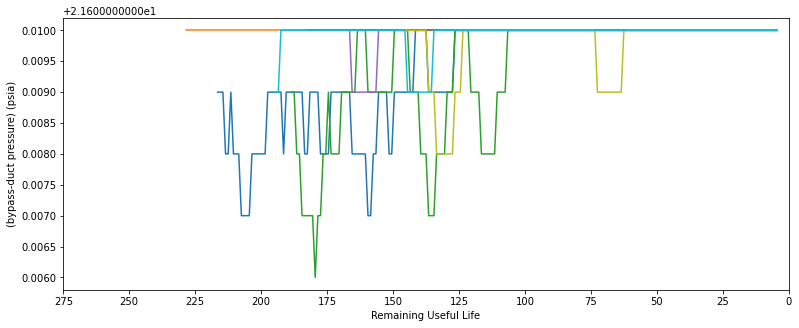

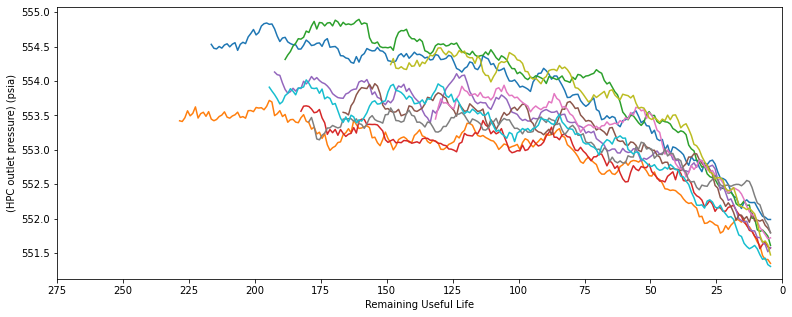

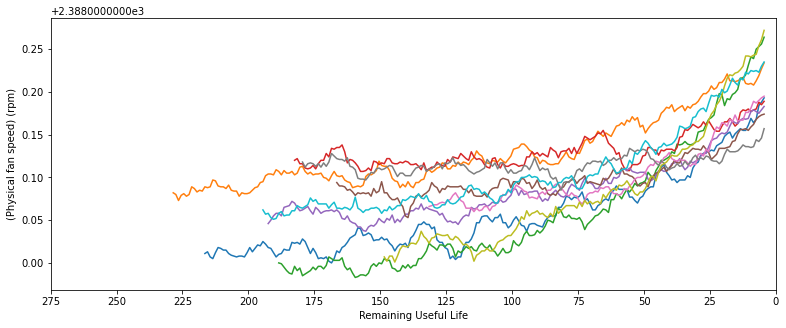

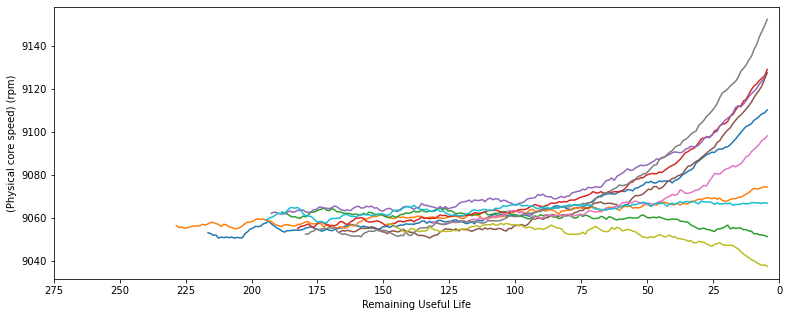

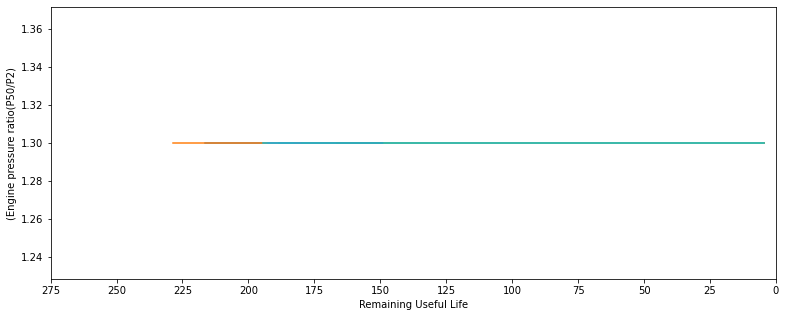

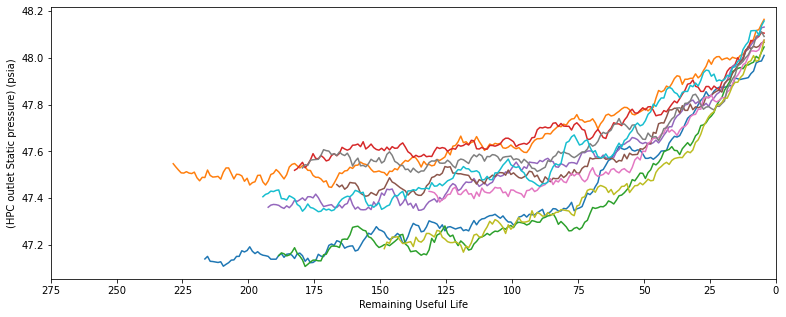

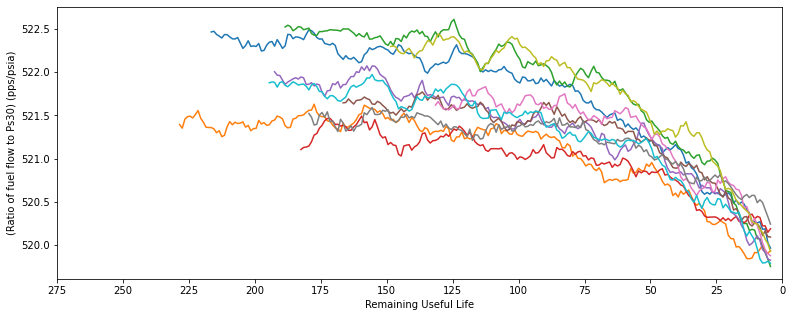

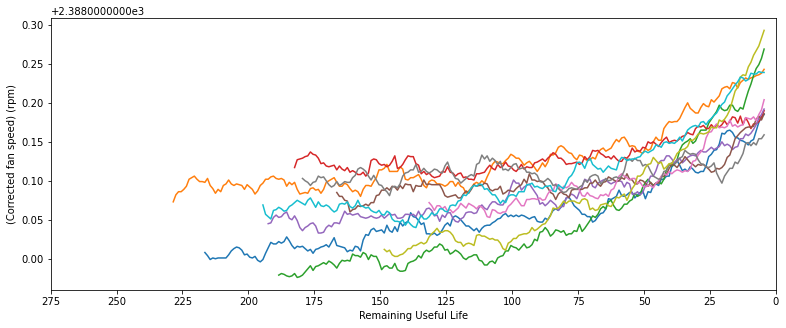

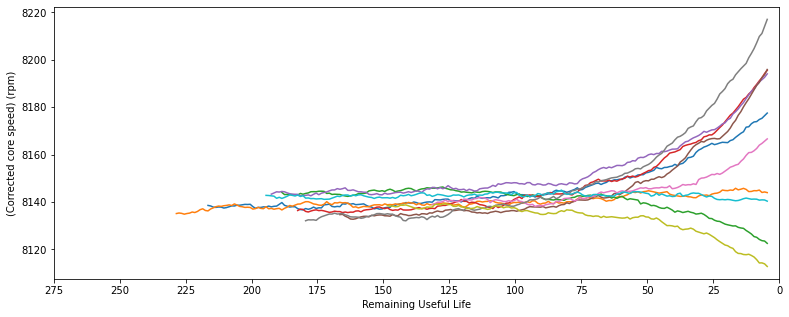

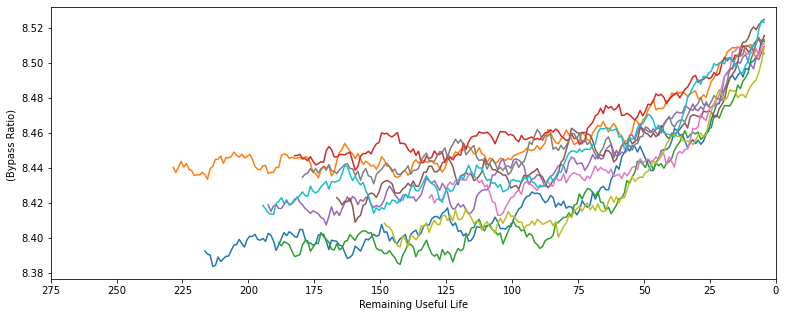

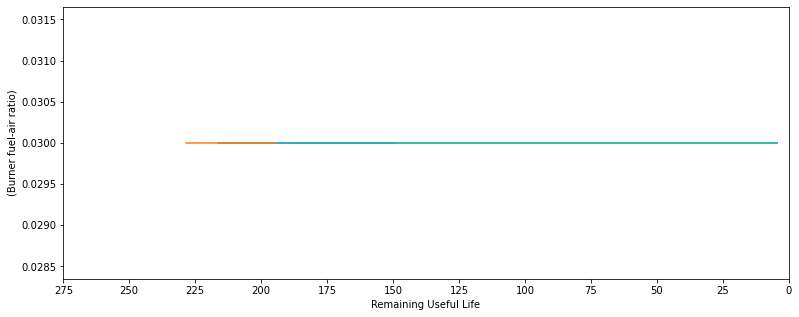

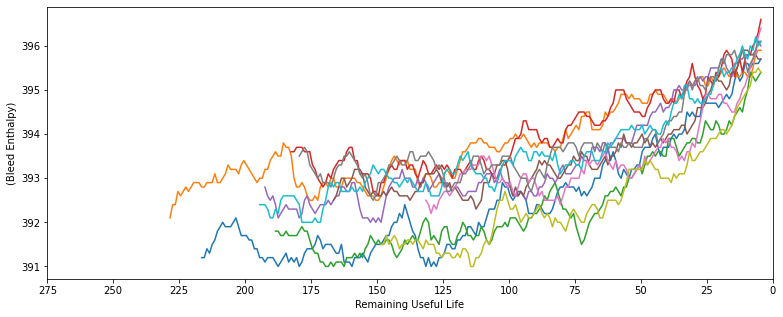

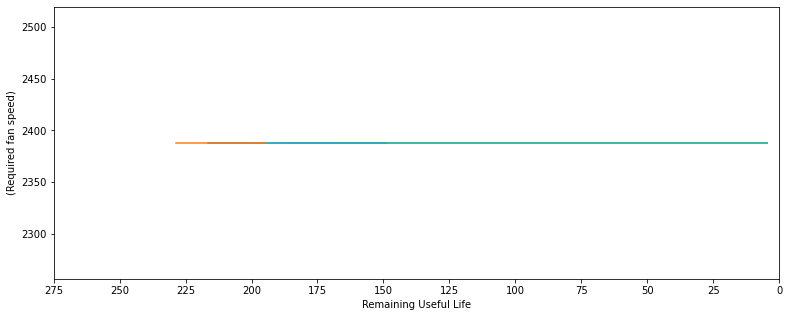

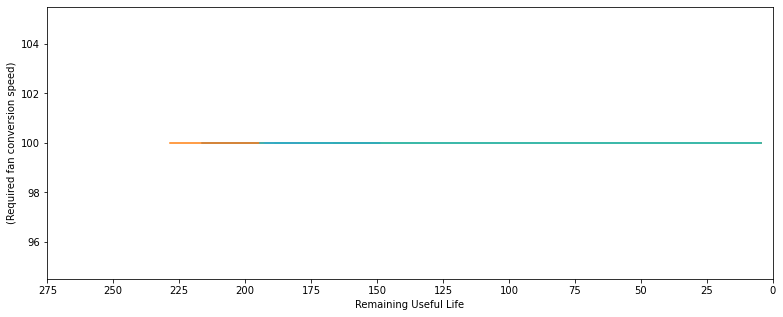

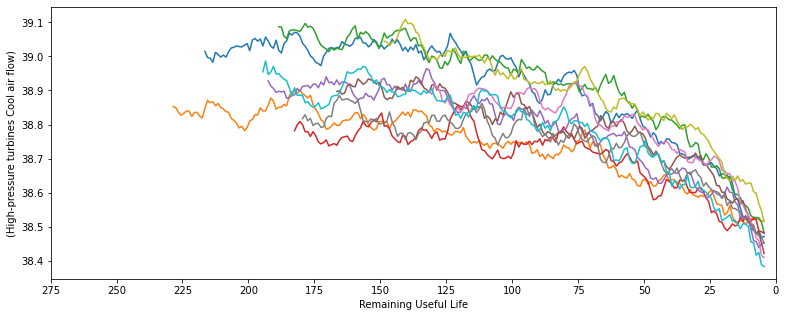

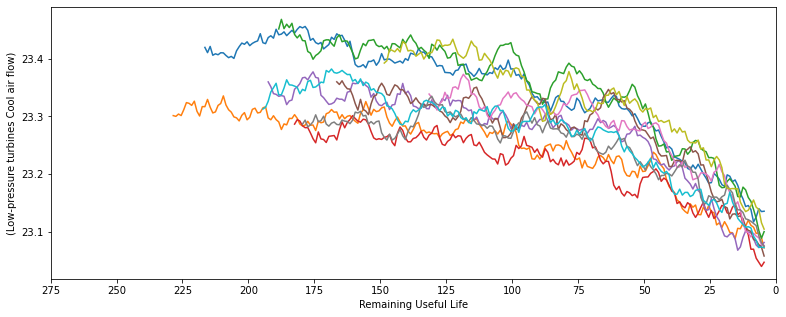

In [31]:
for i in range(1,22):
    try:
        plot_signal(train, Sensor_dictionary,'s_'+str(i))
    except:
        pass

These plots show that some sensors are constant. Hence they don't influence the RUL ==> we can drop those ones. (later)

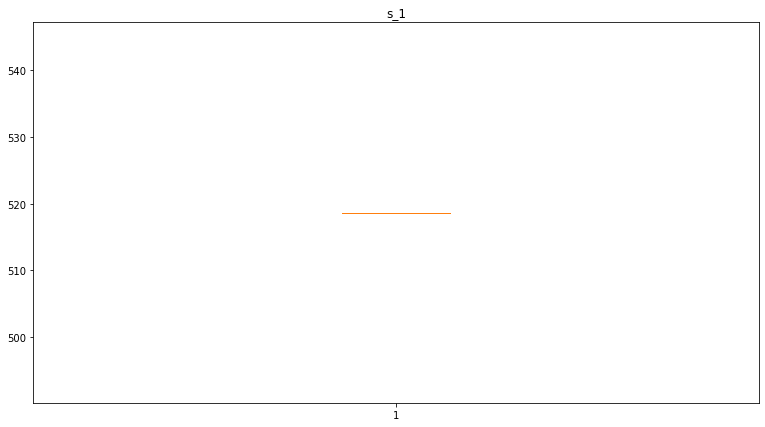

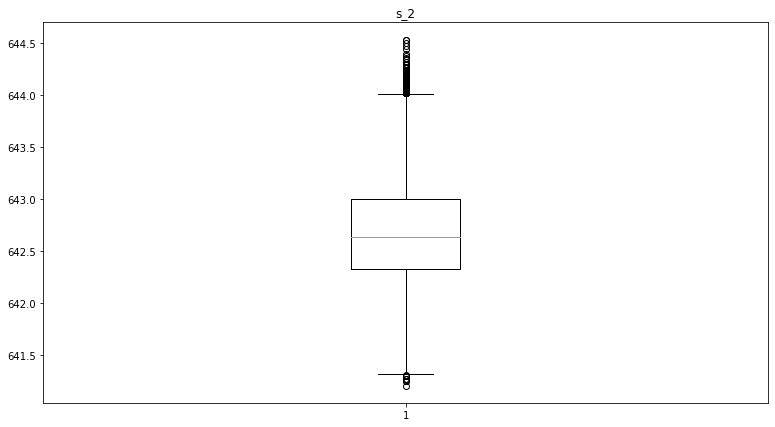

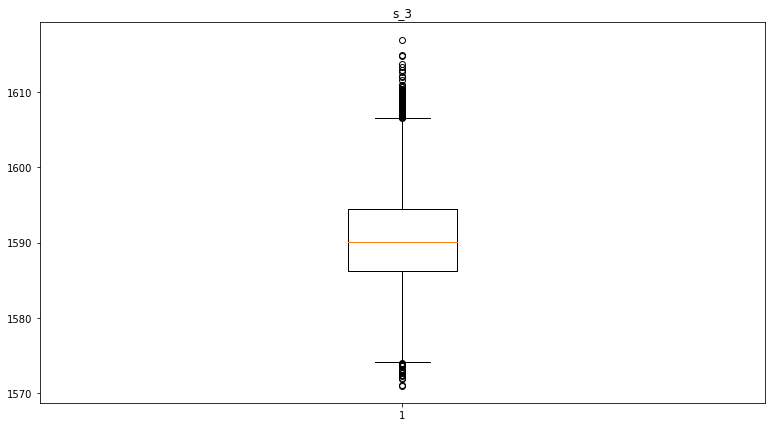

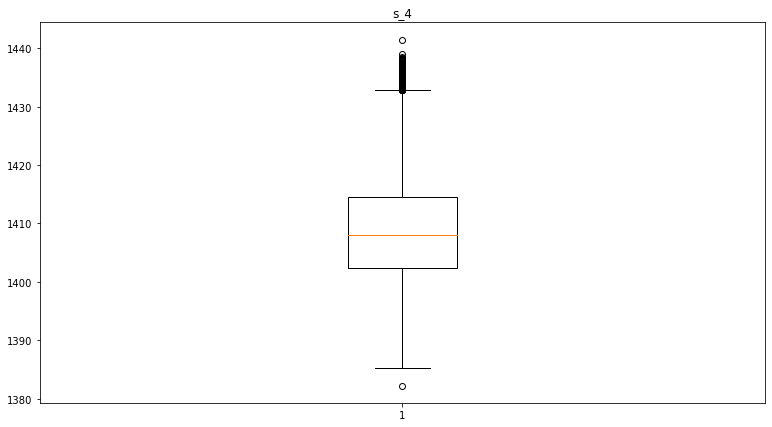

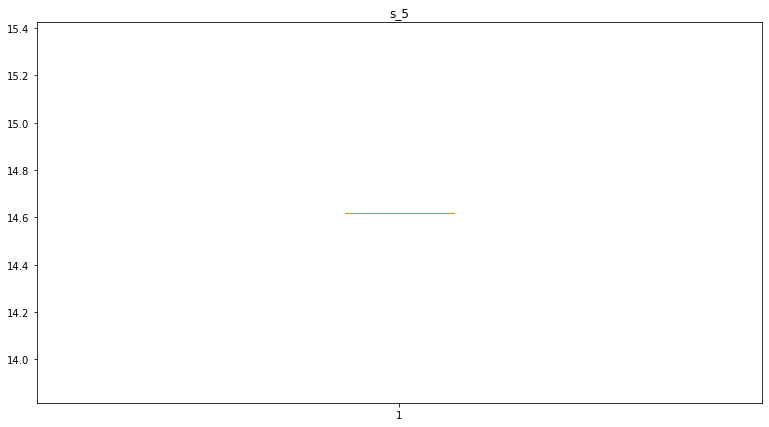

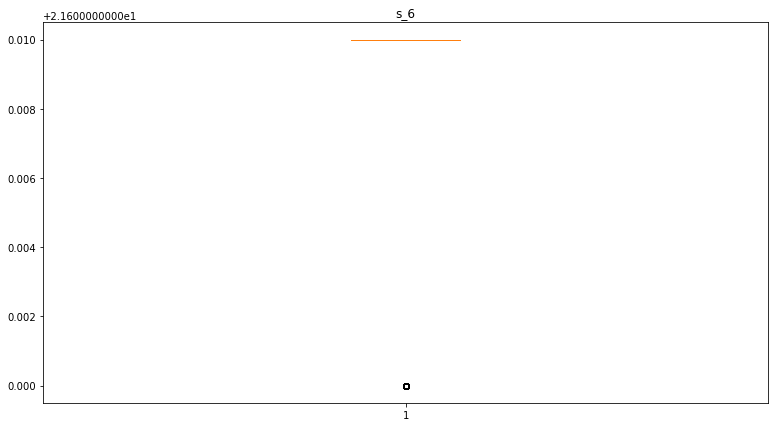

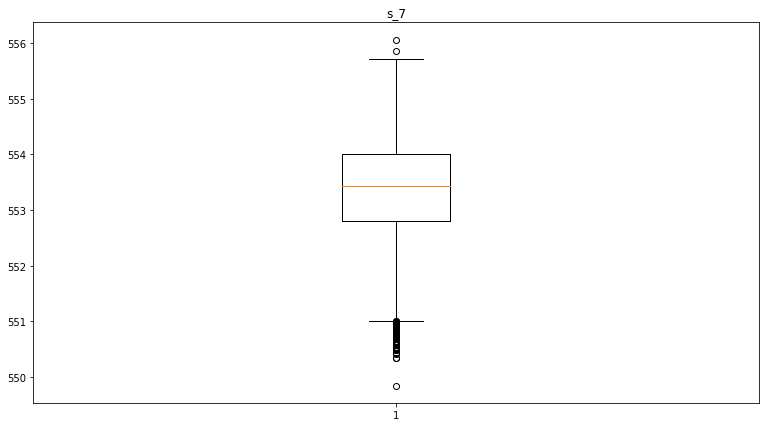

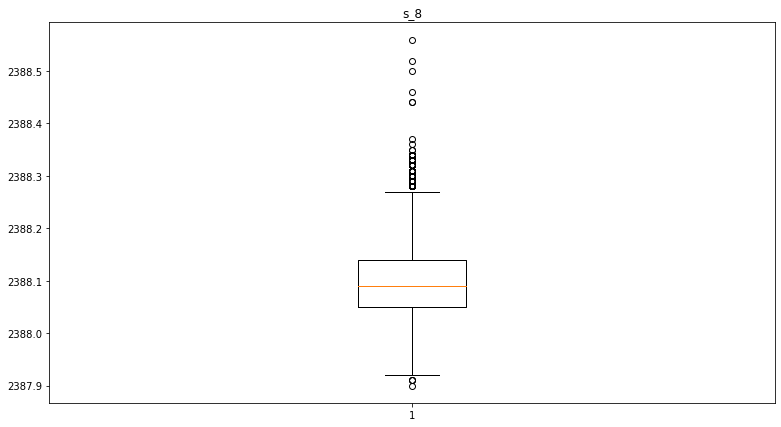

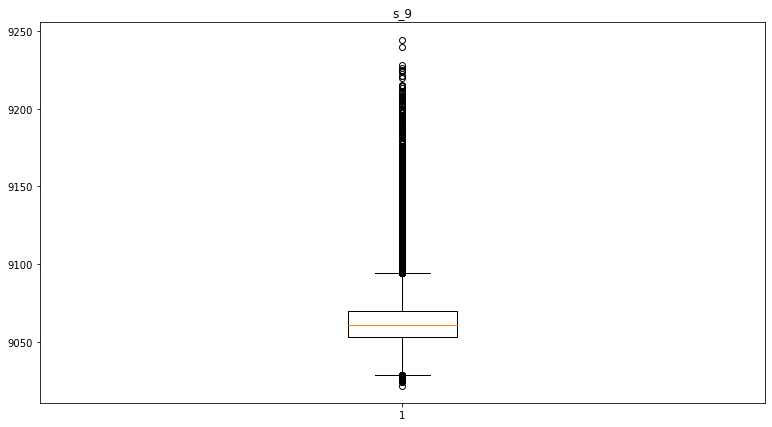

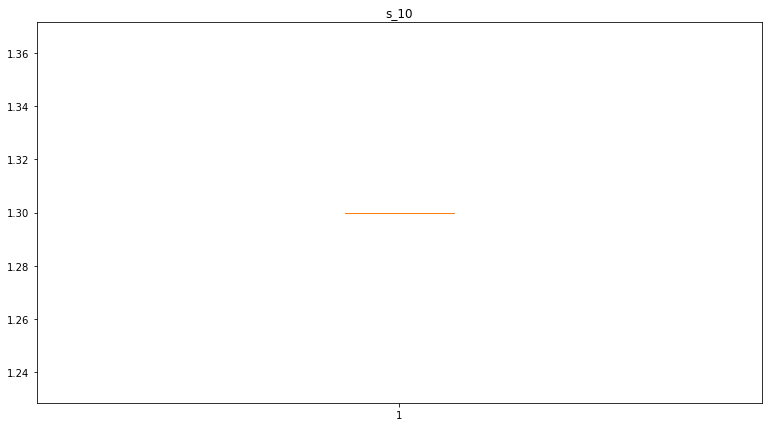

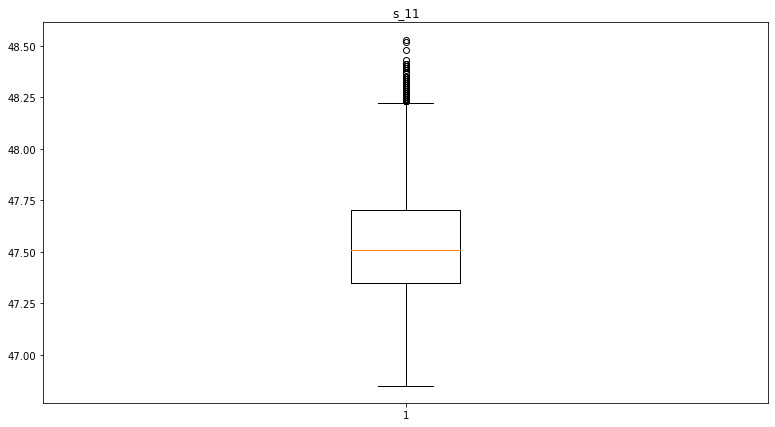

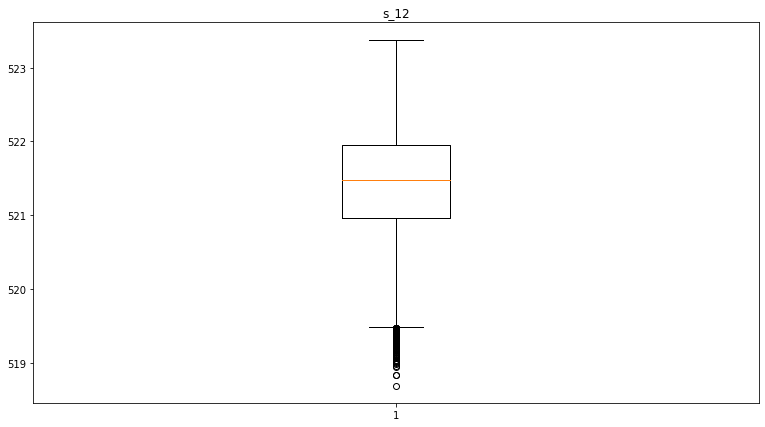

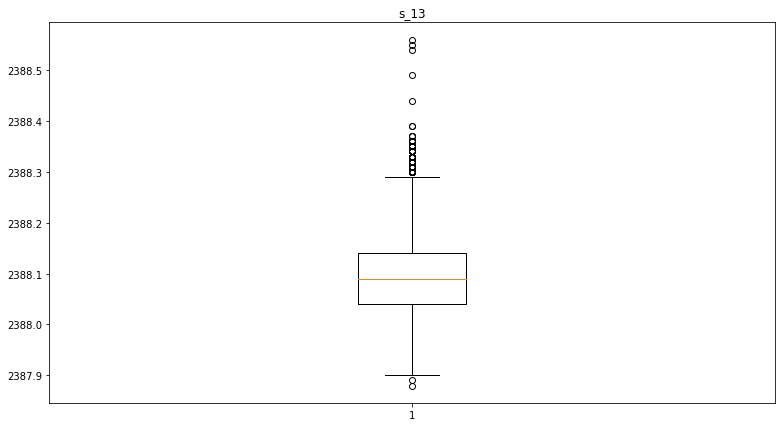

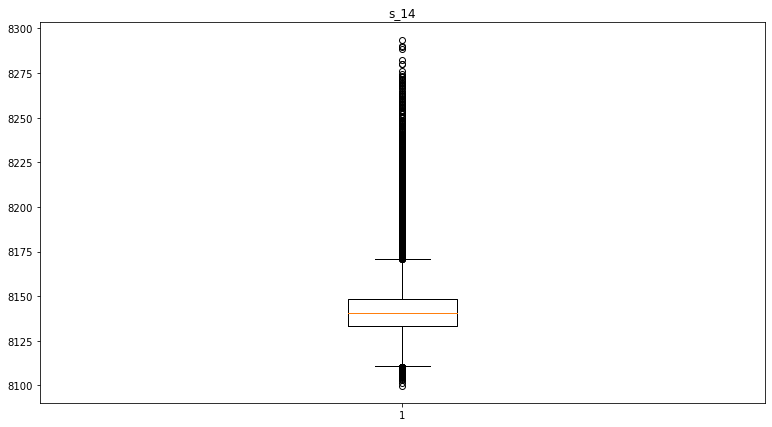

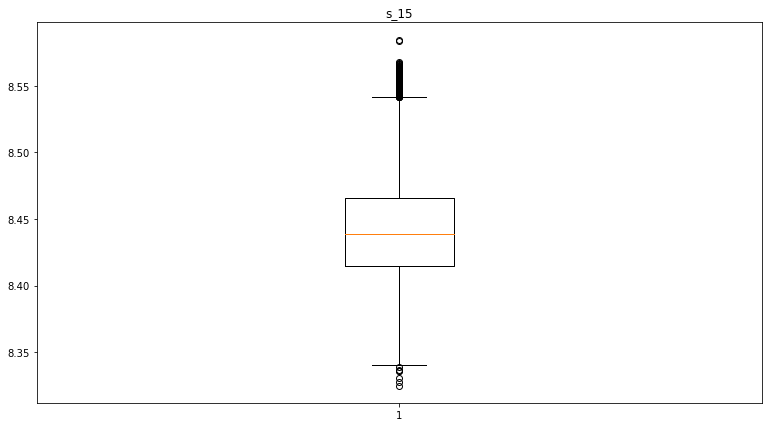

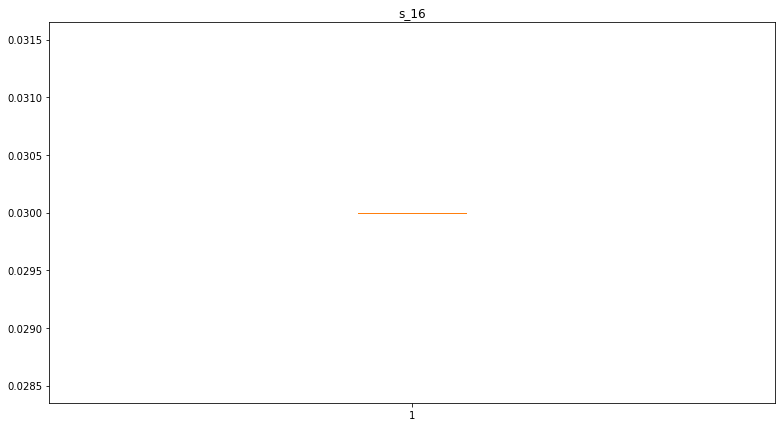

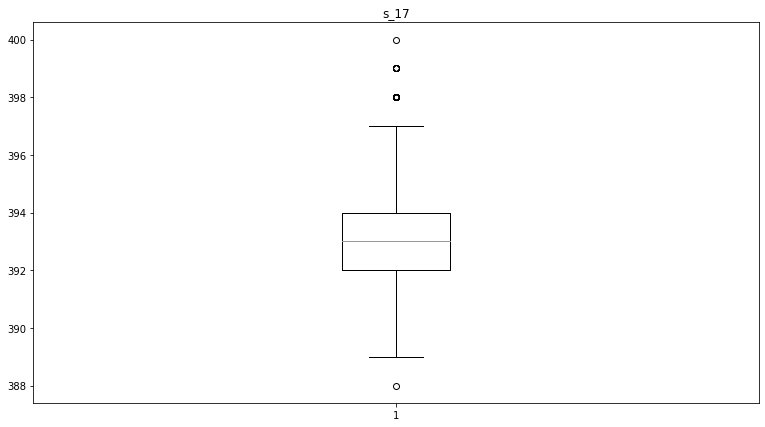

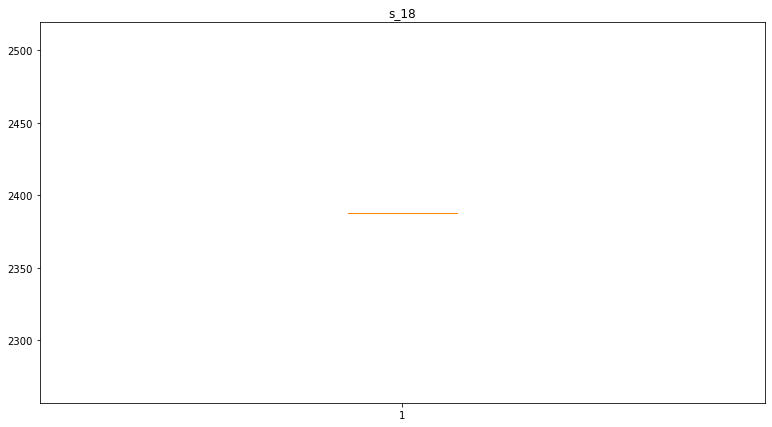

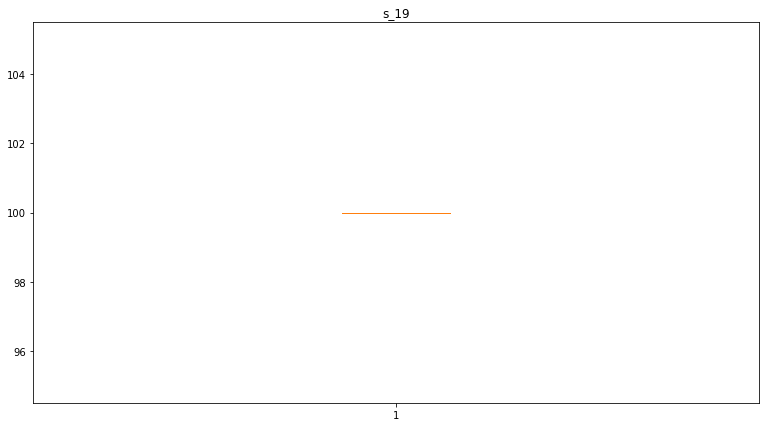

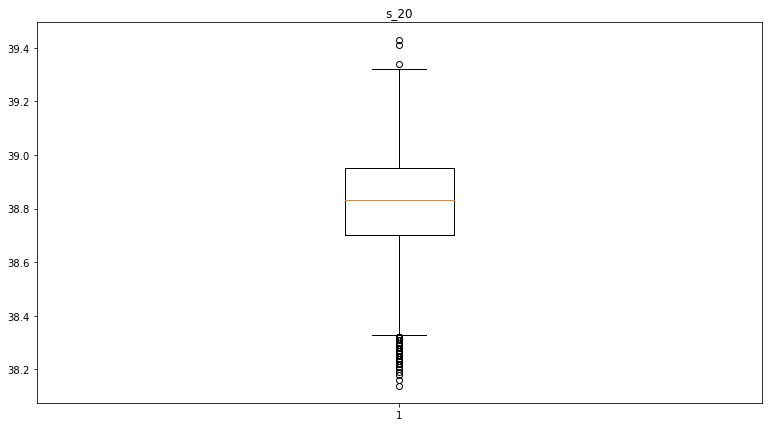

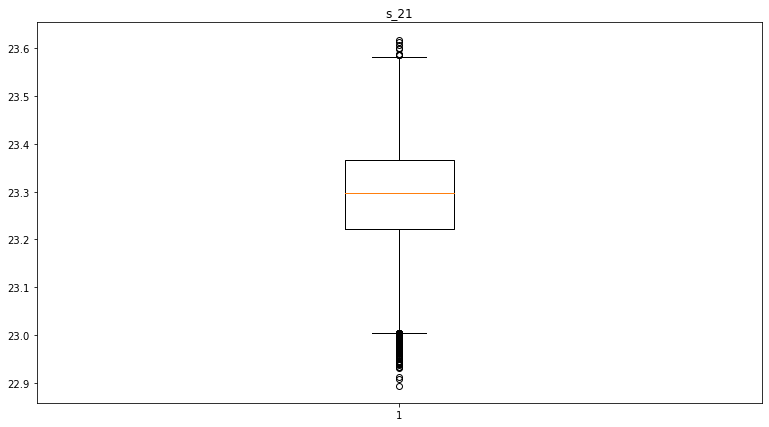

In [32]:
for x in sensor_names:
    plt.figure(figsize=(13,7))
    plt.boxplot(train[x])
    plt.title(x)
    plt.show()

Observing the signal plots and the boxplots, we notice that the sensors 1,5,10,16,18,19 are constant, furthermore, we observe that the other sensors aren't well distributed and there are many outliers, then we should scale our data 

In [33]:
train.loc[:,'s_1':].describe().transpose()

count         mean           std        min        25%        50%  \
s_1   20631.0   518.670000  6.537152e-11   518.6700   518.6700   518.6700   
s_2   20631.0   642.680934  5.000533e-01   641.2100   642.3250   642.6400   
s_3   20631.0  1590.523119  6.131150e+00  1571.0400  1586.2600  1590.1000   
s_4   20631.0  1408.933782  9.000605e+00  1382.2500  1402.3600  1408.0400   
s_5   20631.0    14.620000  3.394700e-12    14.6200    14.6200    14.6200   
s_6   20631.0    21.609803  1.388985e-03    21.6000    21.6100    21.6100   
s_7   20631.0   553.367711  8.850923e-01   549.8500   552.8100   553.4400   
s_8   20631.0  2388.096652  7.098548e-02  2387.9000  2388.0500  2388.0900   
s_9   20631.0  9065.242941  2.208288e+01  9021.7300  9053.1000  9060.6600   
s_10  20631.0     1.300000  4.660829e-13     1.3000     1.3000     1.3000   
s_11  20631.0    47.541168  2.670874e-01    46.8500    47.3500    47.5100   
s_12  20631.0   521.413470  7.375534e-01   518.6900   520.9600   521.4800   
s_13  20631.0  2388.096152  7.191892e-02  2387.8800  2388.0400  2388.0900   
s_14  20631.0  8143.752722  1.907618e+01  8099.9400  8133.2450  8140.5400   
s_15  20631.0     8.442146  3.750504e-02     8.3249     8.4149     8.4389   
s_16  20631.0     0.030000  1.556432e-14     0.0300     0.0300     0.0300   
s_17  20631.0   393.210654  1.548763e+00   388.0000   392.0000   393.0000   
s_18  20631.0  2388.000000  0.000000e+00  2388.0000  2388.0000  2388.0000   
s_19  20631.0   100.000000  0.000000e+00   100.0000   100.0000   100.0000   
s_20  20631.0    38.816271  1.807464e-01    38.1400    38.7000    38.8300   
s_21  20631.0    23.289705  1.082509e-01    22.8942    23.2218    23.2979   
RUL   20631.0   107.807862  6.888099e+01     0.0000    51.0000   103.0000   

            75%        max  
s_1    518.6700   518.6700  
s_2    643.0000   644.5300  
s_3   1594.3800  1616.9100  
s_4   1414.5550  1441.4900  
s_5     14.6200    14.6200  
s_6     21.6100    21.6100  
s_7    554.0100   556.0600  
s_8   2388.1400  2388.5600  
s_9   9069.4200  9244.5900  
s_10     1.3000     1.3000  
s_11    47.7000    48.5300  
s_12   521.9500   523.3800  
s_13  2388.1400  2388.5600  
s_14  8148.3100  8293.7200  
s_15     8.4656     8.5848  
s_16     0.0300     0.0300  
s_17   394.0000   400.0000  
s_18  2388.0000  2388.0000  
s_19   100.0000   100.0000  
s_20    38.9500    39.4300  
s_21    23.3668    23.6184  
RUL    155.0000   361.0000

 The last point is more supported by the fact that the statistic properties of sensors data show that they don't have the same scale and they don't follow a normal distribution ==> this can be solved by performing a Minmax scaler on our data.

**MinMax scaler function** :Transform features by scaling each feature to a given range.

This estimator scales and translates each feature individually such that it is in the given range on the training set
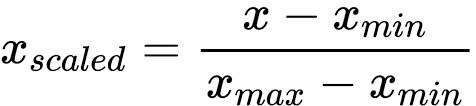!

##### Dropping unnecessary features (labels and settings)

In [34]:
from sklearn.model_selection import train_test_split
drop_labels = index_names+setting_names
X_train=train.drop(columns=drop_labels).copy()
X_train, X_test, y_train, y_test=train_test_split(X_train,X_train['RUL'], test_size=0.3, random_state=42)

##### Scaling the data

In [35]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#Droping the target variable
X_train.drop(columns=['RUL'], inplace=True)
X_test.drop(columns=['RUL'], inplace=True)
#Scaling X_train and X_test
X_train_s=scaler.fit_transform(X_train)
X_test_s=scaler.fit_transform(X_test)
#Conserve only the last occurence of each unit to match the length of y_valid
X_valid = valid.groupby('unit_number').last().reset_index().drop(columns=drop_labels)
#scaling X_valid
X_valid_s=scaler.fit_transform(X_valid)


In [36]:
print(X_valid_s.shape)
print(y_valid.shape)

(100, 21)
(100, 1)


In [37]:
X_valid.head()

s_1     s_2      s_3      s_4    s_5    s_6     s_7      s_8      s_9  \
0  518.67  642.58  1581.22  1398.91  14.62  21.61  554.42  2388.08  9056.40   
1  518.67  642.55  1586.59  1410.83  14.62  21.61  553.52  2388.10  9044.77   
2  518.67  642.88  1589.75  1418.89  14.62  21.61  552.59  2388.16  9049.26   
3  518.67  642.78  1594.53  1406.88  14.62  21.61  552.64  2388.13  9051.30   
4  518.67  642.27  1589.94  1419.36  14.62  21.61  553.29  2388.10  9053.99   

   s_10  ...    s_12     s_13     s_14    s_15  s_16  s_17  s_18   s_19  \
0   1.3  ...  521.79  2388.06  8130.11  8.4024  0.03   393  2388  100.0   
1   1.3  ...  521.74  2388.09  8126.90  8.4505  0.03   391  2388  100.0   
2   1.3  ...  520.83  2388.14  8131.46  8.4119  0.03   395  2388  100.0   
3   1.3  ...  521.88  2388.11  8133.64  8.4634  0.03   395  2388  100.0   
4   1.3  ...  521.00  2388.15  8125.74  8.4362  0.03   394  2388  100.0   

    s_20     s_21  
0  38.81  23.3552  
1  38.81  23.2618  
2  38.93  23.2740  
3  38.58  23.2581  
4  38.75  23.4117  

[5 rows x 21 columns]

In [38]:
X_train.head()

s_1     s_2      s_3      s_4    s_5    s_6     s_7      s_8  \
12862  518.67  643.08  1592.07  1402.73  14.62  21.61  554.10  2388.09   
9936   518.67  642.21  1580.72  1394.09  14.62  21.61  553.34  2387.99   
12025  518.67  642.09  1586.25  1404.03  14.62  21.61  554.27  2388.06   
14526  518.67  643.52  1597.95  1423.87  14.62  21.61  552.22  2388.21   
16747  518.67  642.34  1586.62  1401.82  14.62  21.61  554.13  2388.06   

           s_9  s_10  ...    s_12     s_13     s_14    s_15  s_16  s_17  s_18  \
12862  9062.50   1.3  ...  521.78  2388.04  8133.34  8.4301  0.03   393  2388   
9936   9066.77   1.3  ...  522.67  2388.03  8144.06  8.3837  0.03   392  2388   
12025  9061.07   1.3  ...  521.70  2388.01  8139.32  8.4244  0.03   391  2388   
14526  9031.18   1.3  ...  520.08  2388.16  8109.80  8.4930  0.03   394  2388   
16747  9054.55   1.3  ...  522.24  2388.03  8128.29  8.4081  0.03   392  2388   

        s_19   s_20     s_21  
12862  100.0  38.67  23.3724  
9936   100.0  39.08  23.3686  
12025  100.0  38.96  23.3025  
14526  100.0  38.54  23.1882  
16747  100.0  39.08  23.4485  

[5 rows x 21 columns]

In [39]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14441 entries, 12862 to 15795
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   s_1     14441 non-null  float64
 1   s_2     14441 non-null  float64
 2   s_3     14441 non-null  float64
 3   s_4     14441 non-null  float64
 4   s_5     14441 non-null  float64
 5   s_6     14441 non-null  float64
 6   s_7     14441 non-null  float64
 7   s_8     14441 non-null  float64
 8   s_9     14441 non-null  float64
 9   s_10    14441 non-null  float64
 10  s_11    14441 non-null  float64
 11  s_12    14441 non-null  float64
 12  s_13    14441 non-null  float64
 13  s_14    14441 non-null  float64
 14  s_15    14441 non-null  float64
 15  s_16    14441 non-null  float64
 16  s_17    14441 non-null  int64  
 17  s_18    14441 non-null  int64  
 18  s_19    14441 non-null  float64
 19  s_20    14441 non-null  float64
 20  s_21    14441 non-null  float64
dtypes: float64(19), int64(2)
memory

#### plotting features new distribution

array([[<AxesSubplot:title={'center':'s_2'}>,
        <AxesSubplot:title={'center':'s_3'}>,
        <AxesSubplot:title={'center':'s_4'}>,
        <AxesSubplot:title={'center':'s_7'}>],
       [<AxesSubplot:title={'center':'s_8'}>,
        <AxesSubplot:title={'center':'s_9'}>,
        <AxesSubplot:title={'center':'s_11'}>,
        <AxesSubplot:title={'center':'s_12'}>],
       [<AxesSubplot:title={'center':'s_13'}>,
        <AxesSubplot:title={'center':'s_14'}>,
        <AxesSubplot:title={'center':'s_15'}>,
        <AxesSubplot:title={'center':'s_17'}>],
       [<AxesSubplot:title={'center':'s_20'}>,
        <AxesSubplot:title={'center':'s_21'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

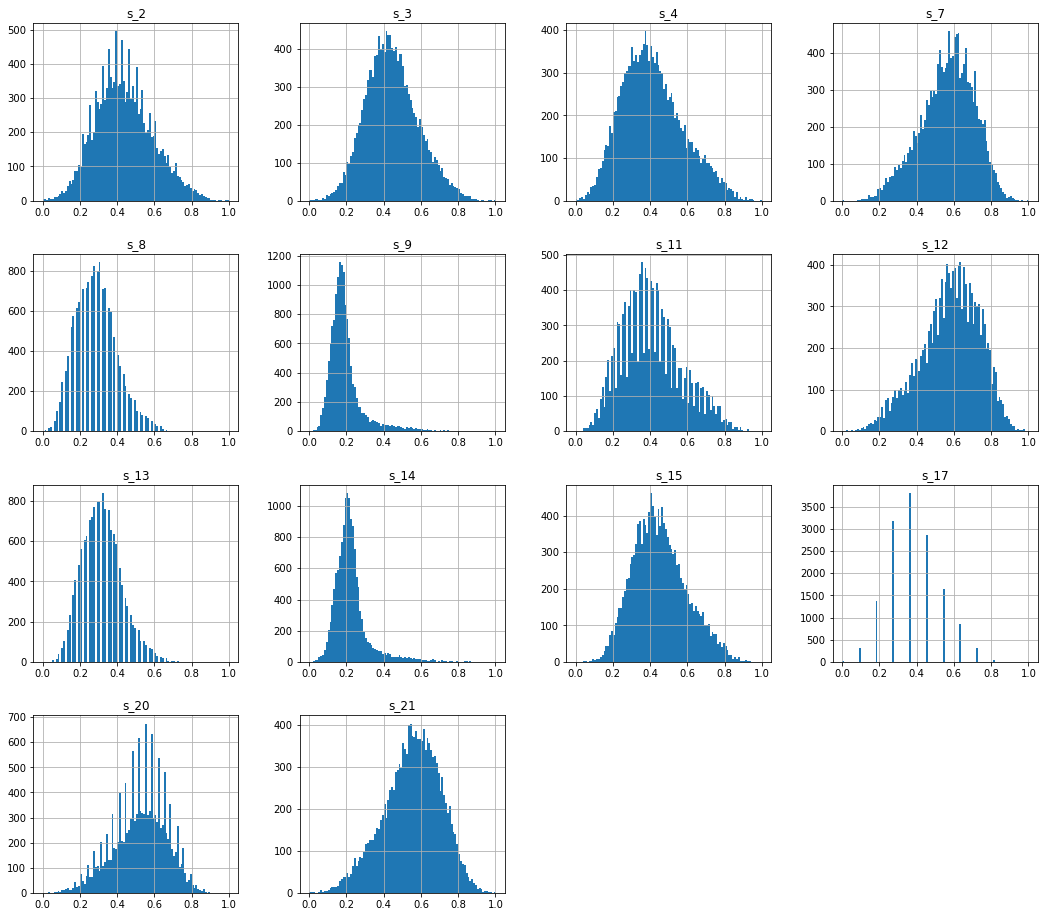

In [40]:
sensor_names=['s_{}'.format(i) for i in range(1,22) if i not in [1,5,6,10,16,18,19]]
pd.DataFrame(X_train_s,columns=['s_{}'.format(i) for i in range(1,22)])[sensor_names].hist(bins=100, figsize=(18,16))

## Models Implementation and instantiation

#### Linear regression

In [41]:
class Linear_Regression() :
    def __init__( self, lr=0.01, iterations=150 ) :    
        self.lr = lr
        self.iterations = iterations     
    def fit( self, X, Y ) :
        self.l, self.p = X.shape
        # weight initializer
        self.W = np.zeros( self.p )
        self.b = 0
        self.X = X
        self.Y = Y
        # gradientlearning      
        for i in range( self.iterations ) :  
            self.weight_updater()
        return self
         
    def weight_updater( self ) :
        Y_pred = self.predict( self.X )  
        #  gradients  
        dW = - ( 2 * ( self.X.T ).dot( self.Y - Y_pred )  ) / self.l
        db = - 2 * np.sum( self.Y - Y_pred ) / self.l
        # new weights assigned
        self.b = self.b - self.lr * db
        self.W = self.W - self.lr * dW
        return self
          
    def predict( self, X ) :
          # Y_pr=X.W+b
        return X.dot( self.W ) + self.b
     
  

#### SVR

In [42]:
from sklearn.svm import SVR
#import tensorflow as tf
regressor = SVR(kernel='rbf')

#### Random forest

In [43]:
rf = RandomForestRegressor(max_features="sqrt", random_state=42)


### Defining evaluation functions

In [44]:
#R2 score & RMSE & MAER
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [45]:
#plot real data and the predicted one to make some comparison
def plot_predActual(y_test, y_test_hat):
  
    indices = np.arange(len(y_test_hat))
    wth= 0.6
    plt.figure(figsize=(70,30))
    true_values = [int(x) for x in y_test.values]
    predicted_values = list(y_test_hat)

    plt.bar(indices, true_values, width=wth,color='b', label='True RUL')
    plt.bar([i for i in indices], predicted_values, width=0.5*wth, color='r', alpha=0.7, label='Predicted RUL')

    plt.legend(prop={'size': 40})
    plt.tick_params(labelsize=40)

    plt.show()

### 1st attempt (all features, without historical data)

#### Linear regresssion

In [46]:
lr=Linear_Regression() #Instantiation
lr.fit(X=X_train_s, Y=y_train) #Fitting 

y_lr_train = lr.predict(X_train_s) #Prediction on train data
evaluate(y_train,y_lr_train, label='train')

y_lr_test = lr.predict(X_test_s)  #Prediction on test data
evaluate(y_test, y_lr_test, label='test')

y_lr_valid= lr.predict(X_valid_s) #Prediction on validation data
evaluate(y_valid, y_lr_valid, label='valid')

train set RMSE:56.19869318681088, R2:0.3439361345919162
test set RMSE:54.264009074691856, R2:0.35713062175493715
valid set RMSE:34.84962228223509, R2:0.2967064952591343


In [47]:
X_train_s

array([[0.        , 0.55792683, 0.47915243, ..., 0.        , 0.41085271,
        0.67144061],
       [0.        , 0.29268293, 0.22055138, ..., 0.        , 0.72868217,
        0.66610503],
       [0.        , 0.25609756, 0.34654819, ..., 0.        , 0.63565891,
        0.57329402],
       ...,
       [0.        , 0.38109756, 0.68056505, ..., 0.        , 0.47286822,
        0.64855378],
       [0.        , 0.20731707, 0.15926179, ..., 0.        , 0.72093023,
        0.6727043 ],
       [0.        , 0.2804878 , 0.4456596 , ..., 0.        , 0.79069767,
        0.71889919]])

In [48]:
y_lr_train

array([113.61361505, 131.52427247, 121.75451001, ..., 111.14444614,
       133.17659418, 132.81632325])

### SVR

In [49]:
regressor.fit(X_train_s, y_train) # fitting

y_svr_train = regressor.predict(X_train_s) #Prediction on train data
evaluate(y_train,y_svr_train, label='train')

y_svr_test = regressor.predict(X_test_s) #Prediction on test data
evaluate(y_test, y_svr_test, label='test')

y_svr_valid= lr.predict(X_valid_s)  #Prediction on validation data
evaluate(y_valid, y_svr_valid, label='valid')

train set RMSE:43.56448464126648, R2:0.605761670162996
test set RMSE:47.26718449996111, R2:0.5122262167433573
valid set RMSE:34.84962228223509, R2:0.2967064952591343


#### Random forest regressor

In [50]:
# gridsearch goes here
rf.fit(X_train_s, y_train)
# predict and evaluate
y_rf_train = rf.predict(X_train_s)
evaluate(y_train,y_rf_train, label='train')

y_rf_test = rf.predict(X_test_s)
evaluate(y_test, y_rf_test, label='test')

y_rf_valid = rf.predict(X_valid_s)
evaluate(y_valid, y_rf_valid, label='valid')

train set RMSE:15.408303170220156, R2:0.9506822432050425
test set RMSE:44.36383009860364, R2:0.5703082128383993
valid set RMSE:30.653618024631285, R2:0.45586841183607596


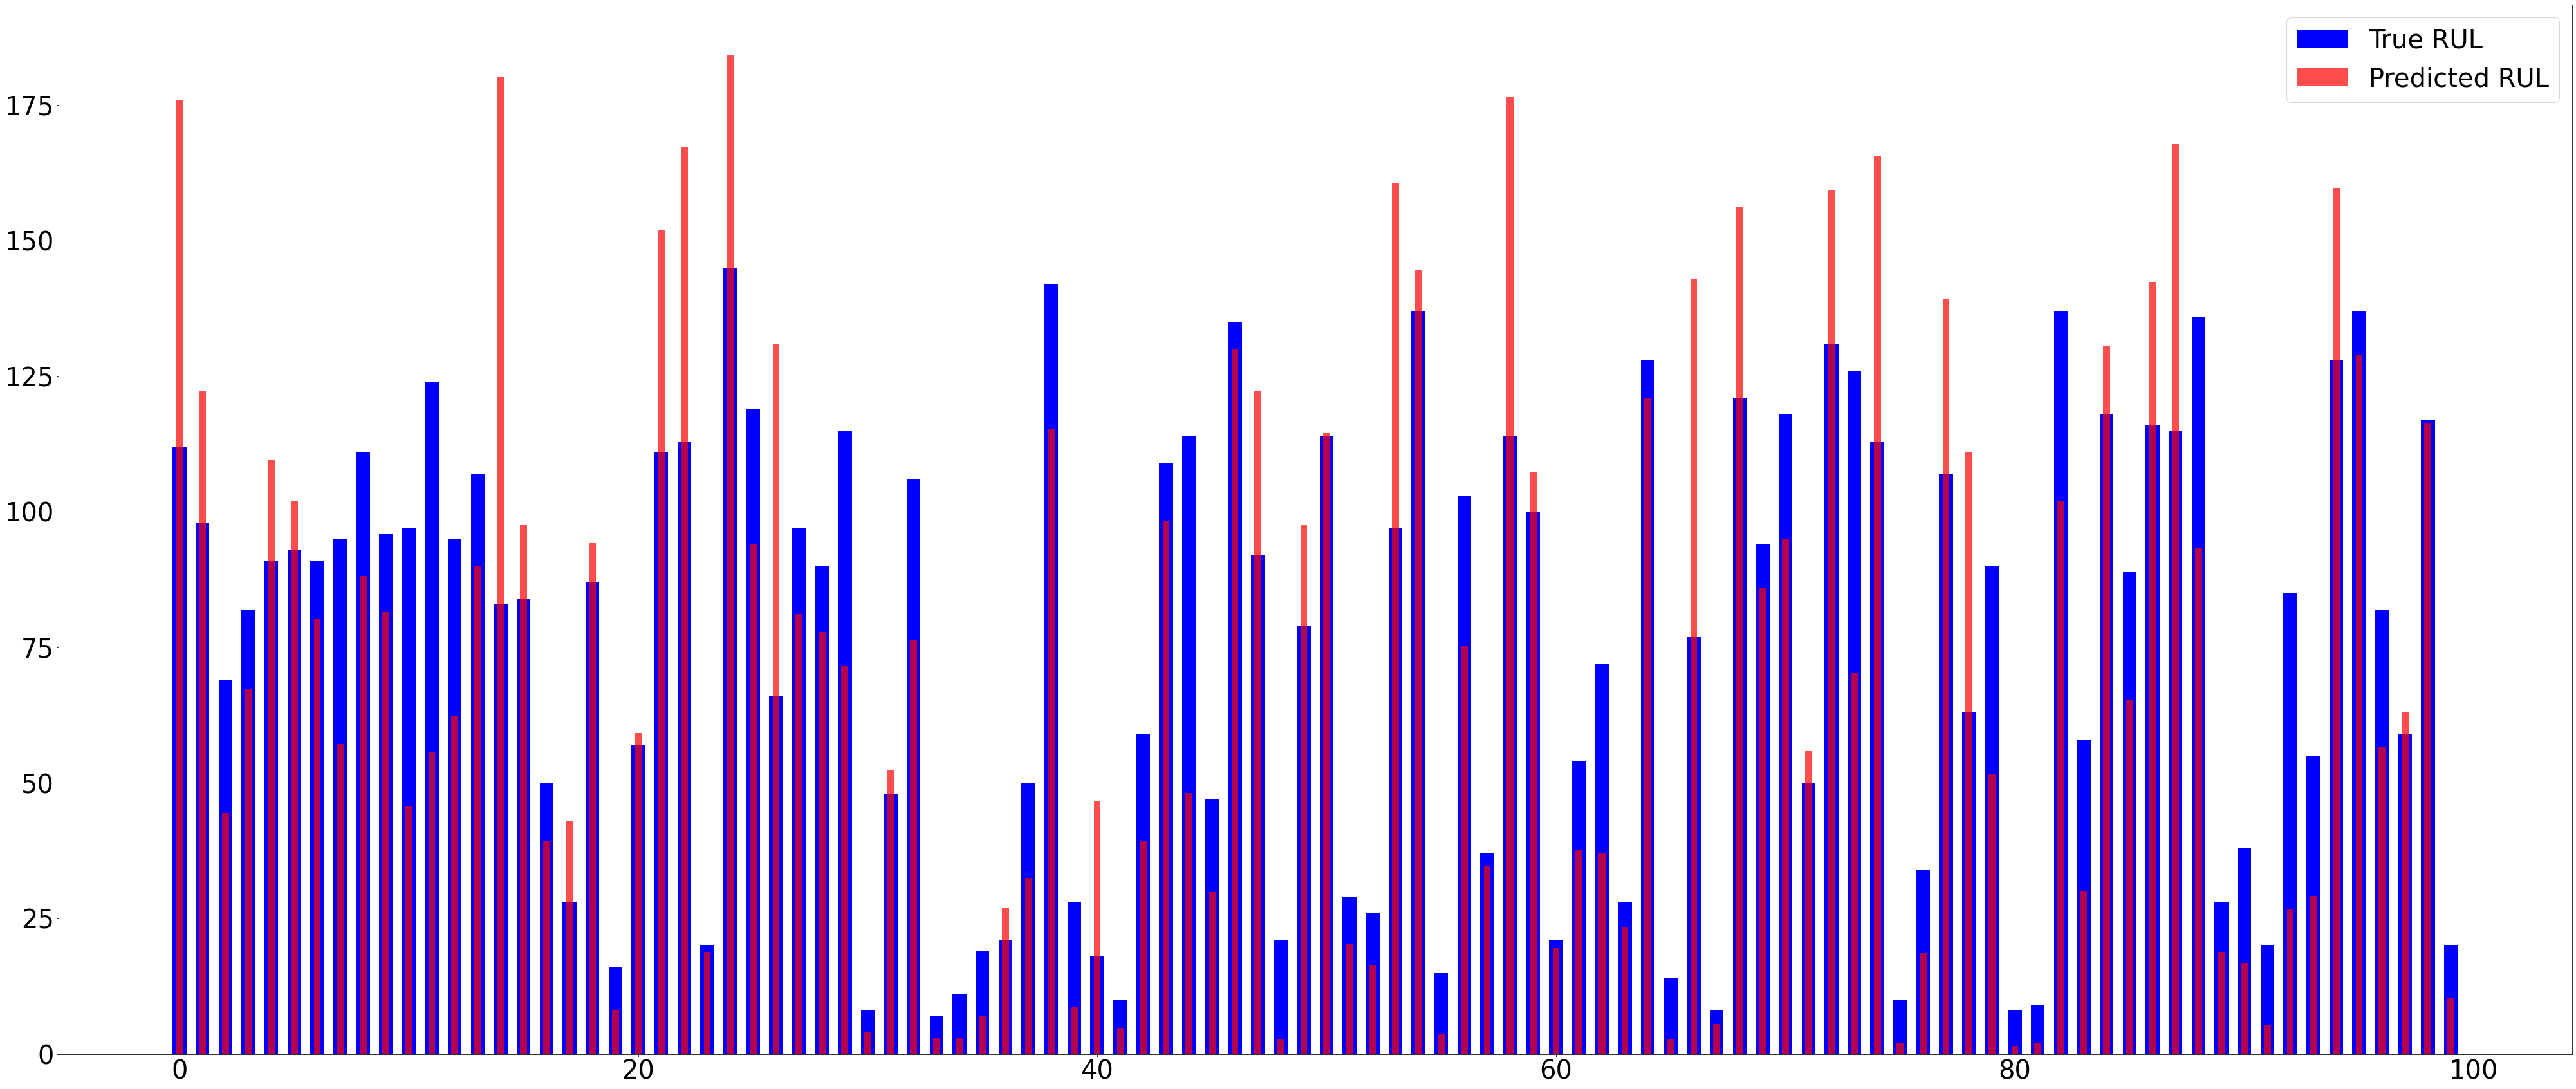

In [51]:
plot_predActual(y_valid, y_rf_valid)

We notice that the model overestimates the RUL 

### 2nd attempt (Data without useless sensors, without historical data)

In  this section we drop constant signals, and we noticed in the max_time_cycles plot that in most of the time the maximum value is in the interval [190,210], hence we will set the maximum RUL to 195 through RUL clipping,

Considering that every RUL higher than 195 is equivalent to 195 will help in the prediction process as it reduces some overhead without affecting the main objective as 195 is already a high RUL.

In [52]:
print('maximum of y_train : ',y_train.max())
print('maximum of y_test : ',y_test.max())
print('maximum of y_valid : ',y_valid.max())

maximum of y_train :  361
maximum of y_test :  360
maximum of y_valid :  RUL    145
dtype: int64


(array([1023., 1066., 1083., 1120.,  937.,  557.,  237.,  117.,   35.,
          15.]),
 array([  0.,  36.,  72., 108., 144., 180., 216., 252., 288., 324., 360.]),
 <BarContainer object of 10 artists>)

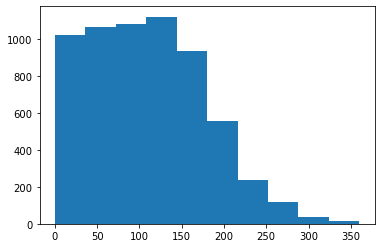

In [53]:
plt.hist(y_test)

In [54]:
drop_labels2=['s_1', 's_5','s_6','s_10',  's_16', 's_18', 's_19']
X_train_2=X_train.drop(columns=drop_labels2, axis=1) # drop the constant columns from the train dataset
X_test_2=X_test.drop(columns=drop_labels2, axis=1)  # drop the constant columns from the test dataset
X_train_2_s=scaler.fit_transform(X_train_2) #scaling X_train_2
X_test_2_s=scaler.fit_transform(X_test_2) #scaling X_test_2
y_train_clip=y_train.clip(upper=195)  #Clipping y_train to have 195 as the maximum value 
X_valid_2=X_valid.drop(columns=drop_labels2, axis=1)  # drop the constant columns from the validation dataset
X_valid_2_s=scaler.fit_transform(X_valid_2) #scaling X_valid_2

In [55]:
X_valid_2.head()

s_2      s_3      s_4     s_7      s_8      s_9   s_11    s_12     s_13  \
0  642.58  1581.22  1398.91  554.42  2388.08  9056.40  47.23  521.79  2388.06   
1  642.55  1586.59  1410.83  553.52  2388.10  9044.77  47.67  521.74  2388.09   
2  642.88  1589.75  1418.89  552.59  2388.16  9049.26  47.88  520.83  2388.14   
3  642.78  1594.53  1406.88  552.64  2388.13  9051.30  47.65  521.88  2388.11   
4  642.27  1589.94  1419.36  553.29  2388.10  9053.99  47.46  521.00  2388.15   

      s_14    s_15  s_17   s_20     s_21  
0  8130.11  8.4024   393  38.81  23.3552  
1  8126.90  8.4505   391  38.81  23.2618  
2  8131.46  8.4119   395  38.93  23.2740  
3  8133.64  8.4634   395  38.58  23.2581  
4  8125.74  8.4362   394  38.75  23.4117

In [56]:
X_train_2.head()

s_2      s_3      s_4     s_7      s_8      s_9   s_11    s_12  \
12862  643.08  1592.07  1402.73  554.10  2388.09  9062.50  47.67  521.78   
9936   642.21  1580.72  1394.09  553.34  2387.99  9066.77  47.21  522.67   
12025  642.09  1586.25  1404.03  554.27  2388.06  9061.07  47.22  521.70   
14526  643.52  1597.95  1423.87  552.22  2388.21  9031.18  47.94  520.08   
16747  642.34  1586.62  1401.82  554.13  2388.06  9054.55  47.22  522.24   

          s_13     s_14    s_15  s_17   s_20     s_21  
12862  2388.04  8133.34  8.4301   393  38.67  23.3724  
9936   2388.03  8144.06  8.3837   392  39.08  23.3686  
12025  2388.01  8139.32  8.4244   391  38.96  23.3025  
14526  2388.16  8109.80  8.4930   394  38.54  23.1882  
16747  2388.03  8128.29  8.4081   392  39.08  23.4485

In [57]:
X_train_2.shape

(14441, 14)

In [58]:
X_train_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14441 entries, 12862 to 15795
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   s_2     14441 non-null  float64
 1   s_3     14441 non-null  float64
 2   s_4     14441 non-null  float64
 3   s_7     14441 non-null  float64
 4   s_8     14441 non-null  float64
 5   s_9     14441 non-null  float64
 6   s_11    14441 non-null  float64
 7   s_12    14441 non-null  float64
 8   s_13    14441 non-null  float64
 9   s_14    14441 non-null  float64
 10  s_15    14441 non-null  float64
 11  s_17    14441 non-null  int64  
 12  s_20    14441 non-null  float64
 13  s_21    14441 non-null  float64
dtypes: float64(13), int64(1)
memory usage: 1.7 MB


In [59]:
y_train_clip.head()

12862     54
9936     185
12025    101
14526     24
16747    137
Name: RUL, dtype: int64

In [60]:
X_train_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14441 entries, 12862 to 15795
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   s_2     14441 non-null  float64
 1   s_3     14441 non-null  float64
 2   s_4     14441 non-null  float64
 3   s_7     14441 non-null  float64
 4   s_8     14441 non-null  float64
 5   s_9     14441 non-null  float64
 6   s_11    14441 non-null  float64
 7   s_12    14441 non-null  float64
 8   s_13    14441 non-null  float64
 9   s_14    14441 non-null  float64
 10  s_15    14441 non-null  float64
 11  s_17    14441 non-null  int64  
 12  s_20    14441 non-null  float64
 13  s_21    14441 non-null  float64
dtypes: float64(13), int64(1)
memory usage: 1.7 MB


In [61]:
X_train_2.describe().transpose()

count         mean        std        min        25%        50%  \
s_2   14441.0   642.684830   0.500531   641.2500   642.3300   642.6500   
s_3   14441.0  1590.553266   6.154783  1571.0400  1586.2600  1590.1300   
s_4   14441.0  1409.040168   9.043999  1386.2900  1402.3700  1408.1100   
s_7   14441.0   553.361744   0.886113   549.8500   552.7900   553.4400   
s_8   14441.0  2388.096906   0.071592  2387.9100  2388.0400  2388.0900   
s_9   14441.0  9065.448471  22.430962  9021.7300  9053.1600  9060.7300   
s_11  14441.0    47.542967   0.268620    46.8600    47.3500    47.5200   
s_12  14441.0   521.403829   0.739926   518.6900   520.9400   521.4700   
s_13  14441.0  2388.096362   0.072483  2387.8800  2388.0400  2388.0900   
s_14  14441.0  8143.927899  19.377202  8099.9400  8133.2500  8140.5800   
s_15  14441.0     8.442535   0.037609     8.3249     8.4151     8.4394   
s_17  14441.0   393.225123   1.552389   389.0000   392.0000   393.0000   
s_20  14441.0    38.815590   0.181486    38.1400    38.7000    38.8300   
s_21  14441.0    23.288499   0.108518    22.8942    23.2197    23.2958   

            75%        max  
s_2    643.0100   644.5300  
s_3   1594.4400  1614.9300  
s_4   1414.7600  1441.4900  
s_7    554.0000   556.0600  
s_8   2388.1400  2388.5600  
s_9   9069.5600  9244.5900  
s_11    47.7100    48.5300  
s_12   521.9500   523.3800  
s_13  2388.1400  2388.5600  
s_14  8148.4000  8293.7200  
s_15     8.4662     8.5848  
s_17   394.0000   400.0000  
s_20    38.9500    39.4300  
s_21    23.3666    23.6064

###  Linear Regression

In [62]:
lr=Linear_Regression()
lr.fit(X=X_train_2_s, Y=y_train_clip)

y_lr_train = lr.predict(X_train_2_s)
evaluate(y_train_clip,y_lr_train, label='train')

y_lr_test = lr.predict(X_test_2_s)
evaluate(y_test, y_lr_test, label='test')

y_lr_valid = lr.predict(X_valid_2_s)
evaluate(y_valid, y_lr_valid, label='valid')

train set RMSE:47.86312955545103, R2:0.3792662465007207
test set RMSE:55.626100239704606, R2:0.3244519972933423
valid set RMSE:34.21070108960351, R2:0.3222579927041398


In [63]:
X_train_2_s.shape

(14441, 14)

### SVR

In [64]:
regressor.fit(X_train_2_s, y_train)

y_svr_train = regressor.predict(X_train_2_s)
evaluate(y_train_clip,y_svr_train, label='train')

y_svr_test = regressor.predict(X_test_2_s)
evaluate(y_test, y_svr_test, label='test')

y_svr_valid = regressor.predict(X_valid_2_s)
evaluate(y_valid, y_svr_valid, label='valid')


train set RMSE:32.91543148706821, R2:0.7064363470171214
test set RMSE:48.75516379159361, R2:0.48103242301470384
valid set RMSE:25.947912225366206, R2:0.6101071274546097


### Random forest

In [65]:
rf.fit(X_train_2_s, y_train_clip)
# predict and evaluate
y_rf_train = rf.predict(X_train_2_s)
evaluate(y_train_clip,y_rf_train, label='train')

y_rf_test = rf.predict(X_test_2_s)
evaluate(y_test, y_rf_test, label='test')

y_rf_valid = rf.predict(X_valid_2_s)
evaluate(y_valid, y_rf_valid, label='valid')

train set RMSE:12.036862499525814, R2:0.9607418547981479
test set RMSE:45.81838291793876, R2:0.5416697719315231
valid set RMSE:26.548403567823055, R2:0.5918523714819


In [66]:
#pip install xgboost

In [67]:
import xgboost
xgb = xgboost.XGBRegressor(n_estimators=110, learning_rate=0.02, gamma=0, subsample=0.8,colsample_bytree=0.5, max_depth=3)
xgb.fit(X_train_2_s, y_train_clip)


y_xgb_train = xgb.predict(X_train_2_s)
evaluate(y_train_clip,y_xgb_train, label='train')

y_xgb_test = xgb.predict(X_test_2_s)
evaluate(y_test, y_xgb_test, label='test')

y_xgb_valid = xgb.predict(X_valid_2_s)
evaluate(y_valid, y_xgb_valid, label='valid')

train set RMSE:35.74105698506546, R2:0.6538710205513729
test set RMSE:49.80113720083993, R2:0.4585261270637514
valid set RMSE:25.261548698824424, R2:0.630460897184664


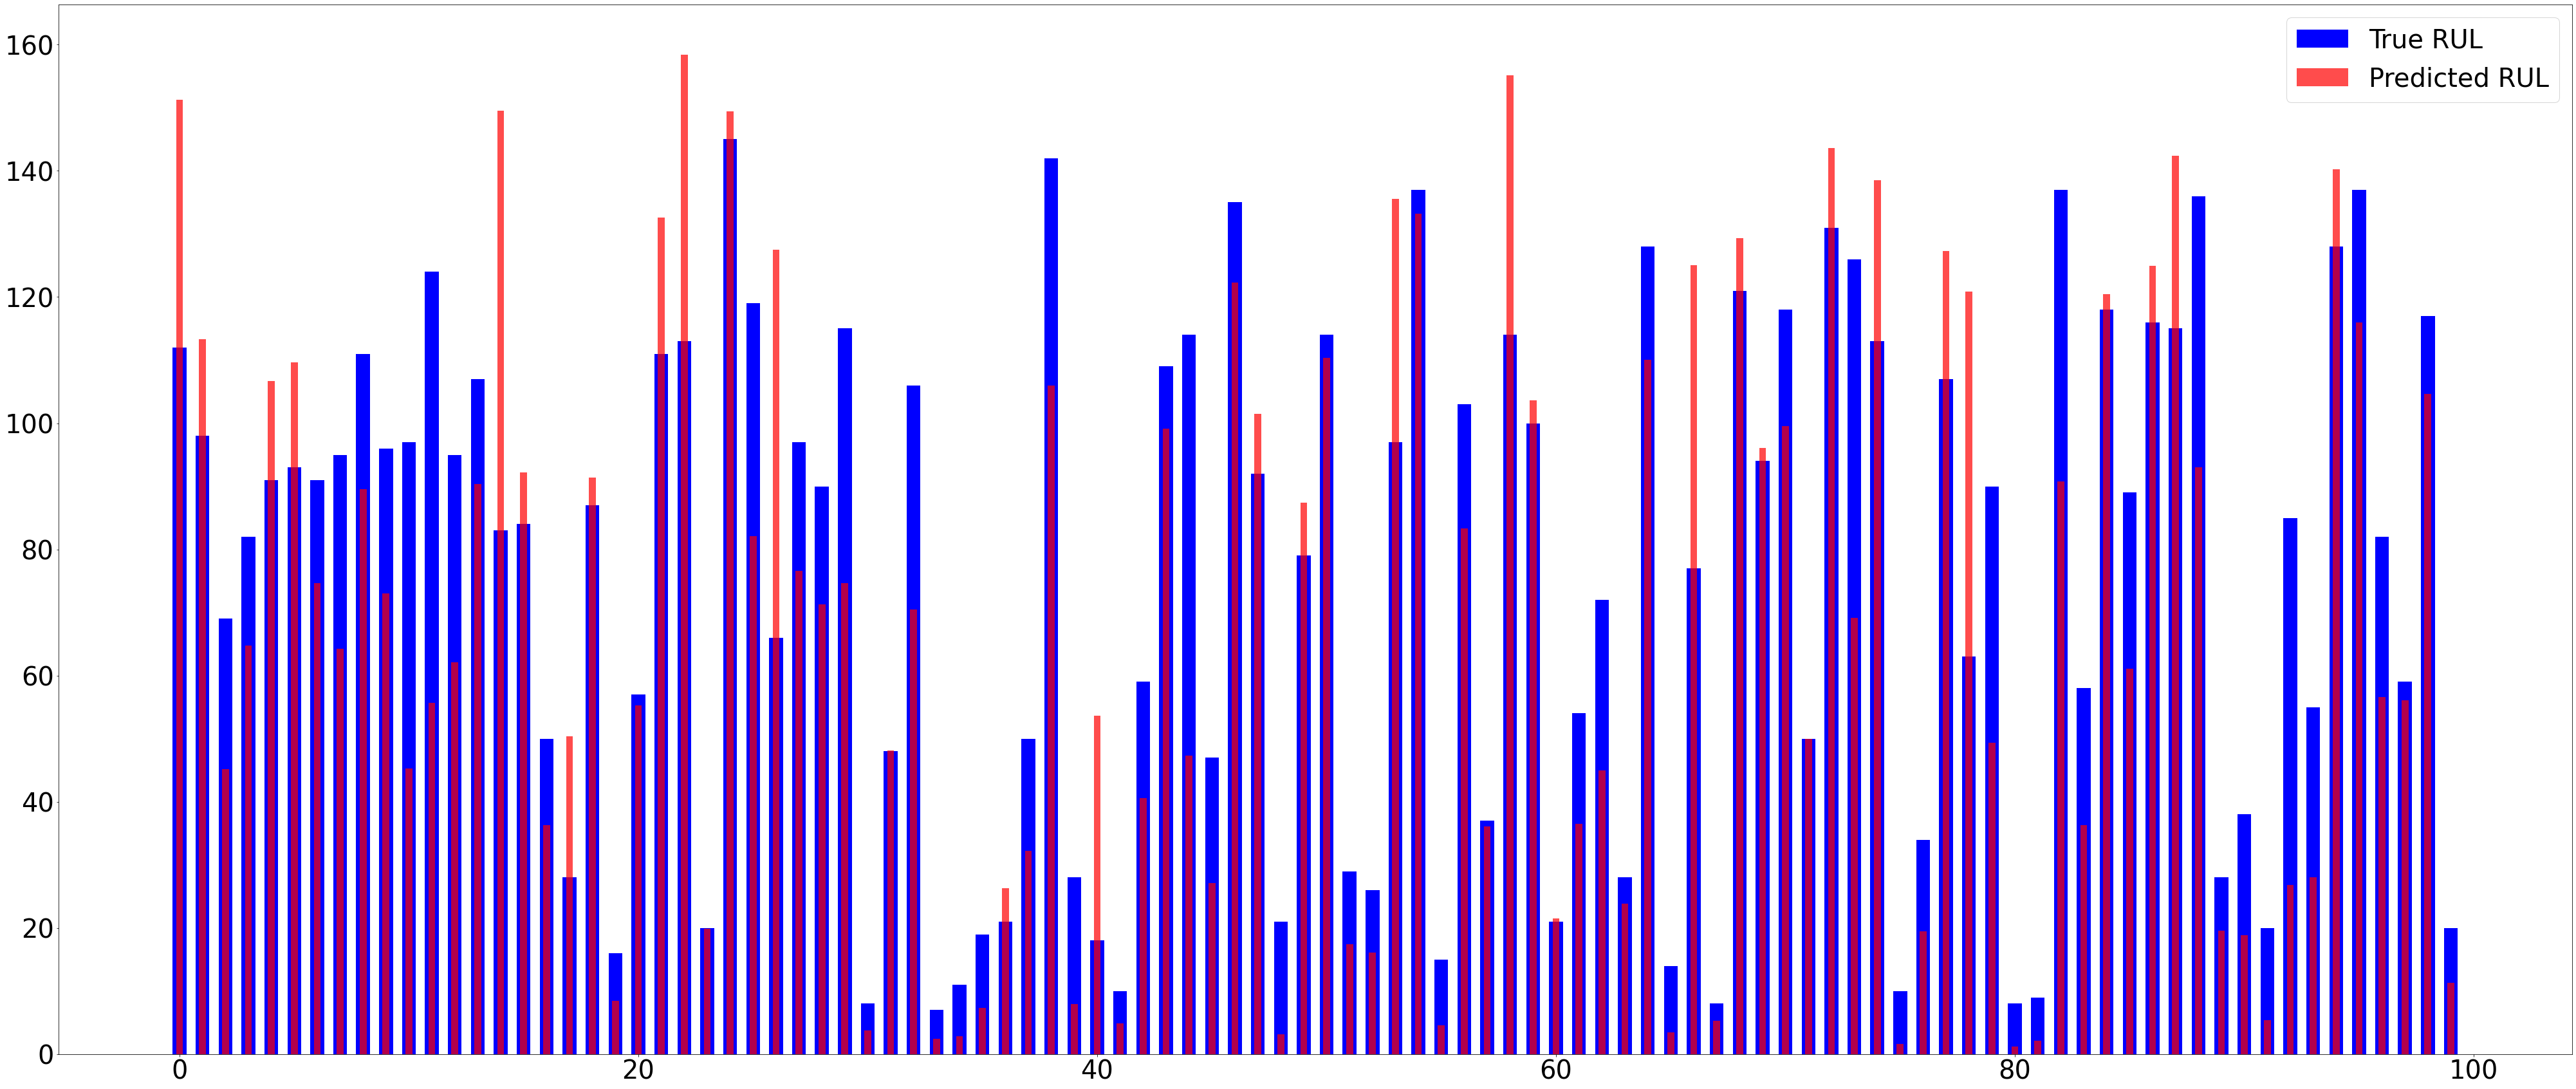

In [68]:
plot_predActual(y_valid, y_rf_valid)

### 3rd attempt (Data without useless sensors, with historical data)

In this section we are trying to discover a time series pattern in our features as we add to our data a new feature called 'rolling mean feature'. It's a equivalent to the mean value of a feature considering 10 time cycles. It will be computed for every feature.

In [69]:
df=train.copy()
for x in X_train_2.columns:
    df[x+'_rm']=0

    
df.columns



Index(['unit_number', 'time_cycles', 'setting_1', 'setting_2', 'setting_3',
       's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19',
       's_20', 's_21', 'RUL', 's_2_rm', 's_3_rm', 's_4_rm', 's_7_rm', 's_8_rm',
       's_9_rm', 's_11_rm', 's_12_rm', 's_13_rm', 's_14_rm', 's_15_rm',
       's_17_rm', 's_20_rm', 's_21_rm'],
      dtype='object')

In [70]:
df.head()

unit_number  time_cycles  setting_1  setting_2  setting_3     s_1     s_2  \
0            1            1    -0.0007    -0.0004      100.0  518.67  641.82   
1            1            2     0.0019    -0.0003      100.0  518.67  642.15   
2            1            3    -0.0043     0.0003      100.0  518.67  642.35   
3            1            4     0.0007     0.0000      100.0  518.67  642.35   
4            1            5    -0.0019    -0.0002      100.0  518.67  642.37   

       s_3      s_4    s_5  ...  s_8_rm  s_9_rm  s_11_rm  s_12_rm  s_13_rm  \
0  1589.70  1400.60  14.62  ...       0       0        0        0        0   
1  1591.82  1403.14  14.62  ...       0       0        0        0        0   
2  1587.99  1404.20  14.62  ...       0       0        0        0        0   
3  1582.79  1401.87  14.62  ...       0       0        0        0        0   
4  1582.85  1406.22  14.62  ...       0       0        0        0        0   

   s_14_rm  s_15_rm  s_17_rm  s_20_rm  s_21_rm  
0        0        0        0        0        0  
1        0        0        0        0        0  
2        0        0        0        0        0  
3        0        0        0        0        0  
4        0        0        0        0        0  

[5 rows x 41 columns]

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20631 entries, 0 to 20630
Data columns (total 41 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   unit_number  20631 non-null  int64  
 1   time_cycles  20631 non-null  int64  
 2   setting_1    20631 non-null  float64
 3   setting_2    20631 non-null  float64
 4   setting_3    20631 non-null  float64
 5   s_1          20631 non-null  float64
 6   s_2          20631 non-null  float64
 7   s_3          20631 non-null  float64
 8   s_4          20631 non-null  float64
 9   s_5          20631 non-null  float64
 10  s_6          20631 non-null  float64
 11  s_7          20631 non-null  float64
 12  s_8          20631 non-null  float64
 13  s_9          20631 non-null  float64
 14  s_10         20631 non-null  float64
 15  s_11         20631 non-null  float64
 16  s_12         20631 non-null  float64
 17  s_13         20631 non-null  float64
 18  s_14         20631 non-null  float64
 19  s_15

In [72]:
df.describe().transpose()

count         mean           std        min        25%  \
unit_number  20631.0    51.506568  2.922763e+01     1.0000    26.0000   
time_cycles  20631.0   108.807862  6.888099e+01     1.0000    52.0000   
setting_1    20631.0    -0.000009  2.187313e-03    -0.0087    -0.0015   
setting_2    20631.0     0.000002  2.930621e-04    -0.0006    -0.0002   
setting_3    20631.0   100.000000  0.000000e+00   100.0000   100.0000   
s_1          20631.0   518.670000  6.537152e-11   518.6700   518.6700   
s_2          20631.0   642.680934  5.000533e-01   641.2100   642.3250   
s_3          20631.0  1590.523119  6.131150e+00  1571.0400  1586.2600   
s_4          20631.0  1408.933782  9.000605e+00  1382.2500  1402.3600   
s_5          20631.0    14.620000  3.394700e-12    14.6200    14.6200   
s_6          20631.0    21.609803  1.388985e-03    21.6000    21.6100   
s_7          20631.0   553.367711  8.850923e-01   549.8500   552.8100   
s_8          20631.0  2388.096652  7.098548e-02  2387.9000  2388.0500   
s_9          20631.0  9065.242941  2.208288e+01  9021.7300  9053.1000   
s_10         20631.0     1.300000  4.660829e-13     1.3000     1.3000   
s_11         20631.0    47.541168  2.670874e-01    46.8500    47.3500   
s_12         20631.0   521.413470  7.375534e-01   518.6900   520.9600   
s_13         20631.0  2388.096152  7.191892e-02  2387.8800  2388.0400   
s_14         20631.0  8143.752722  1.907618e+01  8099.9400  8133.2450   
s_15         20631.0     8.442146  3.750504e-02     8.3249     8.4149   
s_16         20631.0     0.030000  1.556432e-14     0.0300     0.0300   
s_17         20631.0   393.210654  1.548763e+00   388.0000   392.0000   
s_18         20631.0  2388.000000  0.000000e+00  2388.0000  2388.0000   
s_19         20631.0   100.000000  0.000000e+00   100.0000   100.0000   
s_20         20631.0    38.816271  1.807464e-01    38.1400    38.7000   
s_21         20631.0    23.289705  1.082509e-01    22.8942    23.2218   
RUL          20631.0   107.807862  6.888099e+01     0.0000    51.0000   
s_2_rm       20631.0     0.000000  0.000000e+00     0.0000     0.0000   
s_3_rm       20631.0     0.000000  0.000000e+00     0.0000     0.0000   
s_4_rm       20631.0     0.000000  0.000000e+00     0.0000     0.0000   
s_7_rm       20631.0     0.000000  0.000000e+00     0.0000     0.0000   
s_8_rm       20631.0     0.000000  0.000000e+00     0.0000     0.0000   
s_9_rm       20631.0     0.000000  0.000000e+00     0.0000     0.0000   
s_11_rm      20631.0     0.000000  0.000000e+00     0.0000     0.0000   
s_12_rm      20631.0     0.000000  0.000000e+00     0.0000     0.0000   
s_13_rm      20631.0     0.000000  0.000000e+00     0.0000     0.0000   
s_14_rm      20631.0     0.000000  0.000000e+00     0.0000     0.0000   
s_15_rm      20631.0     0.000000  0.000000e+00     0.0000     0.0000   
s_17_rm      20631.0     0.000000  0.000000e+00     0.0000     0.0000   
s_20_rm      20631.0     0.000000  0.000000e+00     0.0000     0.0000   
s_21_rm      20631.0     0.000000  0.000000e+00     0.0000     0.0000   

                   50%        75%        max  
unit_number    52.0000    77.0000   100.0000  
time_cycles   104.0000   156.0000   362.0000  
setting_1       0.0000     0.0015     0.0087  
setting_2       0.0000     0.0003     0.0006  
setting_3     100.0000   100.0000   100.0000  
s_1           518.6700   518.6700   518.6700  
s_2           642.6400   643.0000   644.5300  
s_3          1590.1000  1594.3800  1616.9100  
s_4          1408.0400  1414.5550  1441.4900  
s_5            14.6200    14.6200    14.6200  
s_6            21.6100    21.6100    21.6100  
s_7           553.4400   554.0100   556.0600  
s_8          2388.0900  2388.1400  2388.5600  
s_9          9060.6600  9069.4200  9244.5900  
s_10            1.3000     1.3000     1.3000  
s_11           47.5100    47.7000    48.5300  
s_12          521.4800   521.9500   523.3800  
s_13         2388.0900  2388.1400  2388.5600  
s_14         8140.5400  8148.3100  8293.7200  
s_15    

In [73]:
df.shape

(20631, 41)

In [74]:
drop_labels2=['s_1', 's_5','s_6','s_10',  's_16', 's_18', 's_19']
df=df.drop(columns=setting_names+drop_labels2+['RUL'], axis=1)

X_valid_3=valid.drop(columns=index_names+setting_names+drop_labels2, axis=1)

In [75]:
X_valid_3.head()

s_2      s_3      s_4     s_7      s_8      s_9   s_11    s_12     s_13  \
0  643.02  1585.29  1398.21  553.90  2388.04  9050.17  47.20  521.72  2388.03   
1  641.71  1588.45  1395.42  554.85  2388.01  9054.42  47.50  522.16  2388.06   
2  642.46  1586.94  1401.34  554.11  2388.05  9056.96  47.50  521.97  2388.03   
3  642.44  1584.12  1406.42  554.07  2388.03  9045.29  47.28  521.38  2388.05   
4  642.51  1587.19  1401.92  554.16  2388.01  9044.55  47.31  522.15  2388.03   

      s_14    s_15  s_17   s_20     s_21  
0  8125.55  8.4052   392  38.86  23.3735  
1  8139.62  8.3803   393  39.02  23.3916  
2  8130.10  8.4441   393  39.08  23.4166  
3  8132.90  8.3917   391  39.00  23.3737  
4  8129.54  8.4031   390  38.99  23.4130

In [76]:
for x in  X_train_2.columns :
    u=1
    i=0
    while u<101:
        s=0
        while df.loc[i,'unit_number']==u  and i<len(df)-1:
            if s>=9:
                df.loc[i,x+'_rm']=df[x].rolling(10).mean()[s]
            else :
                df.loc[i,x+'_rm']= df.loc[i,x]
            i+=1
            s+=1
        u+=1
    
for x in  X_train_2.columns :
    u=1
    i=0
    while u<101:
        s=0
        while valid.loc[i,'unit_number']==u  and i<len(valid)-1:
            if s>=9:
                X_valid_3.loc[i,x+'_rm']=valid[x].rolling(10).mean()[s]
            else :
                X_valid_3.loc[i,x+'_rm']= valid.loc[i,x]
            i+=1
            s+=1
        u+=1
X_valid_3=X_valid_3.fillna(0)


In [77]:
df

unit_number  time_cycles     s_2      s_3      s_4     s_7      s_8  \
0                1            1  641.82  1589.70  1400.60  554.36  2388.06   
1                1            2  642.15  1591.82  1403.14  553.75  2388.04   
2                1            3  642.35  1587.99  1404.20  554.26  2388.08   
3                1            4  642.35  1582.79  1401.87  554.45  2388.11   
4                1            5  642.37  1582.85  1406.22  554.00  2388.06   
...            ...          ...     ...      ...      ...     ...      ...   
20626          100          196  643.49  1597.98  1428.63  551.43  2388.19   
20627          100          197  643.54  1604.50  1433.58  550.86  2388.23   
20628          100          198  643.42  1602.46  1428.18  550.94  2388.24   
20629          100          199  643.23  1605.26  1426.53  550.68  2388.25   
20630          100          200  643.85  1600.38  1432.14  550.79  2388.26   

           s_9   s_11    s_12  ...    s_8_rm    s_9_rm  s_11_rm  s_12_rm  \
0      9046.19  47.47  521.66  ...  2388.060  9046.190   47.470  521.660   
1      9044.07  47.49  522.28  ...  2388.040  9044.070   47.490  522.280   
2      9052.94  47.27  522.42  ...  2388.080  9052.940   47.270  522.420   
3      9049.48  47.13  522.86  ...  2388.110  9049.480   47.130  522.860   
4      9055.15  47.28  522.19  ...  2388.060  9055.150   47.280  522.190   
...        ...    ...     ...  ...       ...       ...      ...      ...   
20626  9065.52  48.07  519.49  ...  2388.177  9045.501   47.753  520.869   
20627  9065.11  48.04  519.68  ...  2388.151  9047.545   47.655  521.143   
20628  9065.90  48.09  520.01  ...  2388.124  9049.161   47.560  521.444   
20629  9073.72  48.39  519.67  ...  2388.102  9049.973   47.462  521.700   
20630  9061.48  48.20  519.30  ...     0.000     0.000    0.000    0.000   

        s_13_rm   s_14_rm  s_15_rm  s_17_rm  s_20_rm   s_21_rm  
0      2388.020  8138.620  8.41950    392.0   39.060  23.41900  
1      2388.070  8131.490  8.43180    392.0   39.000  23.42360  
2      2388.030  8133.230  8.41780    390.0   38.950  23.34420  
3      2388.080  8133.830  8.36820    392.0   38.880  23.37390  
4      2388.040  8133.800  8.42940    393.0   38.900  23.40440  
...         ...       ...      ...      ...      ...       ...  
20626  2388.177  8123.882  8.47010    394.0   38.707  23.21103  
20627  2388.143  8125.982  8.45659    393.4   38.783  23.24515  
20628  2388.119  8127.578  8.44252    393.0   38.847  23.29197  
20629  2388.090  8129.460  8.43010    392.6   38.909  23.32788  
20630     0.000     0.000  0.00000      0.0    0.000   0.00000  

[20631 rows x 30 columns]

dealing with last line problem

In [78]:
df.iloc[-1,-14:]=df.iloc[-2,-14:]
X_valid_3.iloc[-1,-14:]=X_valid_3.iloc[-2,-14:]

Saving the modified data-set.

In [79]:
train_tm=df

In [80]:
train_tm.head()

unit_number  time_cycles     s_2      s_3      s_4     s_7      s_8  \
0            1            1  641.82  1589.70  1400.60  554.36  2388.06   
1            1            2  642.15  1591.82  1403.14  553.75  2388.04   
2            1            3  642.35  1587.99  1404.20  554.26  2388.08   
3            1            4  642.35  1582.79  1401.87  554.45  2388.11   
4            1            5  642.37  1582.85  1406.22  554.00  2388.06   

       s_9   s_11    s_12  ...   s_8_rm   s_9_rm  s_11_rm  s_12_rm  s_13_rm  \
0  9046.19  47.47  521.66  ...  2388.06  9046.19    47.47   521.66  2388.02   
1  9044.07  47.49  522.28  ...  2388.04  9044.07    47.49   522.28  2388.07   
2  9052.94  47.27  522.42  ...  2388.08  9052.94    47.27   522.42  2388.03   
3  9049.48  47.13  522.86  ...  2388.11  9049.48    47.13   522.86  2388.08   
4  9055.15  47.28  522.19  ...  2388.06  9055.15    47.28   522.19  2388.04   

   s_14_rm  s_15_rm  s_17_rm  s_20_rm  s_21_rm  
0  8138.62   8.4195    392.0    39.06  23.4190  
1  8131.49   8.4318    392.0    39.00  23.4236  
2  8133.23   8.4178    390.0    38.95  23.3442  
3  8133.83   8.3682    392.0    38.88  23.3739  
4  8133.80   8.4294    393.0    38.90  23.4044  

[5 rows x 30 columns]

In [81]:
train_tm=train_tm.drop(columns=index_names, axis=1)

In [82]:
X_train_tm, X_test_tm, y_train_tm, y_test_tm=train_test_split(train_tm,train['RUL'].clip(upper=195), test_size=0.35, random_state=42)
X_train_tm_s=scaler.fit_transform(X_train_tm)
X_test_tm_s=scaler.fit_transform(X_test_tm)
X_val3=pd.concat([valid['unit_number'],X_valid_3],axis=1)
X_valid3 = X_val3.groupby('unit_number').last().reset_index().drop(columns=['unit_number'])
X_valid_s=scaler.fit_transform(X_valid3)

In [83]:
X_train_tm.head()

s_2      s_3      s_4     s_7      s_8      s_9   s_11    s_12  \
12276  643.13  1596.74  1425.08  552.37  2388.18  9048.80  47.93  520.67   
8157   642.67  1589.76  1414.60  553.96  2388.15  9069.60  47.57  521.49   
11666  642.28  1584.21  1397.82  553.94  2388.06  9049.51  47.21  521.81   
12639  642.21  1590.02  1407.01  553.71  2388.10  9067.84  47.59  521.44   
5278   643.03  1594.48  1419.63  551.62  2388.14  9088.57  47.66  520.71   

          s_13     s_14  ...    s_8_rm    s_9_rm  s_11_rm  s_12_rm   s_13_rm  \
12276  2388.22  8132.97  ...  2388.137  9047.451   47.606  520.948  2388.152   
8157   2388.10  8141.35  ...  2388.098  9050.097   47.483  521.672  2388.103   
11666  2388.05  8138.16  ...  2388.107  9048.020   47.552  521.424  2388.110   
12639  2388.08  8147.09  ...  2388.161  9047.946   47.672  520.769  2388.192   
5278   2388.15  8173.55  ...  2388.202  9045.187   47.831  520.473  2388.209   

        s_14_rm  s_15_rm  s_17_rm  s_20_rm   s_21_rm  
12276  8125.612  8.45069    393.2   38.762  23.24304  
8157   8130.971  8.42935    393.6   38.938  23.32361  
11666  8130.106  8.43050    393.1   38.830  23.29264  
12639  8125.048  8.45399    393.9   38.724  23.24131  
5278   8123.993  8.47694    394.0   38.655  23.21727  

[5 rows x 28 columns]

In [84]:
X_train_tm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13410 entries, 12276 to 15795
Data columns (total 28 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   s_2      13410 non-null  float64
 1   s_3      13410 non-null  float64
 2   s_4      13410 non-null  float64
 3   s_7      13410 non-null  float64
 4   s_8      13410 non-null  float64
 5   s_9      13410 non-null  float64
 6   s_11     13410 non-null  float64
 7   s_12     13410 non-null  float64
 8   s_13     13410 non-null  float64
 9   s_14     13410 non-null  float64
 10  s_15     13410 non-null  float64
 11  s_17     13410 non-null  int64  
 12  s_20     13410 non-null  float64
 13  s_21     13410 non-null  float64
 14  s_2_rm   13410 non-null  float64
 15  s_3_rm   13410 non-null  float64
 16  s_4_rm   13410 non-null  float64
 17  s_7_rm   13410 non-null  float64
 18  s_8_rm   13410 non-null  float64
 19  s_9_rm   13410 non-null  float64
 20  s_11_rm  13410 non-null  float64
 21  s_12_rm 

In [85]:
X_train_tm.describe().transpose()

count         mean        std         min         25%         50%  \
s_2      13410.0   642.684081   0.501015   641.25000   642.33000   642.65000   
s_3      13410.0  1590.540553   6.144671  1571.04000  1586.25250  1590.11000   
s_4      13410.0  1409.010762   9.029287  1386.29000  1402.35000  1408.09000   
s_7      13410.0   553.367130   0.884429   549.85000   552.80000   553.45000   
s_8      13410.0  2388.096520   0.071311  2387.91000  2388.04000  2388.09000   
s_9      13410.0  9065.469450  22.516258  9021.73000  9053.15000  9060.73500   
s_11     13410.0    47.542057   0.268293    46.86000    47.35000    47.51000   
s_12     13410.0   521.407828   0.737864   518.69000   520.95000   521.47000   
s_13     13410.0  2388.096076   0.072189  2387.88000  2388.04000  2388.09000   
s_14     13410.0  8143.966862  19.429863  8103.77000  8133.25250  8140.57000   
s_15     13410.0     8.442414   0.037511     8.32490     8.41510     8.43930   
s_17     13410.0   393.223565   1.551121   389.00000   392.00000   393.00000   
s_20     13410.0    38.815690   0.181401    38.14000    38.70000    38.83000   
s_21     13410.0    23.288667   0.108433    22.90710    23.22010    23.29580   
s_2_rm   13410.0   642.516215   0.362540   641.25000   642.28900   642.42000   
s_3_rm   13410.0  1588.404425   3.854352  1572.98000  1585.97050  1587.61700   
s_4_rm   13410.0  1405.304689   7.086894  1387.62000  1400.51200  1403.84200   
s_7_rm   13410.0   553.640729   0.728443   551.37700   553.25000   553.88950   
s_8_rm   13410.0  2388.092166   0.059608  2387.91000  2388.05600  2388.07700   
s_9_rm   13410.0  9049.395891   3.463464  9033.93000  9047.66500  9049.48400   
s_11_rm  13410.0    47.448770   0.224364    46.90000    47.29200    47.39000   
s_12_rm  13410.0   521.631866   0.630241   519.83100   521.37900   521.79400   
s_13_rm  13410.0  2388.091434   0.065136  2387.92000  2388.05000  2388.07100   
s_14_rm  13410.0  8130.535676   4.853552  8115.95400  8129.25000  8131.33000   
s_15_rm  13410.0     8.428917   0.025868     8.33030     8.41412     8.42342   
s_17_rm  13410.0   392.581156   1.050338   389.00000   391.90000   392.20000   
s_20_rm  13410.0    38.876391   0.126541    38.46400    38.81300    38.91000   
s_21_rm  13410.0    23.328273   0.080095    23.05868    23.28583    23.34659   

                 75%         max  
s_2       643.007500   644.53000  
s_3      1594.400000  1614.93000  
s_4      1414.687500  1441.49000  
s_7       554.000000   556.06000  
s_8      2388.140000  2388.56000  
s_9      9069.510000  9244.59000  
s_11       47.700000    48.53000  
s_12      521.950000   523.38000  
s_13     2388.140000  2388.56000  
s_14     8148.380000  8293.72000  
s_15        8.465900     8.58480  
s_17      394.000000   400.00000  
s_20       38.950000    39.43000  
s_21       23.366775    23.60640  
s_2_rm    642.755000   643.71600  
s_3_rm   1589.952000  1602.39000  
s_4_rm   1408.393000  1425.92300  
s_7_rm    554.085000   555.58000  
s_8_rm   2388.114000  2388.27100  
s_9_rm   9050.550000  9076.48000  
s_11_rm    47.564000    48.14100  
s_12_rm   522.054000   523.31000  
s_13_rm  2388.120000  2388.28400  
s_14_rm  8132.597000  8159.99000  
s_15_rm     8.436900     8.51548  
s_17_rm   393.100000   396.20000  
s_20_rm    38.955000    39.34000  
s_21_rm    23.385440    23.57510

In [86]:
y_train_tm

12276     30
8157      80
11666    103
12639    124
5278      30
        ... 
11284    107
11964    162
5390      74
860      195
15795    157
Name: RUL, Length: 13410, dtype: int64

In [87]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14441 entries, 12862 to 15795
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   s_1     14441 non-null  float64
 1   s_2     14441 non-null  float64
 2   s_3     14441 non-null  float64
 3   s_4     14441 non-null  float64
 4   s_5     14441 non-null  float64
 5   s_6     14441 non-null  float64
 6   s_7     14441 non-null  float64
 7   s_8     14441 non-null  float64
 8   s_9     14441 non-null  float64
 9   s_10    14441 non-null  float64
 10  s_11    14441 non-null  float64
 11  s_12    14441 non-null  float64
 12  s_13    14441 non-null  float64
 13  s_14    14441 non-null  float64
 14  s_15    14441 non-null  float64
 15  s_16    14441 non-null  float64
 16  s_17    14441 non-null  int64  
 17  s_18    14441 non-null  int64  
 18  s_19    14441 non-null  float64
 19  s_20    14441 non-null  float64
 20  s_21    14441 non-null  float64
dtypes: float64(19), int64(2)
memory

#### Models evaluation ( rmse, r2, features importance)

Linear regression

In [88]:
lr=Linear_Regression()
lr.fit(X_train_tm_s, y_train_tm)

y_lr_train = lr.predict(X_train_tm_s)
evaluate(y_train_tm,y_lr_train, label='train')

y_lr_test = lr.predict(X_test_tm_s)
evaluate(y_test_tm, y_lr_test, label='test')

y_lr_valid = lr.predict(X_valid_s)
evaluate(y_valid, y_lr_valid, label='valid')

train set RMSE:44.54569088693464, R2:0.4618216015481704
test set RMSE:43.47721680461448, R2:0.47631060443091466
valid set RMSE:30.827413040972857, R2:0.449680859053432


SVR

In [89]:
regressor.fit(X_train_tm_s, y_train_tm)

y_svr_train = regressor.predict(X_train_tm_s)
evaluate(y_train_tm,y_svr_train, label='train')

y_svr_test = regressor.predict(X_test_tm_s)
evaluate(y_test_tm, y_svr_test, label='test')

y_svr_valid = regressor.predict(X_valid_s)
evaluate(y_valid, y_svr_valid, label='valid')

train set RMSE:31.867964601389673, R2:0.7245622157889691
test set RMSE:34.532050182697034, R2:0.6696342345960893
valid set RMSE:25.100208323708763, R2:0.6351661654744639


The model is generalized, we avoided overfitting

Random forest

In [90]:
rf = RandomForestRegressor(max_features="sqrt", random_state=42)
rf.fit(X_train_tm_s, y_train_tm)
# predict and evaluate
y_hat_train = rf.predict(X_train_tm_s)
evaluate(y_train_tm,y_hat_train, label='train')
y_hat_test = rf.predict(X_test_tm_s)
evaluate(y_test_tm, y_hat_test, label='test')
y_hat_valid = rf.predict(X_valid_s)
evaluate(y_valid, y_hat_valid, label='valid')

train set RMSE:10.593647281975143, R2:0.9695627170481853
test set RMSE:30.10624472665659, R2:0.7488903023819691
valid set RMSE:28.659176087249964, R2:0.5243715136336871


==> the model is overfitting to train/test

Performing Grid Search

In [91]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestRegressor

estimator = RandomForestRegressor()
param_grid = { 
    'n_estimators': [50,90,120],
    'max_depth' : [8,9,10],
}

grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=3)

grid.fit(X_train_tm_s, y_train_tm)

print(grid.best_score_ , grid.best_params_)
#max_features=5,

0.7809848515276627 {'max_depth': 10, 'n_estimators': 120}


In [92]:
rf=RandomForestRegressor(n_estimators=90,  max_depth=10, n_jobs=-1, random_state=42)
rf.fit(X_train_tm_s, y_train_tm)
# predict and evaluate
y_hat_train = rf.predict(X_train_tm_s)
evaluate(y_train_tm,y_hat_train, label='train')
y_hat_test = rf.predict(X_test_tm_s)
evaluate(y_test_tm, y_hat_test, label='test')
y_hat_valid = rf.predict(X_valid_s)
evaluate(y_valid, y_hat_valid, label='valid')

train set RMSE:24.251300994156047, R2:0.8404910898980422
test set RMSE:30.918425190302727, R2:0.7351591088726064
valid set RMSE:33.05288307319795, R2:0.3673563542664161


==> the model is overfitting to train/test

In [93]:
# Params found using Bayesian Optimisation
xgb = xgboost.XGBRegressor(n_estimators=50, 
                           max_depth=6,
                           learning_rate=0.1,
                           reg_lambda=0.02,
                           gamma=0.4,
                           random_state=42)
xgb.fit(X_train_tm_s, y_train_tm)

# predict and evaluate
y_hat_train = xgb.predict(X_train_tm_s)
evaluate(y_train_tm, y_hat_train, 'train')

y_hat_test = xgb.predict(X_test_tm_s)
evaluate(y_test_tm, y_hat_test)

y_hat_valid = xgb.predict(X_valid_s)
evaluate(y_valid, y_hat_valid, label='valid')

train set RMSE:24.42505590736013, R2:0.8381972134394149
test set RMSE:30.284785396868866, R2:0.7459031325934247
valid set RMSE:32.45825395889641, R2:0.3899144150431426


==> the model is overfitting to train/test

#### Cross Validation 

Cross validation will be performed with SVR model (best model so far) by performing multiple splits on the dataset and running the model on each proportion for every split

In [94]:
train_tm

s_2      s_3      s_4     s_7      s_8      s_9   s_11    s_12  \
0      641.82  1589.70  1400.60  554.36  2388.06  9046.19  47.47  521.66   
1      642.15  1591.82  1403.14  553.75  2388.04  9044.07  47.49  522.28   
2      642.35  1587.99  1404.20  554.26  2388.08  9052.94  47.27  522.42   
3      642.35  1582.79  1401.87  554.45  2388.11  9049.48  47.13  522.86   
4      642.37  1582.85  1406.22  554.00  2388.06  9055.15  47.28  522.19   
...       ...      ...      ...     ...      ...      ...    ...     ...   
20626  643.49  1597.98  1428.63  551.43  2388.19  9065.52  48.07  519.49   
20627  643.54  1604.50  1433.58  550.86  2388.23  9065.11  48.04  519.68   
20628  643.42  1602.46  1428.18  550.94  2388.24  9065.90  48.09  520.01   
20629  643.23  1605.26  1426.53  550.68  2388.25  9073.72  48.39  519.67   
20630  643.85  1600.38  1432.14  550.79  2388.26  9061.48  48.20  519.30   

          s_13     s_14  ...    s_8_rm    s_9_rm  s_11_rm  s_12_rm   s_13_rm  \
0      2388.02  8138.62  ...  2388.060  9046.190   47.470  521.660  2388.020   
1      2388.07  8131.49  ...  2388.040  9044.070   47.490  522.280  2388.070   
2      2388.03  8133.23  ...  2388.080  9052.940   47.270  522.420  2388.030   
3      2388.08  8133.83  ...  2388.110  9049.480   47.130  522.860  2388.080   
4      2388.04  8133.80  ...  2388.060  9055.150   47.280  522.190  2388.040   
...        ...      ...  ...       ...       ...      ...      ...       ...   
20626  2388.26  8137.60  ...  2388.177  9045.501   47.753  520.869  2388.177   
20627  2388.22  8136.50  ...  2388.151  9047.545   47.655  521.143  2388.143   
20628  2388.24  8141.05  ...  2388.124  9049.161   47.560  521.444  2388.119   
20629  2388.23  8139.29  ...  2388.102  9049.973   47.462  521.700  2388.090   
20630  2388.26  8137.33  ...  2388.102  9049.973   47.462  521.700  2388.090   

        s_14_rm  s_15_rm  s_17_rm  s_20_rm   s_21_rm  
0      8138.620  8.41950    392.0   39.060  23.41900  
1      8131.490  8.43180    392.0   39.000  23.42360  
2      8133.230  8.41780    390.0   38.950  23.34420  
3      8133.830  8.36820    392.0   38.880  23.37390  
4      8133.800  8.42940    393.0   38.900  23.40440  
...         ...      ...      ...      ...       ...  
20626  8123.882  8.47010    394.0   38.707  23.21103  
20627  8125.982  8.45659    393.4   38.783  23.24515  
20628  8127.578  8.44252    393.0   38.847  23.29197  
20629  8129.460  8.43010    392.6   38.909  23.32788  
20630  8129.460  8.43010    392.6   38.909  23.32788  

[20631 rows x 28 columns]

In [95]:
from sklearn.model_selection import KFold
train_tm_cv=train_tm.copy()
y=train['RUL'].clip(upper=195)
scores_train=[]
scores_test=[]
scores_validation=[]

cv = KFold(n_splits=4, shuffle=True)
for train_index, test_index in cv.split(train_tm) :
    print("Index du train : ", train_index, "\n")
    print("Index de test : ", test_index)
    X_train, X_test, y_train, y_test = train_tm.iloc[train_index,:], train_tm.iloc[test_index,:],y[train_index], y[test_index]
    regressor.fit(scaler.fit_transform(X_train), y_train)
    y_hat_train = regressor.predict(scaler.fit_transform(X_train))
    evaluate(y_train,y_hat_train, label='train')
    y_hat_test = regressor.predict(scaler.fit_transform(X_test))
    evaluate(y_test, y_hat_test, label='test')
    y_hat_valid = regressor.predict(scaler.fit_transform(X_valid3))
    evaluate(y_valid, y_hat_valid, label='valid')



Index du train :  [    0     1     2 ... 20628 20629 20630] 

Index de test :  [    4     6     8 ... 20618 20622 20623]
train set RMSE:31.762235627679363, R2:0.7256947900749244
test set RMSE:31.579771714038774, R2:0.7234165650181191
valid set RMSE:23.66010944404502, R2:0.675829154150268
Index du train :  [    1     2     3 ... 20625 20627 20628] 

Index de test :  [    0     7     9 ... 20626 20629 20630]
train set RMSE:31.507251387037904, R2:0.7280588114692583
test set RMSE:32.584124426295766, R2:0.712143886555599
valid set RMSE:24.399825960770915, R2:0.6552423489788051
Index du train :  [    0     1     2 ... 20626 20629 20630] 

Index de test :  [    3     5    10 ... 20625 20627 20628]
train set RMSE:31.622568300074224, R2:0.7278337735716927
test set RMSE:32.30856530602672, R2:0.7114333613345596
valid set RMSE:24.239397247388915, R2:0.6597610040059044
Index du train :  [    0     3     4 ... 20628 20629 20630] 

Index de test :  [    1     2    13 ... 20612 20613 20619]
train set 

### feature importance

<BarContainer object of 28 artists>

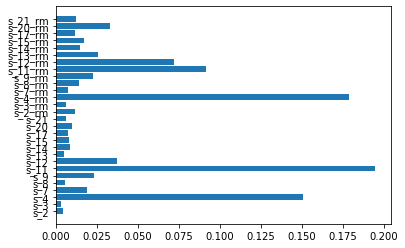

In [96]:
#BEST FEATURE FOR XGB MODEL
xgb.fit(X_train_tm_s, y_train_tm)
plt.barh(train_tm.columns, xgb.feature_importances_)

<BarContainer object of 28 artists>

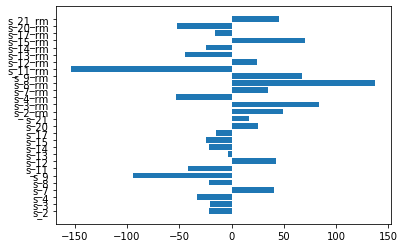

In [97]:
#BEST FEATURE FOR LINEAR REGRESSION MODEL

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X=X_train_tm_s, y=y_train_tm)
plt.barh(X_train_tm.columns, model.coef_)

<BarContainer object of 28 artists>

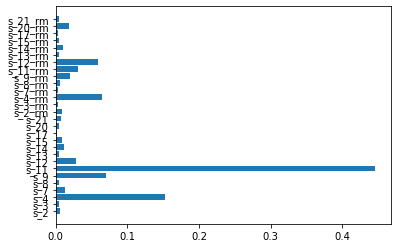

In [98]:
#BEST FEATURE FOR RF MODEL
rf.fit(X_train_tm_s, y_train_tm)
plt.barh(train_tm.columns, rf.feature_importances_)

#### Creating new df

In [99]:
dftm= pd.concat([train['unit_number'],train_tm,train['RUL']],axis=1)

In [100]:
#dftrain = pd.read_csv('train_FD001.txt',sep='\s+',header=None,index_col='unit_number',names=col_names)
#cols = ['unit_number','s_2','s_3','s_4','s_7', 's_8','s_9','s_11','s_12','s_13','s_14','s_15','s_17','s_20','s_21','s_2_rm','s_3_rm',
      #  's_4_rm','s_7_rm', 's_8_rm','s_9_rm','s_11_rm','s_12_rm','s_13_rm','s_14_rm','s_15_rm','s_17_rm','s_20_rm','s_21_rm']


In [101]:
#df2.to_csv("D:\\AI WORKSHOP\\CCPP_SCORED.CSV")
#dftm[cols].to_csv("D:\\AI WORKSHOP\\dftm_1.CSV")

In [102]:
#dftm = pd.read_csv('dftm_1.CSV',sep='\s+',header=None,index_col='unit_number',names=col_names)

In [103]:
#dftm.head()

In [104]:
dftm

unit_number     s_2      s_3      s_4     s_7      s_8      s_9   s_11  \
0                1  641.82  1589.70  1400.60  554.36  2388.06  9046.19  47.47   
1                1  642.15  1591.82  1403.14  553.75  2388.04  9044.07  47.49   
2                1  642.35  1587.99  1404.20  554.26  2388.08  9052.94  47.27   
3                1  642.35  1582.79  1401.87  554.45  2388.11  9049.48  47.13   
4                1  642.37  1582.85  1406.22  554.00  2388.06  9055.15  47.28   
...            ...     ...      ...      ...     ...      ...      ...    ...   
20626          100  643.49  1597.98  1428.63  551.43  2388.19  9065.52  48.07   
20627          100  643.54  1604.50  1433.58  550.86  2388.23  9065.11  48.04   
20628          100  643.42  1602.46  1428.18  550.94  2388.24  9065.90  48.09   
20629          100  643.23  1605.26  1426.53  550.68  2388.25  9073.72  48.39   
20630          100  643.85  1600.38  1432.14  550.79  2388.26  9061.48  48.20   

         s_12     s_13  ...    s_9_rm  s_11_rm  s_12_rm   s_13_rm   s_14_rm  \
0      521.66  2388.02  ...  9046.190   47.470  521.660  2388.020  8138.620   
1      522.28  2388.07  ...  9044.070   47.490  522.280  2388.070  8131.490   
2      522.42  2388.03  ...  9052.940   47.270  522.420  2388.030  8133.230   
3      522.86  2388.08  ...  9049.480   47.130  522.860  2388.080  8133.830   
4      522.19  2388.04  ...  9055.150   47.280  522.190  2388.040  8133.800   
...       ...      ...  ...       ...      ...      ...       ...       ...   
20626  519.49  2388.26  ...  9045.501   47.753  520.869  2388.177  8123.882   
20627  519.68  2388.22  ...  9047.545   47.655  521.143  2388.143  8125.982   
20628  520.01  2388.24  ...  9049.161   47.560  521.444  2388.119  8127.578   
20629  519.67  2388.23  ...  9049.973   47.462  521.700  2388.090  8129.460   
20630  519.30  2388.26  ...  9049.973   47.462  521.700  2388.090  8129.460   

       s_15_rm  s_17_rm  s_20_rm   s_21_rm  RUL  
0      8.41950    392.0   39.060  23.41900  191  
1      8.43180    392.0   39.000  23.42360  190  
2      8.41780    390.0   38.950  23.34420  189  
3      8.36820    392.0   38.880  23.37390  188  
4      8.42940    393.0   38.900  23.40440  187  
...        ...      ...      ...       ...  ...  
20626  8.47010    394.0   38.707  23.21103    4  
20627  8.45659    393.4   38.783  23.24515    3  
20628  8.44252    393.0   38.847  23.29197    2  
20629  8.43010    392.6   38.909  23.32788    1  
20630  8.43010    392.6   38.909  23.32788    0  

[20631 rows x 30 columns]

In [105]:
dftm['RUL'].head()

0    191
1    190
2    189
3    188
4    187
Name: RUL, dtype: int64

In [106]:
dftm.head()

unit_number     s_2      s_3      s_4     s_7      s_8      s_9   s_11  \
0            1  641.82  1589.70  1400.60  554.36  2388.06  9046.19  47.47   
1            1  642.15  1591.82  1403.14  553.75  2388.04  9044.07  47.49   
2            1  642.35  1587.99  1404.20  554.26  2388.08  9052.94  47.27   
3            1  642.35  1582.79  1401.87  554.45  2388.11  9049.48  47.13   
4            1  642.37  1582.85  1406.22  554.00  2388.06  9055.15  47.28   

     s_12     s_13  ...   s_9_rm  s_11_rm  s_12_rm  s_13_rm  s_14_rm  s_15_rm  \
0  521.66  2388.02  ...  9046.19    47.47   521.66  2388.02  8138.62   8.4195   
1  522.28  2388.07  ...  9044.07    47.49   522.28  2388.07  8131.49   8.4318   
2  522.42  2388.03  ...  9052.94    47.27   522.42  2388.03  8133.23   8.4178   
3  522.86  2388.08  ...  9049.48    47.13   522.86  2388.08  8133.83   8.3682   
4  522.19  2388.04  ...  9055.15    47.28   522.19  2388.04  8133.80   8.4294   

   s_17_rm  s_20_rm  s_21_rm  RUL  
0    392.0    39.06  23.4190  191  
1    392.0    39.00  23.4236  190  
2    390.0    38.95  23.3442  189  
3    392.0    38.88  23.3739  188  
4    393.0    38.90  23.4044  187  

[5 rows x 30 columns]

In [107]:
#RUL = pd.Series(
 #   dftm['RUL'], index=pd.date_range("195-210", periods=len(RUL), freq="M"), name="RUL")
#RUL.describe()

In [108]:
cols = ['unit_number','s_2','s_3','s_4','s_7', 's_8','s_9','s_11','s_12','s_13','s_14','s_15','s_17','s_20','s_21','s_2_rm','s_3_rm','s_4_rm','s_7_rm', 's_8_rm','s_9_rm','s_11_rm','s_12_rm','s_13_rm','s_14_rm','s_15_rm','s_17_rm','s_20_rm','s_21_rm','RUL']

In [109]:
dftm[cols].to_csv("D:\\AI WORKSHOP\\trend.CSV" ,index='unit_number')

In [110]:
dftm_1 = pd.read_csv('trend.csv',index_col='unit_number')
dftm_1

s_2      s_3      s_4     s_7      s_8      s_9   s_11  \
unit_number                                                              
1            641.82  1589.70  1400.60  554.36  2388.06  9046.19  47.47   
1            642.15  1591.82  1403.14  553.75  2388.04  9044.07  47.49   
1            642.35  1587.99  1404.20  554.26  2388.08  9052.94  47.27   
1            642.35  1582.79  1401.87  554.45  2388.11  9049.48  47.13   
1            642.37  1582.85  1406.22  554.00  2388.06  9055.15  47.28   
...             ...      ...      ...     ...      ...      ...    ...   
100          643.49  1597.98  1428.63  551.43  2388.19  9065.52  48.07   
100          643.54  1604.50  1433.58  550.86  2388.23  9065.11  48.04   
100          643.42  1602.46  1428.18  550.94  2388.24  9065.90  48.09   
100          643.23  1605.26  1426.53  550.68  2388.25  9073.72  48.39   
100          643.85  1600.38  1432.14  550.79  2388.26  9061.48  48.20   

               s_12     s_13     s_14  ...    s_9_rm  s_11_rm  s_12_rm  \
unit_number                            ...                               
1            521.66  2388.02  8138.62  ...  9046.190   47.470  521.660   
1            522.28  2388.07  8131.49  ...  9044.070   47.490  522.280   
1            522.42  2388.03  8133.23  ...  9052.940   47.270  522.420   
1            522.86  2388.08  8133.83  ...  9049.480   47.130  522.860   
1            522.19  2388.04  8133.80  ...  9055.150   47.280  522.190   
...             ...      ...      ...  ...       ...      ...      ...   
100          519.49  2388.26  8137.60  ...  9045.501   47.753  520.869   
100          519.68  2388.22  8136.50  ...  9047.545   47.655  521.143   
100          520.01  2388.24  8141.05  ...  9049.161   47.560  521.444   
100          519.67  2388.23  8139.29  ...  9049.973   47.462  521.700   
100          519.30  2388.26  8137.33  ...  9049.973   47.462  521.700   

              s_13_rm   s_14_rm  s_15_rm  s_17_rm  s_20_rm   s_21_rm  RUL  
unit_number                                                                
1            2388.020  8138.620  8.41950    392.0   39.060  23.41900  191  
1            2388.070  8131.490  8.43180    392.0   39.000  23.42360  190  
1            2388.030  8133.230  8.41780    390.0   38.950  23.34420  189  
1            2388.080  8133.830  8.36820    392.0   38.880  23.37390  188  
1            2388.040  8133.800  8.42940    393.0   38.900  23.40440  187  
...               ...       ...      ...      ...      ...       ...  ...  
100          2388.177  8123.882  8.47010    394.0   38.707  23.21103    4  
100          2388.143  8125.982  8.45659    393.4   38.783  23.24515    3  
100          2388.119  8127.578  8.44252    393.0   38.847  23.29197    2  
100          2388.090  8129.460  8.43010    392.6   38.909  23.32788    1  
100          2388.090  8129.460  8.43010    392.6   38.909  23.32788    0  

[20631 rows x 29 columns]

Plotting new features 

In [111]:
def plot_signal(df, signal_name):
    plt.figure(figsize=(13,5))
    for i in df['unit_number'].unique():
        if (i % 10 == 0):  
            plt.plot('RUL', signal_name, data=df[df['unit_number']==i].rolling(8).mean())

    plt.ylabel(signal_name)
    plt.xlabel('Remaining Useful Life')
    plt.show()



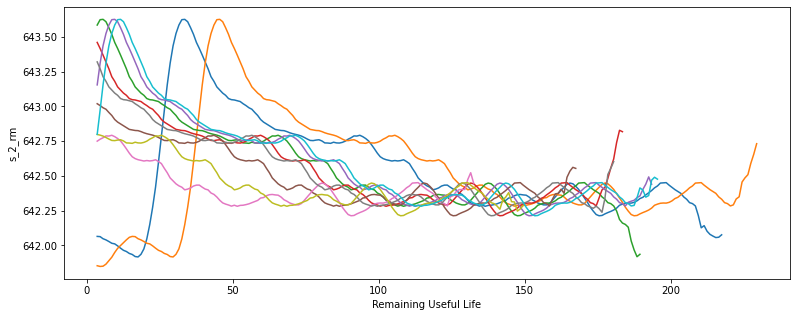

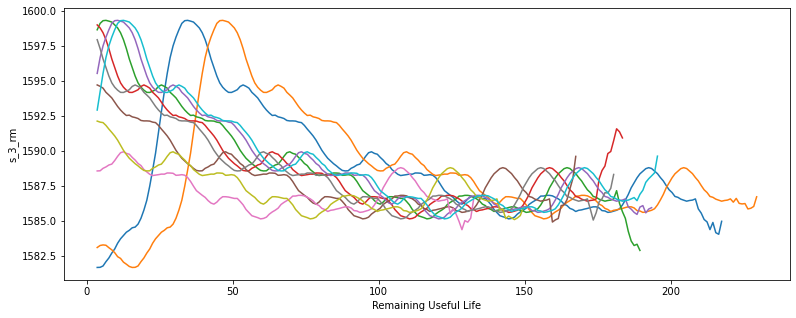

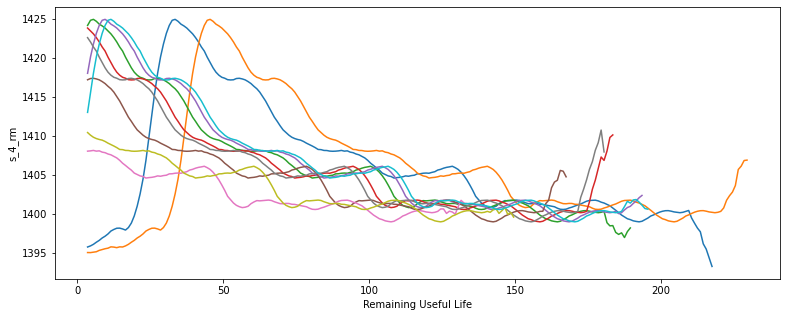

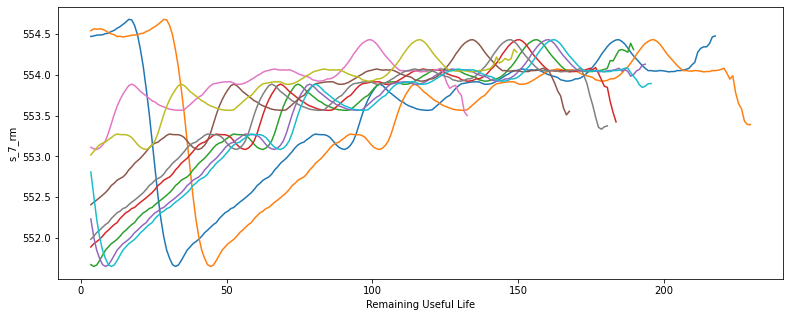

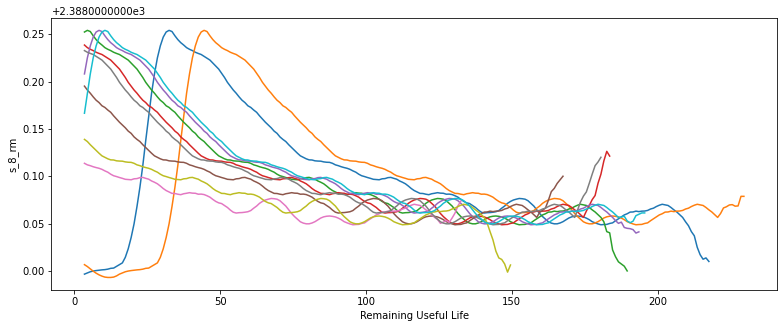

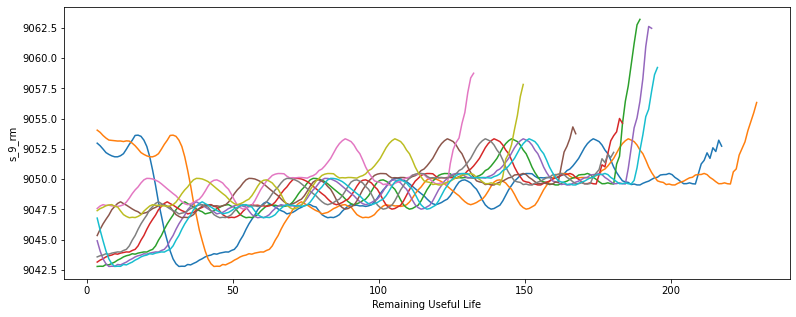

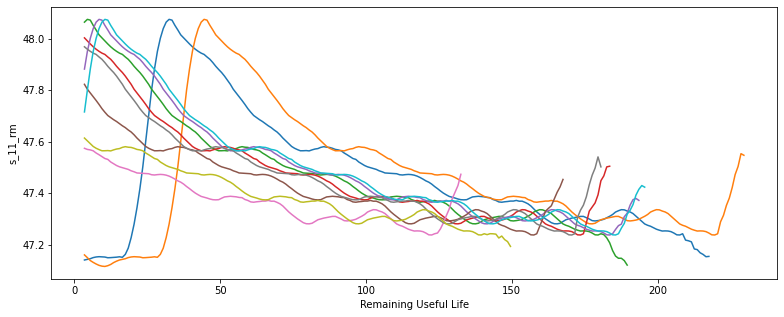

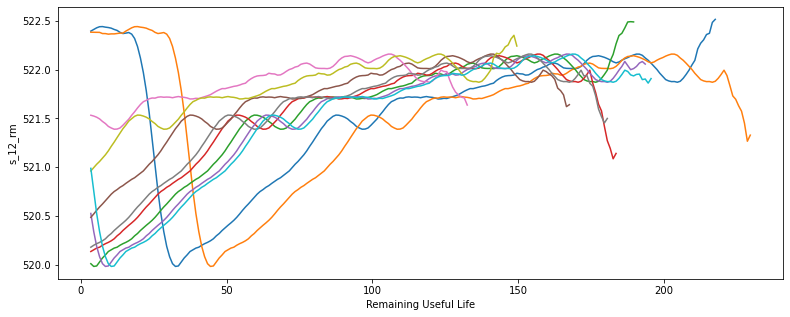

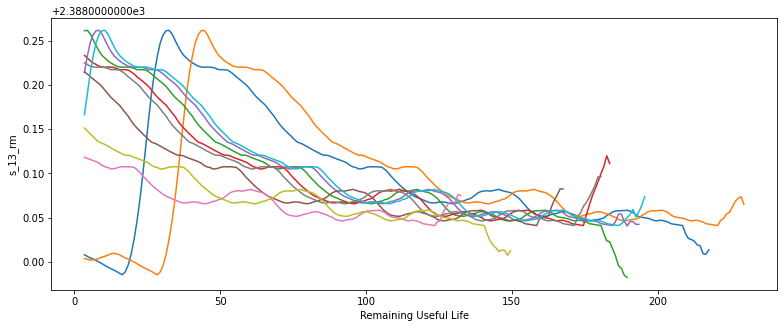

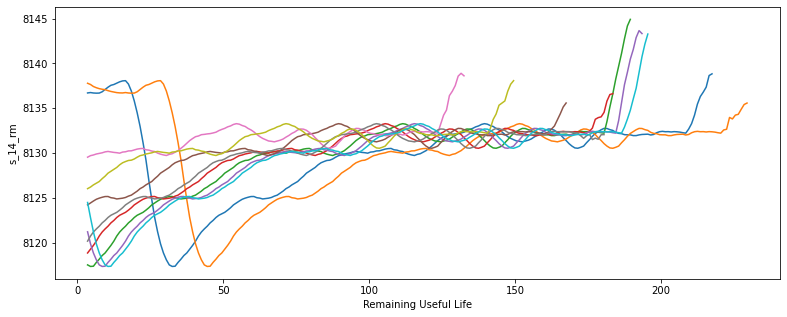

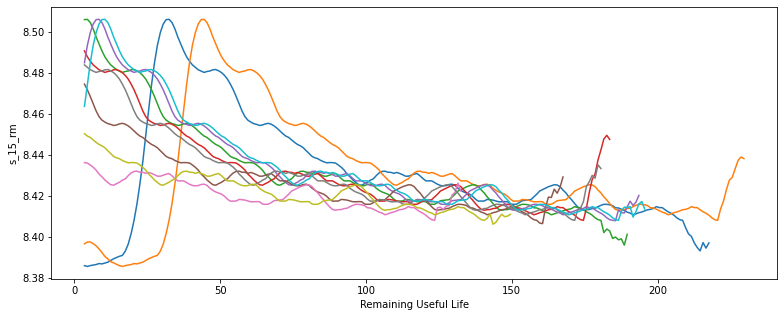

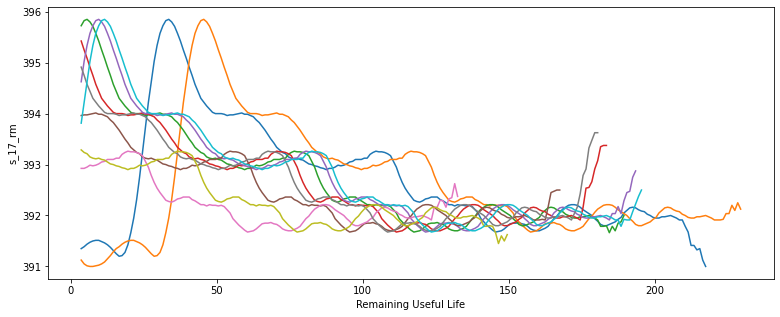

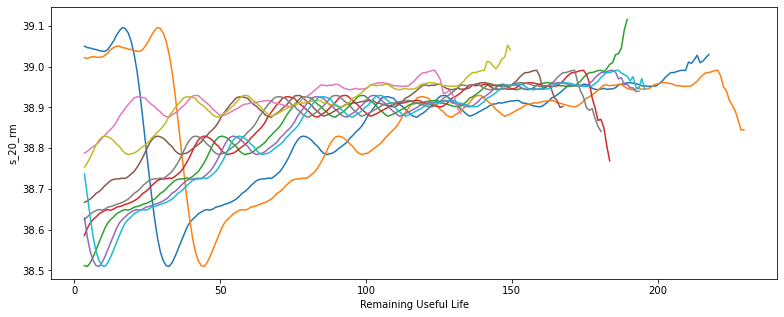

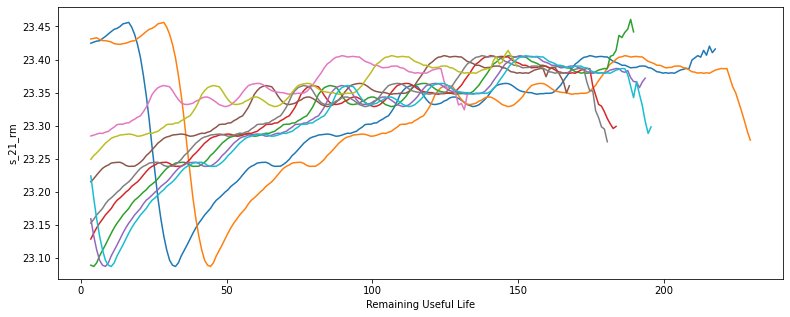

In [112]:
for i in range(1,22):
     if i not in [1,5,6,10,16,18,19] :
        try:
            plot_signal(dftm, 's_'+str(i)+'_rm')
        except:
            pass

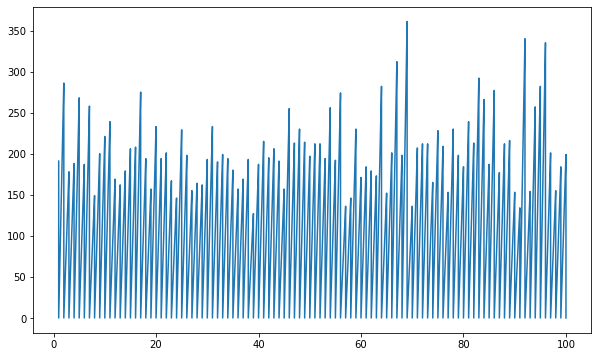

In [113]:
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (10,6)})
plt.plot(dftm_1['RUL'])

In [114]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [115]:
#add decomposition
add_result=seasonal_decompose(dftm_1['RUL'], model='additive',period=1)

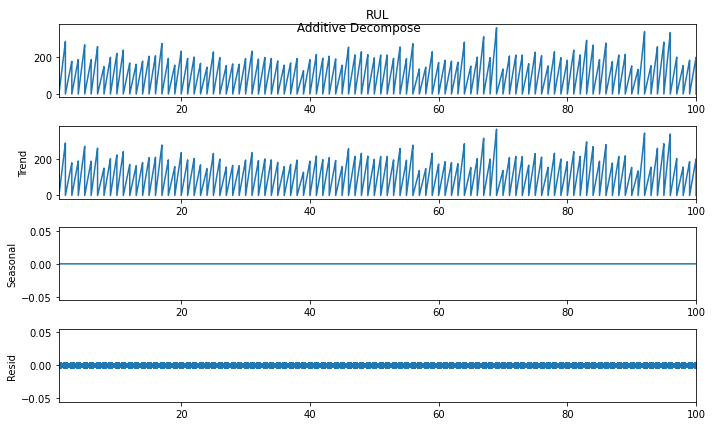

In [116]:
add_result.plot().suptitle('\n Additive Decompose',fontsize=12)
plt.show()

In [117]:
#additive
add=pd.concat([add_result.seasonal,add_result.trend,add_result.resid,add_result.observed],axis=1)
add.columns=['seasonality','trend','residual','actual_values']
add

seasonality  trend  residual  actual_values
unit_number                                             
1                    0.0  191.0       0.0          191.0
1                    0.0  190.0       0.0          190.0
1                    0.0  189.0       0.0          189.0
1                    0.0  188.0       0.0          188.0
1                    0.0  187.0       0.0          187.0
...                  ...    ...       ...            ...
100                  0.0    4.0       0.0            4.0
100                  0.0    3.0       0.0            3.0
100                  0.0    2.0       0.0            2.0
100                  0.0    1.0       0.0            1.0
100                  0.0    0.0       0.0            0.0

[20631 rows x 4 columns]

In [142]:
#add decomposition
add_result_1=seasonal_decompose(dftm_1['s_2'], model='additive',period=1)

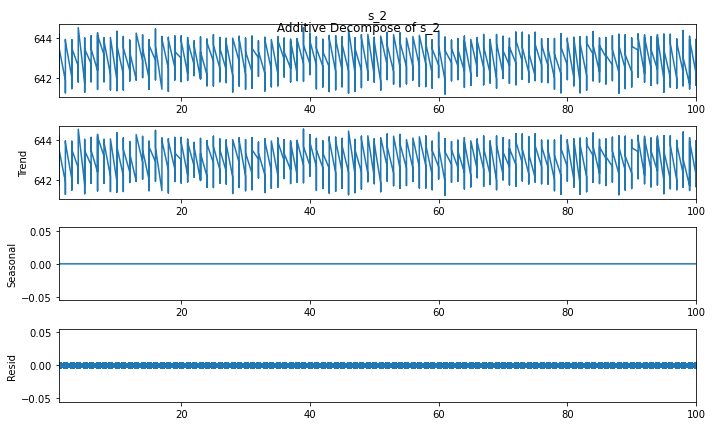

In [143]:
add_result_1.plot().suptitle('\n Additive Decompose of s_2',fontsize=12)
plt.show()

In [118]:
add.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20631 entries, 1 to 100
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   seasonality    20631 non-null  float64
 1   trend          20631 non-null  float64
 2   residual       20631 non-null  float64
 3   actual_values  20631 non-null  float64
dtypes: float64(4)
memory usage: 805.9 KB


### 

What we are seeing here is that sensors s_9, s_11, s_12 et s_7 have a significant effect on RUL.
For instance, if keep all other features constant, we notice that when the Physical core speed (represented by s_9) increases , the RUL is comparatively decreasing.

### Best Model

Judging by the difference in RMSE, we notice that SVR performs better than the other models when executed on the whole dataset.
The test RMSE obtained is 31, which will be our score to beat while running the model on the best features found so far. 

### Classification (split rule values into classes)
- balanced data (2 classes / 3 classes  / 4 classes) binning
-models : random forest, svc, naive bayes, knn
- evaluation : confusion matrix, recall


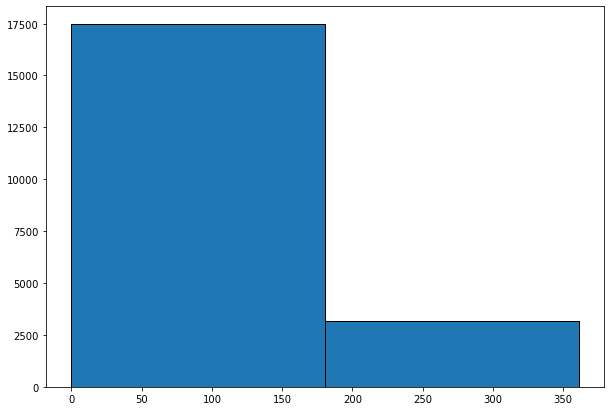

(array([17462.,  3169.]), array([  0. , 180.5, 361. ]), <BarContainer object of 2 artists>)


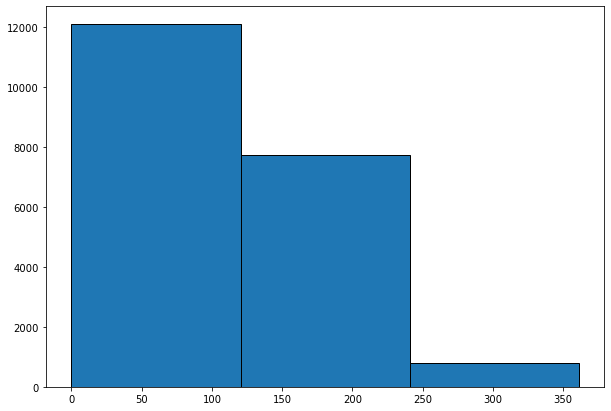

(array([12100.,  7735.,   796.]), array([  0.        , 120.33333333, 240.66666667, 361.        ]), <BarContainer object of 3 artists>)


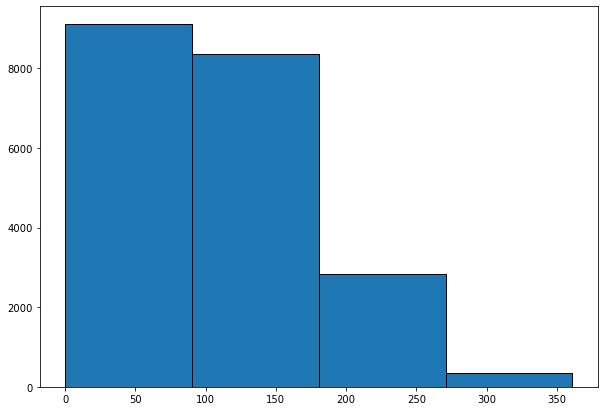

(array([9100., 8362., 2823.,  346.]), array([  0.  ,  90.25, 180.5 , 270.75, 361.  ]), <BarContainer object of 4 artists>)


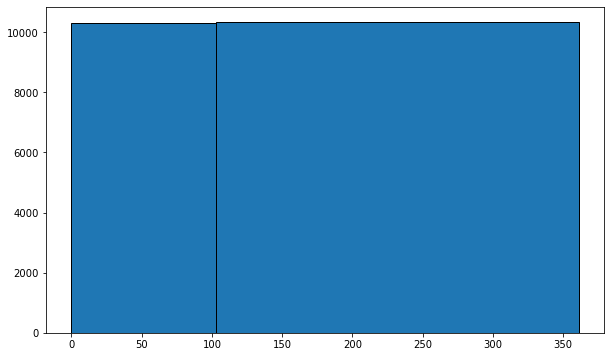

[  0. 103. 361.]


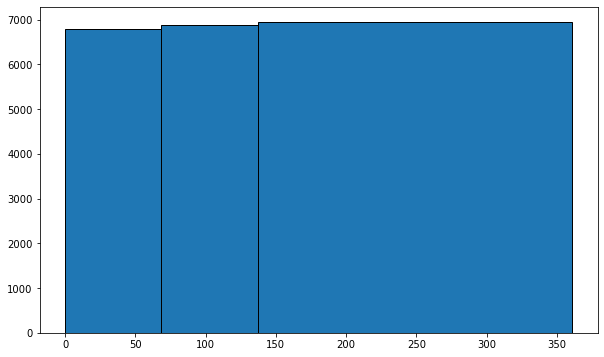

[  0.  68. 137. 361.]


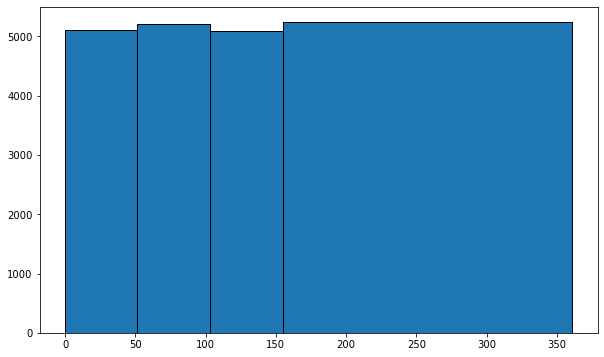

[  0.  51. 103. 155. 361.]


In [119]:
#-- fixing bins width -----
# Creating histogram of 2 bins(same width)
fig, ax = plt.subplots(figsize =(10, 7))
m=ax.hist(list(train['RUL']), bins = 2, edgecolor='black')
# Show plot
plt.show()
print(m)

# Creating histogram of 3 bins(same width)
fig, ax = plt.subplots(figsize =(10, 7))
m=ax.hist(list(train['RUL']), bins = 3, edgecolor='black')
# Show plot
plt.show()
print(m)

# Creating histogram of 4 bins(same width)
fig, ax = plt.subplots(figsize =(10, 7))
m=ax.hist(list(train['RUL']), bins = 4, edgecolor='black')
# Show plot
plt.show()
print(m)



#-- fixing bins height -----

l=len(list(train['RUL']))
k=l/4

#define function to calculate equal-frequency bins, bins=2
def equalObs(x, nbin):
    nlen = len(x)
    return np.interp(np.linspace(0, nlen, nbin + 1),
                     np.arange(nlen),
                     np.sort(x))

#create histogram with equal-frequency bins 
n, bins, patches = plt.hist(list(train['RUL']), equalObs(list(train['RUL']), 2), edgecolor='black')
plt.show()
print(bins)

#define function to calculate equal-frequency bins, bins=3
def equalObs(x, nbin):
    nlen = len(x)
    return np.interp(np.linspace(0, nlen, nbin + 1),
                     np.arange(nlen),
                     np.sort(x))

#create histogram with equal-frequency bins 
n, bins, patches = plt.hist(list(train['RUL']), equalObs(list(train['RUL']), 3), edgecolor='black')
plt.show()
print(bins)


#define function to calculate equal-frequency bins, bins=4
def equalObs(x, nbin):
    nlen = len(x)
    return np.interp(np.linspace(0, nlen, nbin + 1),
                     np.arange(nlen),
                     np.sort(x))

#create histogram with equal-frequency bins 
n, bins, patches = plt.hist(list(train['RUL']), equalObs(list(train['RUL']), 4), edgecolor='black')
plt.show()
print(bins)



####  Binning outcome demonstrated that we can create classes of RUL and turn our problem to a classification problem.
##### The priority will be given for bins that give us balanced classes
###### Let's suppose we have 3 classes of RUL 
- 1 for RUL in [0..68]    : RISK ZONE
- 2 for RUL in [69..137]  : MODERATED RISK
- 3 for RUL in [138..361] : NO RISK

##### ! Notice :  We will be working with last version of data the containing historical data (moving average) with some dropped sensors.

#### Data preparation for classification

In [120]:
y_train_tm

12276     30
8157      80
11666    103
12639    124
5278      30
        ... 
11284    107
11964    162
5390      74
860      195
15795    157
Name: RUL, Length: 13410, dtype: int64

In [121]:
dftm.head()

unit_number     s_2      s_3      s_4     s_7      s_8      s_9   s_11  \
0            1  641.82  1589.70  1400.60  554.36  2388.06  9046.19  47.47   
1            1  642.15  1591.82  1403.14  553.75  2388.04  9044.07  47.49   
2            1  642.35  1587.99  1404.20  554.26  2388.08  9052.94  47.27   
3            1  642.35  1582.79  1401.87  554.45  2388.11  9049.48  47.13   
4            1  642.37  1582.85  1406.22  554.00  2388.06  9055.15  47.28   

     s_12     s_13  ...   s_9_rm  s_11_rm  s_12_rm  s_13_rm  s_14_rm  s_15_rm  \
0  521.66  2388.02  ...  9046.19    47.47   521.66  2388.02  8138.62   8.4195   
1  522.28  2388.07  ...  9044.07    47.49   522.28  2388.07  8131.49   8.4318   
2  522.42  2388.03  ...  9052.94    47.27   522.42  2388.03  8133.23   8.4178   
3  522.86  2388.08  ...  9049.48    47.13   522.86  2388.08  8133.83   8.3682   
4  522.19  2388.04  ...  9055.15    47.28   522.19  2388.04  8133.80   8.4294   

   s_17_rm  s_20_rm  s_21_rm  RUL  
0    392.0    39.06  23.4190  191  
1    392.0    39.00  23.4236  190  
2    390.0    38.95  23.3442  189  
3    392.0    38.88  23.3739  188  
4    393.0    38.90  23.4044  187  

[5 rows x 30 columns]

In [122]:
dftm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20631 entries, 0 to 20630
Data columns (total 30 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   unit_number  20631 non-null  int64  
 1   s_2          20631 non-null  float64
 2   s_3          20631 non-null  float64
 3   s_4          20631 non-null  float64
 4   s_7          20631 non-null  float64
 5   s_8          20631 non-null  float64
 6   s_9          20631 non-null  float64
 7   s_11         20631 non-null  float64
 8   s_12         20631 non-null  float64
 9   s_13         20631 non-null  float64
 10  s_14         20631 non-null  float64
 11  s_15         20631 non-null  float64
 12  s_17         20631 non-null  int64  
 13  s_20         20631 non-null  float64
 14  s_21         20631 non-null  float64
 15  s_2_rm       20631 non-null  float64
 16  s_3_rm       20631 non-null  float64
 17  s_4_rm       20631 non-null  float64
 18  s_7_rm       20631 non-null  float64
 19  s_8_

In [123]:

label_map={1:"RISK ZONE",2:"MODERATED RISK",3:"NO RISK"}

y=[]

#--Transforming rul values to classes :
for k in dftm['RUL']:
    if k<=68:
        y.append(1)
    elif k>69 and k<=137:
        y.append(2)
    else:
        y.append(3)
X_train_tm_c, X_test_tm_c, y_train_tm_c, y_test_tm_c=train_test_split(dftm.drop(columns=['unit_number','RUL']),np.array(y), test_size=0.35, stratify=np.array(y))
X_train_tm_cs=scaler.fit_transform(X_train_tm_c)
X_test_tm_cs=scaler.fit_transform(X_test_tm_c)


In [124]:
dftm.describe().transpose()

count         mean        std         min         25%  \
unit_number  20631.0    51.506568  29.227633     1.00000    26.00000   
s_2          20631.0   642.680934   0.500053   641.21000   642.32500   
s_3          20631.0  1590.523119   6.131150  1571.04000  1586.26000   
s_4          20631.0  1408.933782   9.000605  1382.25000  1402.36000   
s_7          20631.0   553.367711   0.885092   549.85000   552.81000   
s_8          20631.0  2388.096652   0.070985  2387.90000  2388.05000   
s_9          20631.0  9065.242941  22.082880  9021.73000  9053.10000   
s_11         20631.0    47.541168   0.267087    46.85000    47.35000   
s_12         20631.0   521.413470   0.737553   518.69000   520.96000   
s_13         20631.0  2388.096152   0.071919  2387.88000  2388.04000   
s_14         20631.0  8143.752722  19.076176  8099.94000  8133.24500   
s_15         20631.0     8.442146   0.037505     8.32490     8.41490   
s_17         20631.0   393.210654   1.548763   388.00000   392.00000   
s_20         20631.0    38.816271   0.180746    38.14000    38.70000   
s_21         20631.0    23.289705   0.108251    22.89420    23.22180   
s_2_rm       20631.0   642.515211   0.361074   641.25000   642.28900   
s_3_rm       20631.0  1588.392499   3.837145  1571.99000  1585.97200   
s_4_rm       20631.0  1405.286458   7.062489  1387.38000  1400.51200   
s_7_rm       20631.0   553.643857   0.727654   551.37700   553.25300   
s_8_rm       20631.0  2388.092062   0.059575  2387.91000  2388.05700   
s_9_rm       20631.0  9049.400858   3.495195  9033.93000  9047.66500   
s_11_rm      20631.0    47.448330   0.223798    46.85000    47.29200   
s_12_rm      20631.0   521.632824   0.629074   519.83100   521.38700   
s_13_rm      20631.0  2388.091384   0.065053  2387.92000  2388.05000   
s_14_rm      20631.0  8130.560649   4.858498  8115.49000  8129.25000   
s_15_rm      20631.0     8.428869   0.025835     8.33030     8.41412   
s_17_rm      20631.0   392.576836   1.047021   388.00000   391.90000   
s_20_rm      20631.0    38.876517   0.126063    38.46400    38.81300   
s_21_rm      20631.0    23.328447   0.079834    23.05868    23.28583   
RUL          20631.0   107.807862  68.880990     0.00000    51.00000   

                    50%         75%         max  
unit_number    52.00000    77.00000   100.00000  
s_2           642.64000   643.00000   644.53000  
s_3          1590.10000  1594.38000  1616.91000  
s_4          1408.04000  1414.55500  1441.49000  
s_7           553.44000   554.01000   556.06000  
s_8          2388.09000  2388.14000  2388.56000  
s_9          9060.66000  9069.42000  9244.59000  
s_11           47.51000    47.70000    48.53000  
s_12          521.48000   521.95000   523.38000  
s_13         2388.09000  2388.14000  2388.56000  
s_14         8140.54000  8148.31000  8293.72000  
s_15            8.43890     8.46560     8.58480  
s_17          393.00000   394.00000   400.00000  
s_20           38.83000    38.95000    39.43000  
s_21           23.29790    23.36680    23.61840  
s_2_rm        642.42000   642.75500   643.71600  
s_3_rm       1587.61700  1589.95200  1602.39000  
s_4_rm       1403.84200  1408.39300  1425.92300  
s_7_rm        553.89000   554.08700   555.66000  
s_8_rm       2388.07700  2388.11400  2388.27100  
s_9_rm       9049.48400  9050.55000  9078.21000  
s_11_rm        47.38800    47.56400    48.14100  
s_12_rm       521.79400   522.05400   523.31000  
s_13_rm      2388.07100  2388.12000  2388.28400  
s_14_rm      8131.33400  8132.59700  8159.99000  
s_15_rm         8.42342     8.43690     8.51548  
s_17_rm       392.20000   393.10000   396.20000  
s_20_rm        38.91000    38.95500    39.34000  
s_21_rm        23.34659    23.38544    23.61270  
RUL           103.00000   155.00000   361.00000

#### Defining evaluation function

In [125]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true)))

#### Models Implementation

In [126]:
# Fit du  Training set
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear',random_state = 1)

#### Random forest 

In [127]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#### Models evaluation

In [128]:
y_valid_c=[]
for k in y_valid['RUL']:
    if k<=68:
        y_valid_c.append(1)
    elif k>69 and k<=137:
        y_valid_c.append(2)
    else:
        y_valid_c.append(3)
        
y_valid_c=np.array(y_valid_c)

### SVC

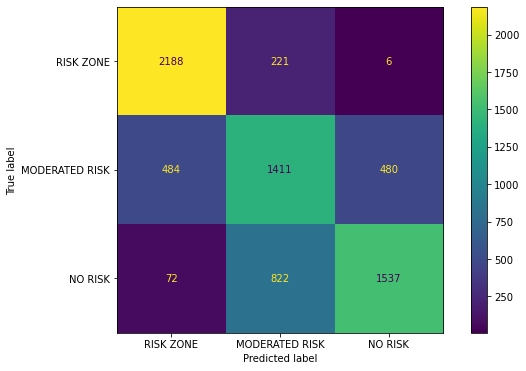

SVM
Accuracy score of training 0.724
Error rate of training 0.153
Accuracy score of test 0.711
Error rate of test 0.144
              precision    recall  f1-score   support

           1       0.80      0.91      0.85      2415
           2       0.57      0.59      0.58      2375
           3       0.76      0.63      0.69      2431

    accuracy                           0.71      7221
   macro avg       0.71      0.71      0.71      7221
weighted avg       0.71      0.71      0.71      7221



In [129]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics

classifier.fit(X_train_tm_cs,np.array(y_train_tm_c))
y_svc_train=classifier.predict(X_train_tm_cs)

y_svc_test=classifier.predict(X_test_tm_cs)


cm= confusion_matrix(y_test_tm_c, y_svc_test, labels=classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[classifier.classes_[0]],label_map[classifier.classes_[1]],label_map[classifier.classes_[2]]])
disp.plot()
plt.show()

# Measure the performance
print('SVM')
print("Accuracy score of training %.3f" %metrics.accuracy_score(y_train_tm_c, y_svc_train))
print("Error rate of training %.3f" %mean_absolute_percentage_error(y_train_tm_c,y_svc_train))
print("Accuracy score of test %.3f" %metrics.accuracy_score(y_test_tm_c, y_svc_test))
print("Error rate of test %.3f" %mean_absolute_percentage_error(y_test_tm_c,y_svc_test))
print(metrics.classification_report(y_test_tm_c,y_svc_test))

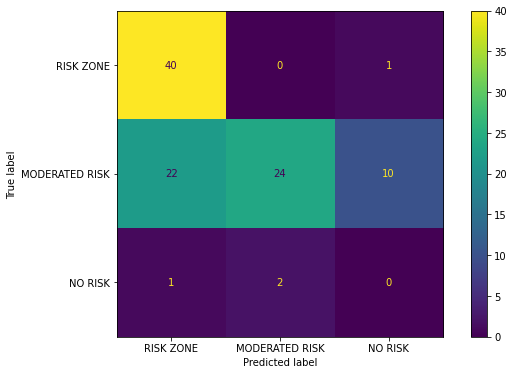

SVM
Accuracy score of validation 0.640
Error rate of validation 0.193


In [130]:
y_svc_valid=classifier.predict(X_valid_s)
cm= confusion_matrix(y_valid_c, y_svc_valid, labels=classifier.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[classifier.classes_[0]],label_map[classifier.classes_[1]],label_map[classifier.classes_[2]]])
disp.plot()
plt.show()
print('SVM')
print("Accuracy score of validation %.3f" %metrics.accuracy_score(y_valid_c,  y_svc_valid))
print("Error rate of validation %.3f" %mean_absolute_percentage_error(y_valid_c, y_svc_valid))

### Random Forest Classifier

In [131]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=5)

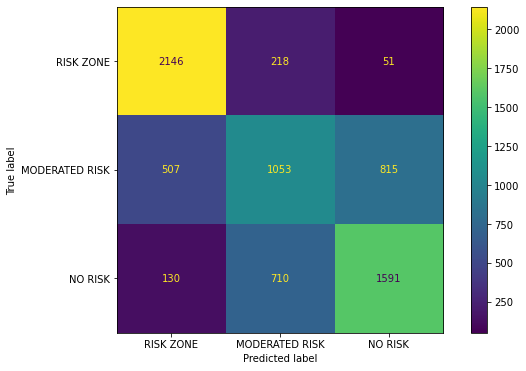

Random Forest Classifier
Accuracy score of test 0.968
Error rate of test 0.016
Accuracy score of test 0.663
Error rate of test 0.181
              precision    recall  f1-score   support

           1       0.77      0.89      0.83      2415
           2       0.53      0.44      0.48      2375
           3       0.65      0.65      0.65      2431

    accuracy                           0.66      7221
   macro avg       0.65      0.66      0.65      7221
weighted avg       0.65      0.66      0.65      7221



In [132]:
clf.fit(X_train_tm_cs,np.array(y_train_tm_c))
y_rfc_train=clf.predict(X_train_tm_cs)
y_rfc_test=clf.predict(X_test_tm_cs)
cm= confusion_matrix(y_test_tm_c, y_rfc_test, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[clf.classes_[0]],label_map[clf.classes_[1]],label_map[clf.classes_[2]]])
disp.plot()
plt.show()

# Measure the performance
print('Random Forest Classifier')
print("Accuracy score of test %.3f" %metrics.accuracy_score(y_train_tm_c, y_rfc_train))
print("Error rate of test %.3f" %mean_absolute_percentage_error(y_train_tm_c,y_rfc_train))

print("Accuracy score of test %.3f" %metrics.accuracy_score(y_test_tm_c, y_rfc_test))
print("Error rate of test %.3f" %mean_absolute_percentage_error(y_test_tm_c,y_rfc_test))

print(metrics.classification_report(y_test_tm_c,y_rfc_test))

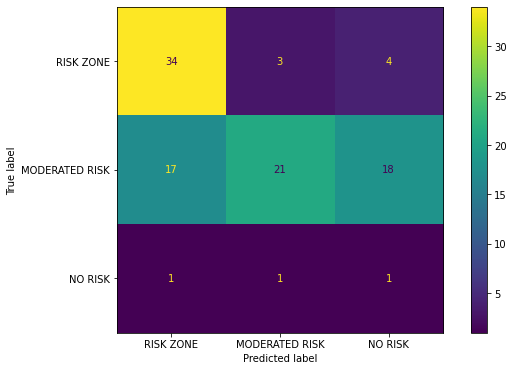

Random Forest Classifier
Accuracy score of validation 0.560
Error rate of validation 0.295
              precision    recall  f1-score   support

           1       0.65      0.83      0.73        41
           2       0.84      0.38      0.52        56
           3       0.04      0.33      0.08         3

    accuracy                           0.56       100
   macro avg       0.51      0.51      0.44       100
weighted avg       0.74      0.56      0.59       100



In [133]:
y_rfc_valid=clf.predict(X_valid_s)
cm= confusion_matrix(y_valid_c, y_rfc_valid, labels=clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[clf.classes_[0]],label_map[clf.classes_[1]],label_map[clf.classes_[2]]])
disp.plot()
plt.show()
print('Random Forest Classifier')
print("Accuracy score of validation %.3f" %metrics.accuracy_score(y_valid_c, y_rfc_valid))
print("Error rate of validation %.3f" %mean_absolute_percentage_error(y_valid_c,y_rfc_valid))
print(metrics.classification_report(y_valid_c,y_rfc_valid))

### Naive bayes

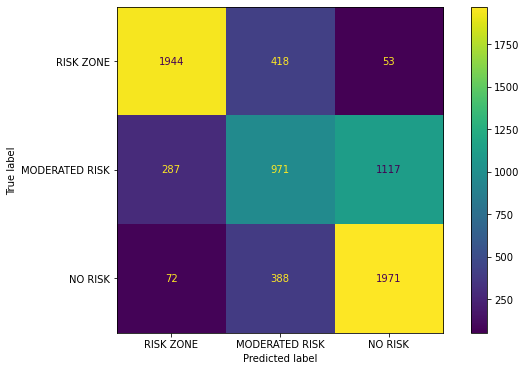

Guassian Naive Bayes
Accuracy score of train 0.670
Error rate of train 0.204
Accuracy score of test 0.677
Error rate of test 0.194
              precision    recall  f1-score   support

           1       0.84      0.80      0.82      2415
           2       0.55      0.41      0.47      2375
           3       0.63      0.81      0.71      2431

    accuracy                           0.68      7221
   macro avg       0.67      0.67      0.67      7221
weighted avg       0.67      0.68      0.67      7221



In [134]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_tm_cs,np.array(y_train_tm_c))

y_gnb_test= gnb.predict(X_test_tm_cs)
y_gnb_train= gnb.predict(X_train_tm_cs)


cm= confusion_matrix(y_test_tm_c, y_gnb_test, labels=gnb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[gnb.classes_[0]],label_map[gnb.classes_[1]],label_map[gnb.classes_[2]]])
disp.plot()
plt.show()

# Measure the performance
print('Guassian Naive Bayes')
print("Accuracy score of train %.3f" %metrics.accuracy_score(y_train_tm_c, y_gnb_train))
print("Error rate of train %.3f" %mean_absolute_percentage_error(y_train_tm_c,y_gnb_train))
print("Accuracy score of test %.3f" %metrics.accuracy_score(y_test_tm_c, y_gnb_test))
print("Error rate of test %.3f" %mean_absolute_percentage_error(y_test_tm_c,y_gnb_test))

print(metrics.classification_report(y_test_tm_c,y_gnb_test))

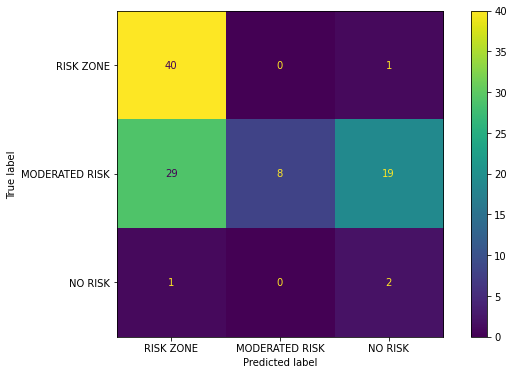

Random Forest Classifier
Accuracy score of validation 0.500
Error rate of validation 0.267
              precision    recall  f1-score   support

           1       0.57      0.98      0.72        41
           2       1.00      0.14      0.25        56
           3       0.09      0.67      0.16         3

    accuracy                           0.50       100
   macro avg       0.55      0.60      0.38       100
weighted avg       0.80      0.50      0.44       100



In [135]:
y_gnb_valid=gnb.predict(X_valid_s)
cm= confusion_matrix(y_valid_c, y_gnb_valid, labels=clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[gnb.classes_[0]],label_map[gnb.classes_[1]],label_map[gnb.classes_[2]]])
disp.plot()
plt.show()
print('Random Forest Classifier')
print("Accuracy score of validation %.3f" %metrics.accuracy_score(y_valid_c, y_gnb_valid))
print("Error rate of validation %.3f" %mean_absolute_percentage_error(y_valid_c,y_gnb_valid))
print(metrics.classification_report(y_valid_c,y_gnb_valid))


### KNN

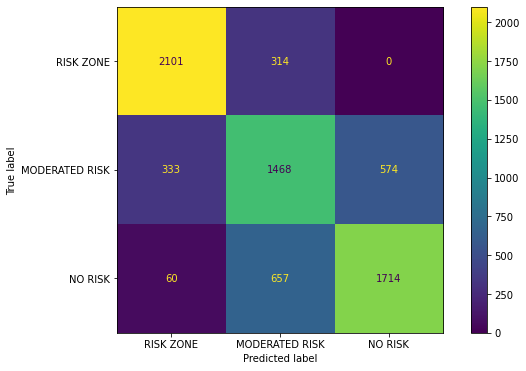

KNN
Accuracy score of train 0.740
Error rate of train 0.143
Accuracy score of test 0.732
Error rate of test 0.142
              precision    recall  f1-score   support

           1       0.84      0.87      0.86      2415
           2       0.60      0.62      0.61      2375
           3       0.75      0.71      0.73      2431

    accuracy                           0.73      7221
   macro avg       0.73      0.73      0.73      7221
weighted avg       0.73      0.73      0.73      7221



In [136]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=100)
knn.fit(X_train_tm_cs,np.array(y_train_tm_c))

y_knn_test= knn.predict(X_test_tm_cs)
y_knn_train= knn.predict(X_train_tm_cs)

cm= confusion_matrix(y_test_tm_c, y_knn_test, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[knn.classes_[0]],label_map[knn.classes_[1]],label_map[knn.classes_[2]]])
disp.plot()
plt.show()

# Measure the performance
print('KNN')
print("Accuracy score of train %.3f" %metrics.accuracy_score(y_train_tm_c, y_knn_train))
print("Error rate of train %.3f" %mean_absolute_percentage_error(y_train_tm_c,y_knn_train))
print("Accuracy score of test %.3f" %metrics.accuracy_score(y_test_tm_c, y_knn_test))
print("Error rate of test %.3f" %mean_absolute_percentage_error(y_test_tm_c,y_knn_test))

print(metrics.classification_report(y_test_tm_c,y_knn_test))

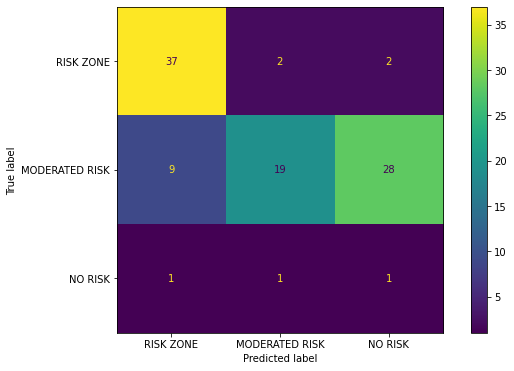

KNN
Accuracy score of validation 0.570
Error rate of validation 0.255
              precision    recall  f1-score   support

           1       0.79      0.90      0.84        41
           2       0.86      0.34      0.49        56
           3       0.03      0.33      0.06         3

    accuracy                           0.57       100
   macro avg       0.56      0.53      0.46       100
weighted avg       0.81      0.57      0.62       100



In [137]:
y_knn_valid=knn.predict(X_valid_s)
cm= confusion_matrix(y_valid_c, y_knn_valid, labels=knn.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[knn.classes_[0]],label_map[knn.classes_[1]],label_map[knn.classes_[2]]])
disp.plot()
plt.show()
print('KNN')
print("Accuracy score of validation %.3f" %metrics.accuracy_score(y_valid_c, y_knn_valid))
print("Error rate of validation %.3f" %mean_absolute_percentage_error(y_valid_c,y_knn_valid))
print(metrics.classification_report(y_valid_c,y_knn_valid))


Running cross validation on SVC (best model so far)

In [138]:
def transform_to_classes(d):
    y=[]
    for k in d:
        if k<=68:
            y.append(1)
        elif k>69 and k<=137:
            y.append(2)
        else:
            y.append(3)
    return y

Index du train :  [    0     1     2 ... 20628 20629 20630] 

Index de test :  [    3    11    17 ... 20613 20614 20618]


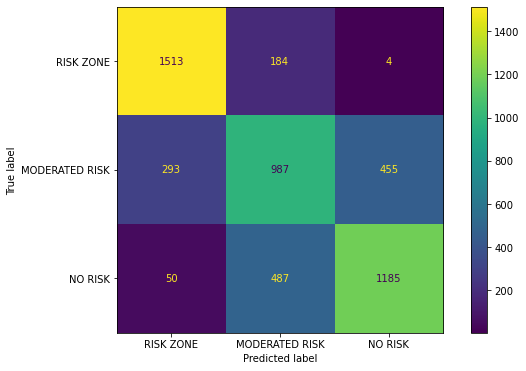

SVM
Accuracy score of training 0.724
Error rate of training 0.155
Accuracy score of test 0.714
Error rate of test 0.148
              precision    recall  f1-score   support

           1       0.82      0.89      0.85      1701
           2       0.60      0.57      0.58      1735
           3       0.72      0.69      0.70      1722

    accuracy                           0.71      5158
   macro avg       0.71      0.72      0.71      5158
weighted avg       0.71      0.71      0.71      5158

Index du train :  [    0     3     4 ... 20625 20627 20630] 

Index de test :  [    1     2     6 ... 20626 20628 20629]


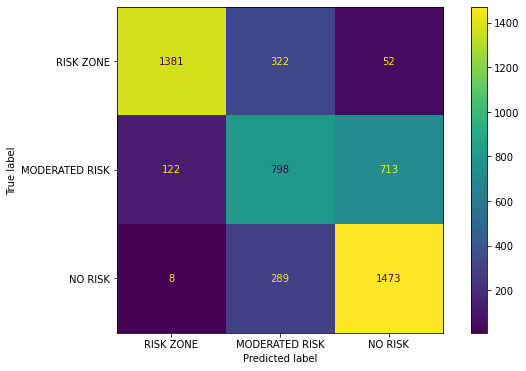

SVM
Accuracy score of training 0.724
Error rate of training 0.153
Accuracy score of test 0.708
Error rate of test 0.183
              precision    recall  f1-score   support

           1       0.91      0.79      0.85      1755
           2       0.57      0.49      0.52      1633
           3       0.66      0.83      0.74      1770

    accuracy                           0.71      5158
   macro avg       0.71      0.70      0.70      5158
weighted avg       0.72      0.71      0.71      5158

Index du train :  [    1     2     3 ... 20626 20628 20629] 

Index de test :  [    0    14    18 ... 20625 20627 20630]


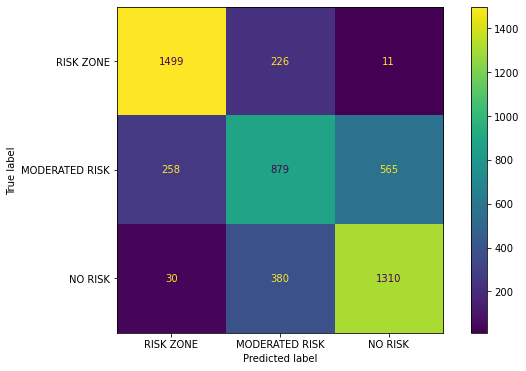

SVM
Accuracy score of training 0.725
Error rate of training 0.153
Accuracy score of test 0.715
Error rate of test 0.156
              precision    recall  f1-score   support

           1       0.84      0.86      0.85      1736
           2       0.59      0.52      0.55      1702
           3       0.69      0.76      0.73      1720

    accuracy                           0.72      5158
   macro avg       0.71      0.71      0.71      5158
weighted avg       0.71      0.72      0.71      5158

Index du train :  [    0     1     2 ... 20628 20629 20630] 

Index de test :  [    4     5     7 ... 20622 20623 20624]


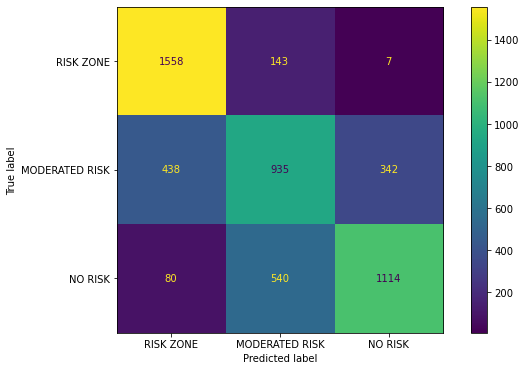

SVM
Accuracy score of training 0.725
Error rate of training 0.153
Accuracy score of test 0.699
Error rate of test 0.151
              precision    recall  f1-score   support

           1       0.75      0.91      0.82      1708
           2       0.58      0.55      0.56      1715
           3       0.76      0.64      0.70      1734

    accuracy                           0.70      5157
   macro avg       0.70      0.70      0.69      5157
weighted avg       0.70      0.70      0.69      5157



In [139]:
from sklearn.model_selection import KFold
train_tm_cv=dftm.drop(columns=['unit_number','RUL']).copy()
y=dftm['RUL']
cv = KFold(n_splits=4, shuffle=True)
for train_index, test_index in cv.split(train_tm) :
    print("Index du train : ", train_index, "\n")
    print("Index de test : ", test_index)
    X_train, X_test, y_train, y_test = train_tm_cv.iloc[train_index,:], train_tm_cv.iloc[test_index,:],np.array(transform_to_classes(y[train_index])), np.array(transform_to_classes(y[test_index]))
    classifier.fit(scaler.fit_transform(X_train), y_train)
    y_svc_train=classifier.predict(scaler.fit_transform(X_train))

    y_svc_test=classifier.predict(scaler.fit_transform(X_test))


    cm= confusion_matrix(y_test, y_svc_test, labels=classifier.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[classifier.classes_[0]],label_map[classifier.classes_[1]],label_map[classifier.classes_[2]]])
    disp.plot()
    plt.show()

    # Measure the performance
    print('SVM')
    print("Accuracy score of training %.3f" %metrics.accuracy_score(y_train, y_svc_train))
    print("Error rate of training %.3f" %mean_absolute_percentage_error(y_train,y_svc_train))
    print("Accuracy score of test %.3f" %metrics.accuracy_score(y_test, y_svc_test))
    print("Error rate of test %.3f" %mean_absolute_percentage_error(y_test,y_svc_test))
    print(metrics.classification_report(y_test,y_svc_test))

Hence, SVR has appeared to be the best model.